# Exploring the Dynamics of Coherent Ising Machines

Coherent Ising Machines (CIMs) are a network of coupled degenerate optical parametric oscillators designed to find the ground state of Ising Hamiltonian:

\begin{equation}
H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_j - \sum_{1 \leq i \leq N} h_i \sigma_i
\end{equation}
Here, $\sigma_i$ represents the spin of the particles, $J_{ij}$ denotes the coupling matrix between spins, and $h_i$ is the external magnetic field vector.

Many NP-hard combinatorial optimization problems can be mapped to the Ising Hamiltonian using Quadratic Unconstrained Binary Optimization (QUBO) mapping functions. Thus, CIMs offer a means to solve a variety of combinatorial optimization problems through analog computation.


<figure>
<img src="attachment:Ising%20Machines.PNG" style="width:100%">
<figcaption align = "center">  Procedure of solving a COP problem [1] </figcaption>
</figure>


# Physics of DOPO

To understand the operation of Coherent Ising Machines (CIMs), it is essential to first examine the physics of degenerate optical parametric oscillators (DOPOs). A DOPO consists of a nonlinear crystal placed within an optical cavity. When the pump power is below the oscillation threshold, the DOPO remains in a squeezed vacuum state. As the pump power increases and exceeds this threshold, the oscillator collapses randomly into a coherent state with a phase of either
$0$ or $\pi$. This bistable behavior enables the mapping of spin values $\pm{1}$ to these phase states.


<figure>
<img src="attachment:DOPO.PNG" style="width:50%">
<figcaption align = "center"> Schematic diagram of the analog spin system based on DOPO. a DOPO process. A high-energy photon (indicated in blue) incident on the PPLN crystal is converted into two identical low-energy photons (indicated in red). PPLN: Periodically polarized lithium niobate crystal. b Quantum noise distribution of DOPO, b is below the threshold, and c is above the threshold [2]. </figcaption>
</figure>



The mean-field description of the in-phase quadrature has the following dynamical equation:
$$
\frac{dx}{dt} = (p - 1)x - \beta x^3,
$$
where $x$ denotes the amplitude of each DOPO, $p$ represents the normalized pump gain, $-1$ is the normalized linear term, and $-\beta x^3$ is the saturation gain. We can assign the potential
$$
V(x) = \frac{1 - p}{2} x^2 + \frac{\beta}{4} x^4
$$
to this equation. In this part, we will investigate the behavior of a single DOPO and its steady states as a function of the parameters in the problem.







# Required Packages

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import networkx as nx
import timeit
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm
from scipy.integrate import solve_ivp

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Single DOPO Potential and Dynamical Equation

In [1]:
import ipywidgets as widgets
from ipywidgets import interact

In [7]:
# Define the potential function V(x)
def potential(x, p, beta):
    return (1 - p) / 2 * x**2 + beta / 4 * x**4

# Define the steady state solutions for the equation dx/dt = (p-1)x - beta * x^3
def steady_states(p, beta):
    steady_states = []
    if p > 1:
        x1 = np.sqrt((p - 1) / beta)
        x2 = -x1
        steady_states.extend([x1, x2])
    elif p < 1:
        steady_states = [0]
    return steady_states

# Combined plotting function
def update_plots(p, beta):
    x = np.linspace(-2, 2, 400)
    V = potential(x, p, beta)

    p_values = np.linspace(0, 5, 100)
    steady_states_list = [steady_states(p, beta) for p in p_values]

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the potential function in the first subplot
    axs[0].plot(x, V, label=r"$V(x) = \frac{(1-p)}{2} x^2 + \frac{\beta}{4} x^4$")
    axs[0].set_title(r"Potential Function $V(x)$", fontsize=14)
    axs[0].set_xlabel(r"$x$", fontsize=12)
    axs[0].set_ylabel(r"$V(x)$", fontsize=12)
    axs[0].grid(True)
    axs[0].legend(loc='best')

    # Plot the steady states in the second subplot
    for i, p in enumerate(p_values):
        axs[1].plot([p] * len(steady_states_list[i]), steady_states_list[i], 'ro')
    axs[1].set_title(r"Steady States of a DOPO", fontsize=14)
    axs[1].set_xlabel(r"$p$", fontsize=12)
    axs[1].set_ylabel(r"Steady States", fontsize=12)
    axs[1].set_xlim(0, 5)
    axs[1].set_ylim(-2, 2)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Create sliders for p and beta
p_slider = widgets.FloatSlider(value=0.5, min=-5, max=5, step=0.01, description='p:', continuous_update=False)
beta_slider = widgets.FloatSlider(value=1.0, min=0.1, max=3, step=0.1, description='beta:', continuous_update=False)

# Use interact to update the plots interactively
interact(update_plots, p=p_slider, beta=beta_slider)


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='p:', max=5.0, min=-5.0, ste…

<function __main__.update_plots(p, beta)>

# Animation for Potential

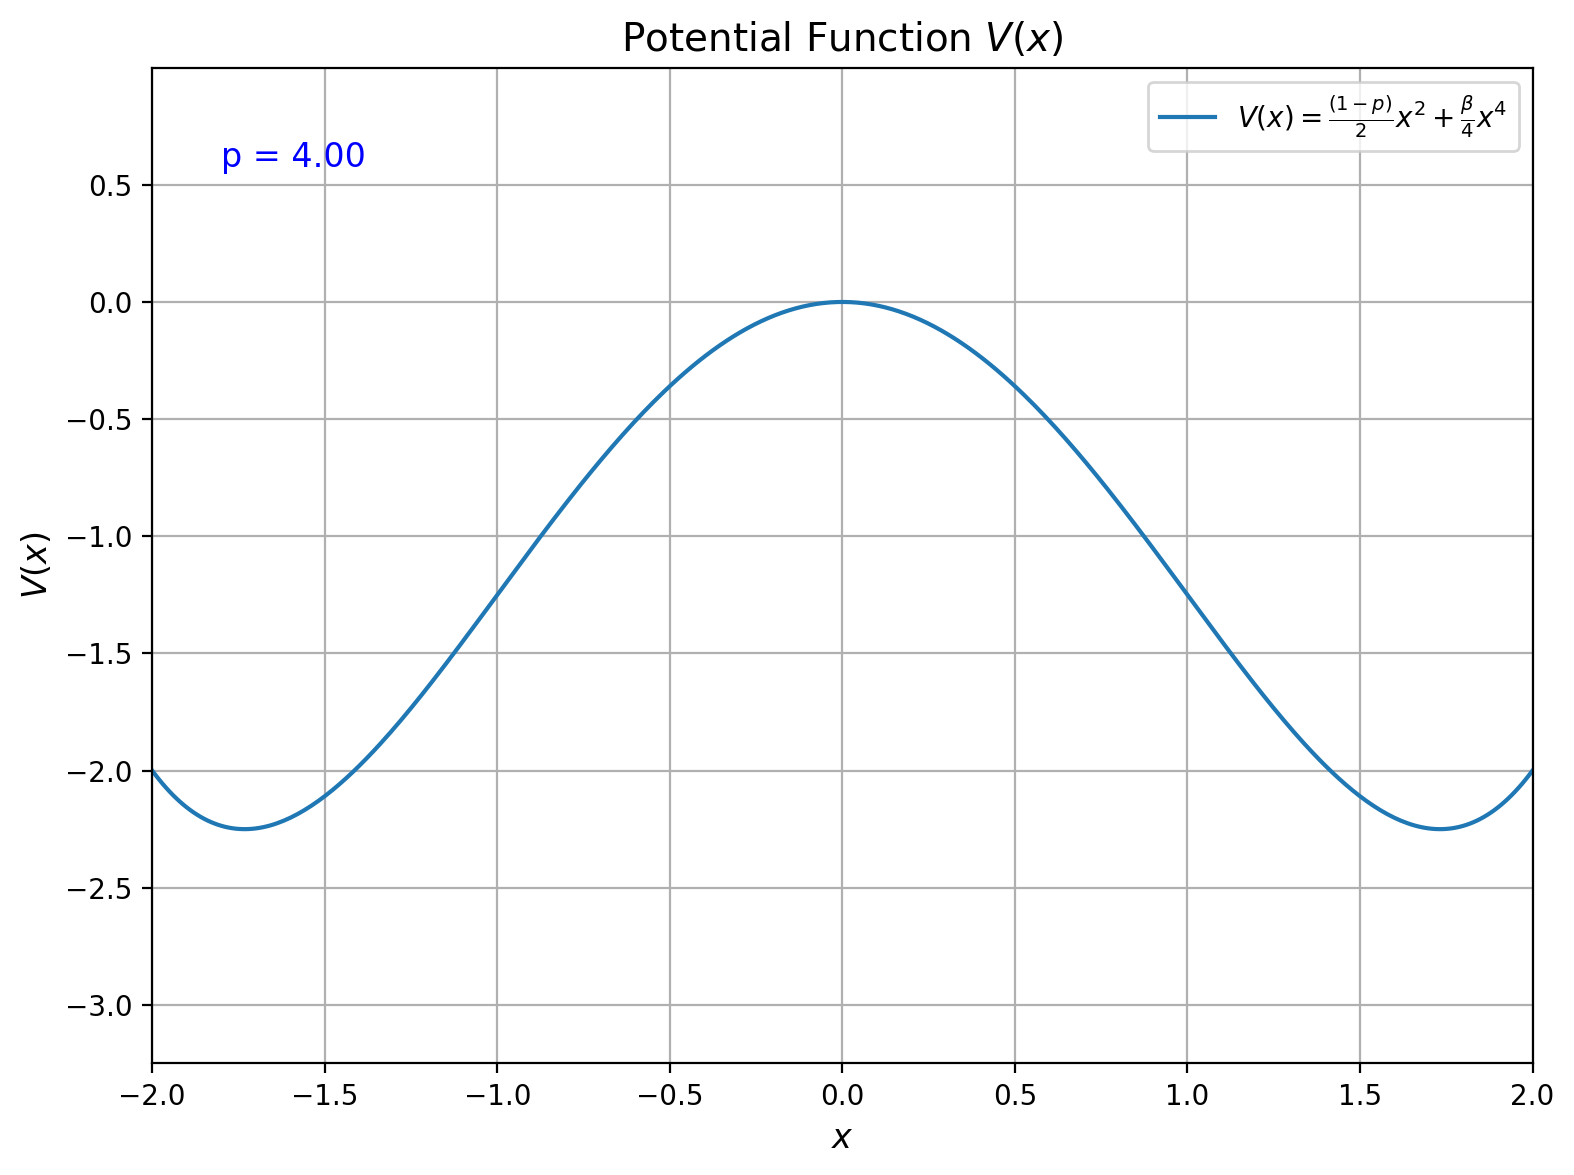

In [14]:
# Define the potential function V(x)
def potential(x, p, beta):
    return (1 - p) / 2 * x**2 + beta / 4 * x**4

# Animation function for the potential plot
def animate_potential(beta):
    x = np.linspace(-2, 2, 400)
    p_values = np.linspace(0, 4, 100)

    fig, ax = plt.subplots(figsize=(8, 6))

    # Prepare the plot
    line_potential, = ax.plot([], [], label=r"$V(x) = \frac{(1-p)}{2} x^2 + \frac{\beta}{4} x^4$")
    ax.set_title(r"Potential Function $V(x)$", fontsize=14)
    ax.set_xlabel(r"$x$", fontsize=12)
    ax.set_ylabel(r"$V(x)$", fontsize=12)
    ax.grid(True)
    ax.legend(loc='best')

    # Add a text annotation for the value of p
    text_p = ax.text(0.05, 0.9, '', transform=ax.transAxes, fontsize=12, color='blue')

    def update(frame):
        p = p_values[frame]
        V = potential(x, p, beta)
        line_potential.set_data(x, V)
        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(V.min() - 1, V.max() + 1)

        # Update the text annotation with the current value of p
        text_p.set_text(f"p = {p:.2f}")

        return line_potential, text_p

    ani = FuncAnimation(fig, update, frames=len(p_values), interval=100, blit=True)
    ani.save('potential_animation.mp4', writer='ffmpeg', fps=10)
    plt.tight_layout()
    plt.show()

# Run the animation with a fixed beta value
animate_potential(beta=1.0)


# Finding J and h for Some Problems

In this part, I have developed several functions to generate the equivalent $J$ and $h$ matrices for various graph problems, such as the number partitioning problem and the traveling salesman problem, using the NetworkX library. These matrices will help us benchmark different dynamical equations that simulate the behavior of the coherent Ising machine.


In [43]:
# Define parameters for a random Ising problem
N = 20  # Number of equations for x_i and e_i (dimension of x vector)
J = -np.random.rand(N, N)  # Randomly generated matrix J (NxN)
J = (J + J.T) / 2  # Make J symmetric if needed
np.fill_diagonal(J, 0) # ensure diagonal elements of the coupling matrix J are zero
h = np.random.rand(N) # Randomly generated external magnetic field
h=np.zeros(N)

# Generating and Plotting the Graph

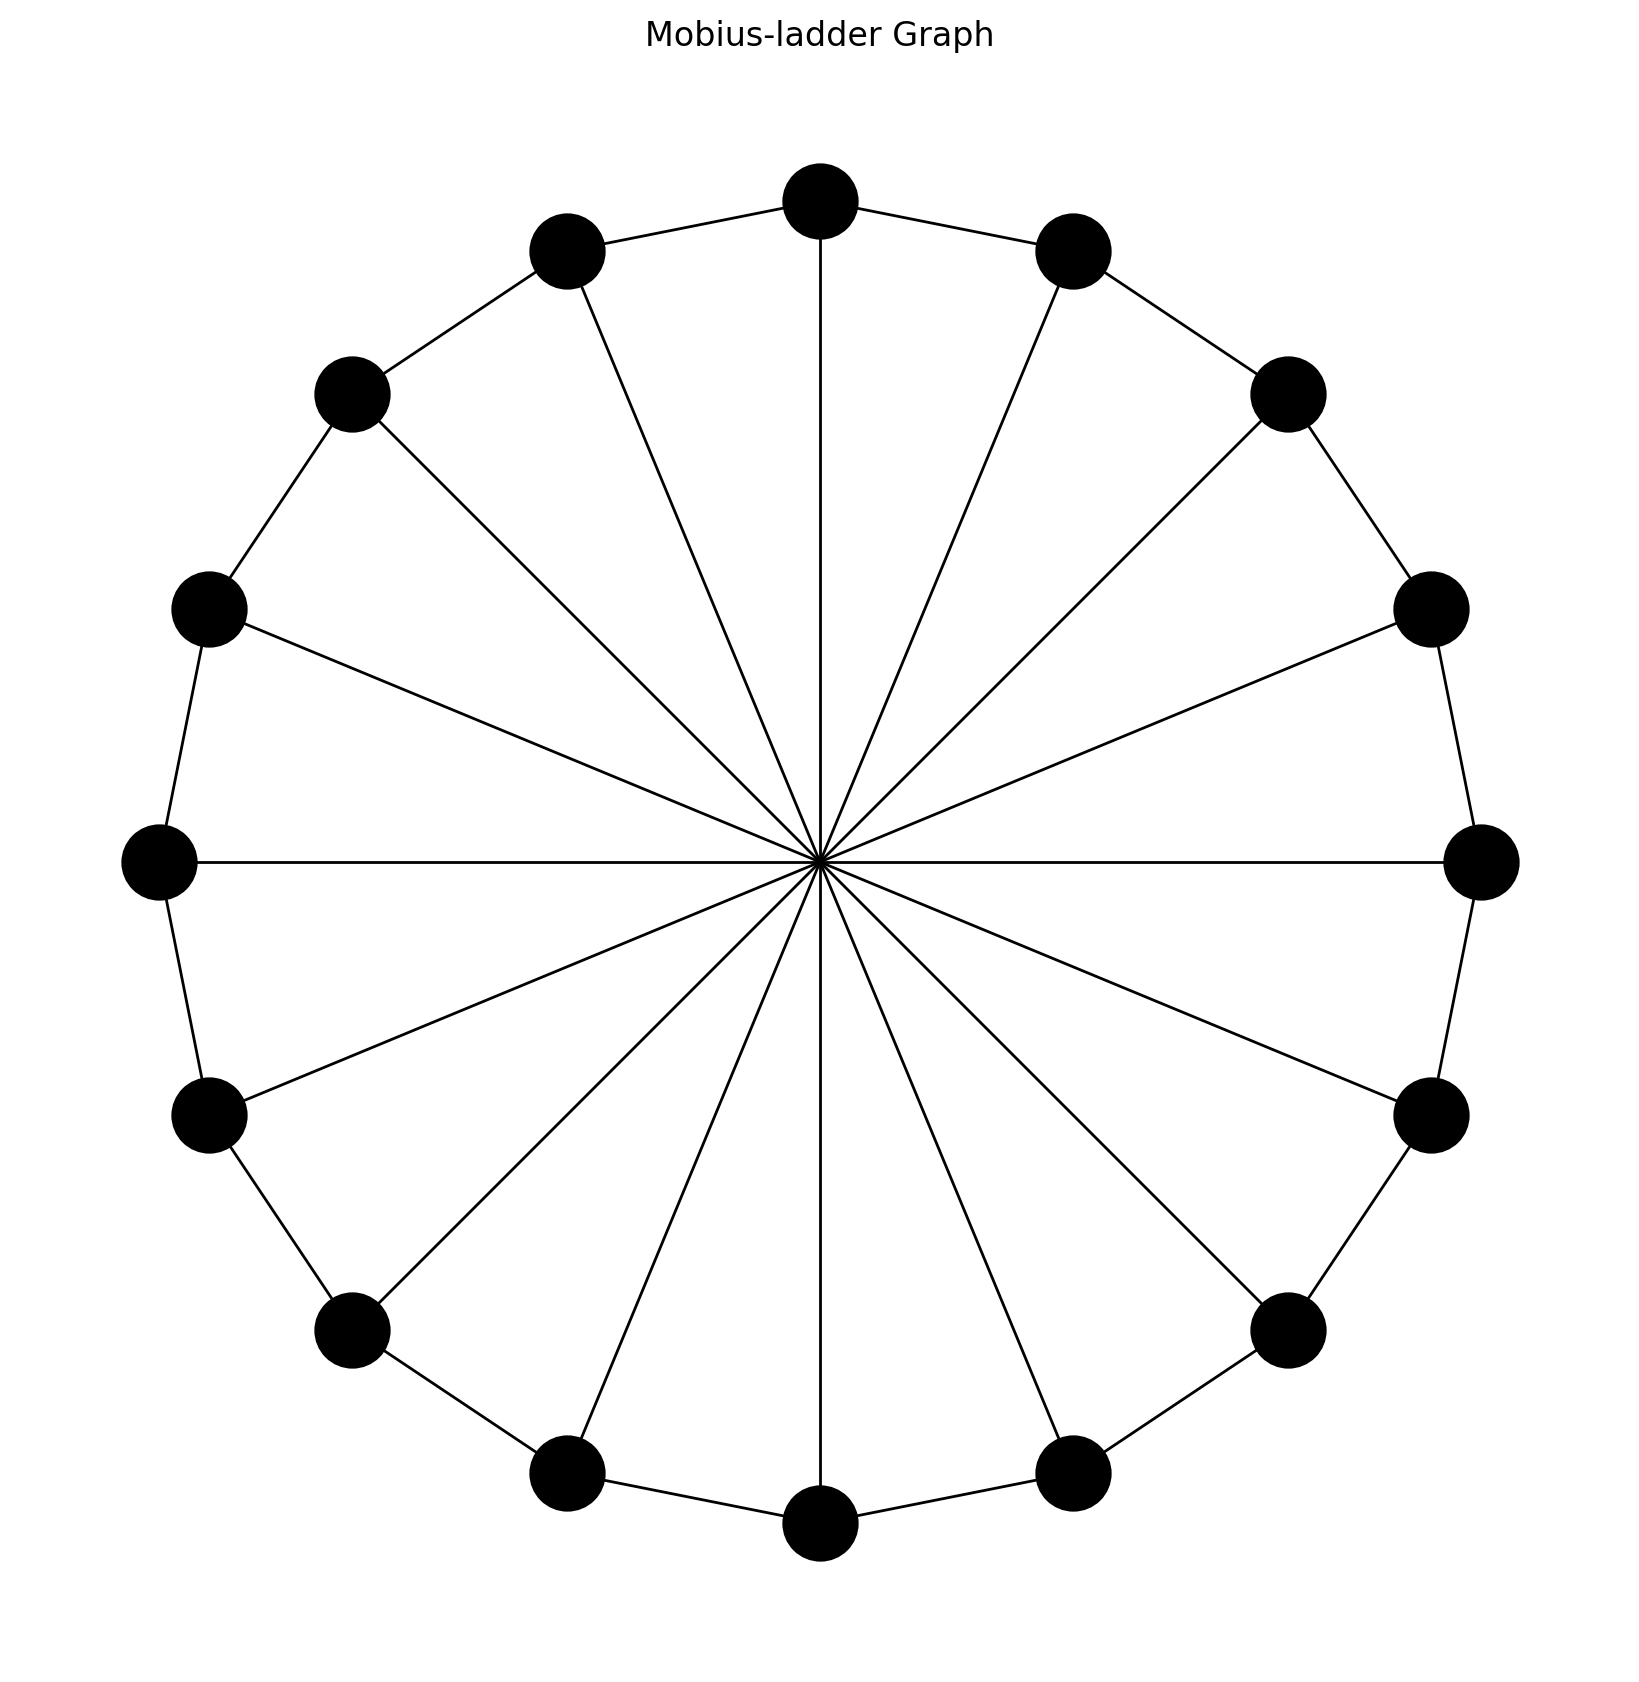

Möbius Ladder Graph Adjacency Matrix:
 [[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]]


In [52]:
def mobius_ladder_graph(N):
    """
    Generate a Möbius ladder graph for N vertices.

    Parameters:
        N (int): Must be even (number of vertices).

    Returns:
        G (networkx.Graph): A Möbius ladder graph.
    """
    if N % 2 != 0:
        raise ValueError("N must be even to create a Möbius ladder.")

    # Create a cycle graph
    G = nx.cycle_graph(N)

    # Add Möbius twist connections
    for i in range(N // 2):
        G.add_edge(i, (i + N // 2) % N)

    return G

def chimera_graph(m, n, t):
    """
    Generate a Chimera graph with parameters m, n (grid size) and t (vertices per cell).

    Parameters:
        m (int): Number of rows in the grid (number of unit cells).
        n (int): Number of columns in the grid (number of unit cells).
        t (int): Number of vertices in each unit cell.

    Returns:
        G (networkx.Graph): A Chimera graph.
    """
    # Create an empty graph
    G = nx.Graph()

    # Number of unit cells
    unit_cells = m * n

    # Adding vertices for each unit cell
    for i in range(unit_cells):
        for j in range(t):
            G.add_node(i * t + j)

    # Adding edges for horizontal connections within each unit cell
    for i in range(unit_cells):
        base = i * t
        for j in range(t - 1):
            G.add_edge(base + j, base + j + 1)

    # Adding edges for vertical connections between unit cells in the same column
    for i in range(m):
        for j in range(n):
            cell = i * n + j
            if i < m - 1:  # Ensure not out of bounds
                for k in range(t):
                    G.add_edge(cell * t + k, ((i + 1) * n + j) * t + k)

    # Adding diagonal edges between adjacent cells
    for i in range(m - 1):
        for j in range(n - 1):
            cell1 = i * n + j
            cell2 = (i + 1) * n + (j + 1)
            for k in range(t):
                G.add_edge(cell1 * t + k, cell2 * t + k)

    return G

# Function to generate SK model adjacency matrix
def generate_sk_adjacency_matrix(N):
    """
    Generate an adjacency matrix for the Sherrington-Kirkpatrick (SK) model.

    Parameters:
    - N: int, the number of spins (nodes).

    Returns:
    - J: ndarray, an NxN adjacency matrix with Gaussian-distributed couplings.
    """
    # Generate Gaussian random couplings with mean 0 and variance 1/N
    J = np.random.normal(loc=0, scale=np.sqrt(1 / N), size=(N, N))

    # Make the matrix symmetric (J_ij = J_ji)
    J = (J + J.T) / 2

    # Ensure diagonal elements are zero (no self-coupling)
    np.fill_diagonal(J, 0)

    return J

def generate_graph(graph_name, **kwargs):
    """
    Generates a graph based on the name and parameters, and returns its adjacency matrix and plot.

    Parameters:
        graph_name (str): Name of the graph (e.g., 'Chimera', 'Erdos-Renyi', etc.).
        kwargs: Additional parameters specific to the graph type.

    Returns:
        adjacency_matrix (numpy.ndarray): The adjacency matrix of the graph.
    """
    graph_name = graph_name.lower()
    G = None

    # Generate the graph based on the name
    if graph_name == 'chimera':
        m = kwargs.get('m', 1)
        n = kwargs.get('n', 1)
        t = kwargs.get('t', 4)  # default chimera graph parameters
        G = chimera_graph(m, n, t)
    elif graph_name == 'erdos-renyi':
        n = kwargs.get('n', 10)
        p = kwargs.get('p', 0.5)
        G = nx.erdos_renyi_graph(n, p)
    elif graph_name == 'complete':
        n = kwargs.get('n', 10)
        G = nx.complete_graph(n)
    elif graph_name == 'path':
        n = kwargs.get('n', 10)
        G = nx.path_graph(n)
    elif graph_name == 'cycle':
        n = kwargs.get('n', 10)
        G = nx.cycle_graph(n)
    elif graph_name == 'grid':
        m = kwargs.get('m', 3)
        n = kwargs.get('n', 3)
        G = nx.grid_2d_graph(m, n)
    elif graph_name == 'star':
        n = kwargs.get('n', 10)
        G = nx.star_graph(n)
    elif graph_name == 'barbell':
        n1 = kwargs.get('n1', 5)
        n2 = kwargs.get('n2', 1)
        G = nx.barbell_graph(n1, n2)
    elif graph_name == 'wheel':
        n = kwargs.get('n', 10)
        G = nx.wheel_graph(n)
    elif graph_name == 'mobius-ladder':
        n = kwargs.get('n', 10)  # N must be even
        if n % 2 != 0:
            raise ValueError("N must be even to create a Möbius ladder.")
        G = mobius_ladder_graph(n)
    elif graph_name == 'hypercube':
        n = kwargs.get('n', 3)
        G = nx.hypercube_graph(n)
    elif graph_name == 'random-regular':
        n = kwargs.get('n', 10)
        d = kwargs.get('d', 3)
        G = nx.random_regular_graph(d, n)
    elif graph_name == 'sk':
        N = kwargs.get('N', 10)
        J = generate_sk_adjacency_matrix(N)
        G = nx.from_numpy_array(J)
    else:
        raise ValueError(f"Graph type '{graph_name}' is not recognized.")

    # Compute adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(G).todense()

    # Plot the graph
    plt.figure(figsize=(8, 8))
    pos = nx.circular_layout(G)
    nx.draw(G,pos, with_labels=True, node_color='black', node_size=700, font_size=10, font_color='black', edge_color='black')


    # Draw edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_size=8, font_color='red'
    )

    plt.title(f"{graph_name.capitalize()} Graph")
    plt.show()

    return adjacency_matrix


# Example usage:
# Example: Chimera graph (m=2, n=2, t=4)
# Generates a Chimera graph with a 2x2 grid and 4 vertices per cell
#J = generate_graph('chimera', m=2, n=2, t=4)
#print("Chimera Graph Adjacency Matrix:\n", J)

# Example: Erdős–Rényi graph (n=10, p=0.5)
# Generates an Erdős–Rényi random graph with 10 nodes and edge probability of 0.5
#adj_matrix_erdos_renyi = generate_graph('erdos-renyi', n=10, p=0.5)
#print("Erdős–Rényi Graph Adjacency Matrix:\n", J)

# Example: Complete graph (n=5)
# Generates a complete graph with 5 nodes (each node connected to every other node)
# J = generate_graph('complete', n=5)
# print("Complete Graph Adjacency Matrix:\n", J)

# Example: Path graph (n=6)
# Generates a path graph with 6 nodes (nodes connected in a line)
# J = generate_graph('path', n=6)
# print("Path Graph Adjacency Matrix:\n", J)

# Example: Cycle graph (n=6)
# Generates a cycle graph with 6 nodes (nodes connected in a circular manner)
# J = generate_graph('cycle', n=6)
# print("Cycle Graph Adjacency Matrix:\n", J)

# Example: Grid graph (m=3, n=3)
# Generates a 3x3 grid graph (each node connected to its neighbors in a 2D grid)
# J = generate_graph('grid', m=3, n=3)
# print("Grid Graph Adjacency Matrix:\n", J)

# Example: Star graph (n=5)
# Generates a star graph with 5 nodes (one central node connected to others)
# J = generate_graph('star', n=5)
# print("Star Graph Adjacency Matrix:\n", J)

# Example: Barbell graph (n1=5, n2=1)
# Generates a barbell graph with 5 nodes in each component and a single edge connecting them
# J = generate_graph('barbell', n1=5, n2=1)
# print("Barbell Graph Adjacency Matrix:\n", J)

# Example: Wheel graph (n=6)
# Generates a wheel graph with 6 nodes (a cycle with one central node)
# J = generate_graph('wheel', n=6)
# print("Wheel Graph Adjacency Matrix:\n", J)

# Example: Mobius ladder graph (n=10)
# Generates a Möbius ladder graph with 10 nodes (must be even)
J = generate_graph('mobius-ladder', n=16)
print("Möbius Ladder Graph Adjacency Matrix:\n", J)

# Example: Hypercube graph (n=3)
# Generates a 3-dimensional hypercube graph (each node connected to its neighbors in a hypercube structure)
# J = generate_graph('hypercube', n=3)
# print("Hypercube Graph Adjacency Matrix:\n", J)

# Example: Random Regular graph (n=10, d=3)
# Generates a random regular graph with 10 nodes, each node having 3 neighbors
# J = generate_graph('random-regular', n=10, d=3)
# print("Random Regular Graph Adjacency Matrix:\n", J)

# Example: SK model graph (N=5)
# Generates a graph based on the Sherrington-Kirkpatrick model with 5 nodes
# J = generate_graph('sk', N=5)
# print("Sherrington-Kirkpatrick Graph Adjacency Matrix:\n", J)


### Ising Model parameters ###
J=-J
N = J.shape[0]
h=np.zeros(N)

# Number Partitioning Problem to Ising

Given a set $S$ of $N$ positive integers, create two disjoint subsets of integers $S_1$ and $S_2$ such that their sums are equal. The Ising formulation of the number partitioning problem is
$$
H = \left( \sum_{i=1}^N n_i \sigma_i \right)^2=\sum_{i=1}^N n_i^2+2\sum_{i\leq j} n_i n_j \sigma_i \sigma_j
$$
So, the entries of the coupling matrix $J$ are $J_{ij} = n_i n_j$, and the external field $h$ is zero. For example, for the set $S = \{4, 2, 6\}$, the answer to the equivalent Ising problem should be $|\uparrow \, \uparrow \, \downarrow \rangle$.


In [39]:
def number_partitioning_to_ising(a):
    """
    Formulate the Number Partitioning Problem (NPP) as an Ising model.

    Parameters:
        a (list): List of integers representing the items to partition.

    Returns:
        H (numpy.ndarray): Hamiltonian matrix for the Ising model.
        h (numpy.ndarray): Bias term for the Ising model.
    """
    n = len(a)

    # Hamiltonian H = (sum a_i sigma_i)^2
    # H = sum a_i^2 sigma_i^2 + 2 sum a_i a_j sigma_i sigma_j
    # Since sigma_i^2 = 1, we only need the second part.

    # Create the linear term h for the Ising spins
    h = np.zeros(n)

    # Create the quadratic term J for the Ising spins
    J = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            J[i, j] = a[i] * a[j]
            J[j, i] = J[i, j]  # Since J is symmetric

    return J, h

S = [3, 1, 4, 2, 2,20,10,15]

J, h = number_partitioning_to_ising(S)
N=J.shape[0]
J=-J

# Print the Hamiltonian matrix and bias vector
print("Hamiltonian Matrix (J):")
print(J)
print("Bias Vector (h):")
print(h)



Hamiltonian Matrix (J):
[[  -0.   -3.  -12.   -6.   -6.  -60.  -30.  -45.]
 [  -3.   -0.   -4.   -2.   -2.  -20.  -10.  -15.]
 [ -12.   -4.   -0.   -8.   -8.  -80.  -40.  -60.]
 [  -6.   -2.   -8.   -0.   -4.  -40.  -20.  -30.]
 [  -6.   -2.   -8.   -4.   -0.  -40.  -20.  -30.]
 [ -60.  -20.  -80.  -40.  -40.   -0. -200. -300.]
 [ -30.  -10.  -40.  -20.  -20. -200.   -0. -150.]
 [ -45.  -15.  -60.  -30.  -30. -300. -150.   -0.]]
Bias Vector (h):
[0. 0. 0. 0. 0. 0. 0. 0.]


# Travelling Salesman Problem to Ising

The Traveling Salesman Problem (TSP) is a well-known NP-complete problem, which involves finding the shortest path that allows a salesman to visit all cities exactly once and return to the starting city. Mathematically, the problem can be represented on a graph with $N$ nodes, where the goal is to identify the shortest Hamiltonian cycle. A Hamiltonian cycle is defined as a closed path that visits every vertex exactly once. To formulate TSP, we introduce decision variables $x_{i,t}$, where $i$ denotes the node and $t$ represents its position in the ordering. The variable $x_{i,t} = 1$ if the node $i$ appears at position $t$ in the cycle, and zero otherwise. Two primary constraints are imposed: (1) each node appears exactly once in the cycle, and (2) at each position $t$, exactly one node must occur. These constraints are expressed as:
$$\sum_{i=0}^{N-1} x_{i,t} = 1, \quad \text{and} \quad \sum_{t=0}^{N-1} x_{i,t} = 1.$$

To penalize invalid paths, if two nodes $i$ and $j$ (with $x_{i,t} = 1$ and $x_{j,t+1} = 1$) are not connected in the graph, an energy penalty is introduced. This penalty can be written as $ \sum_{i,j,t} (1 - A_{ij}) x_{i,t} x_{j,t+1}$, where $A_{ij}$ is the adjacency matrix of the graph. For simplicity, assuming a fully connected graph, the distance that must be minimized is:
$$\sum_{i,j,t} d_{ij} x_{i,t} x_{j,t+1},$$
where $d_{ij}$ represents the distance between nodes $i$ and $j$. Combining the constraints and the penalty into a single objective function, we obtain:
$$H = \lambda \left( \sum_{i=0}^{N-1} x_{i,t} - 1 \right)^2 + \lambda \left( \sum_{t=0}^{N-1} x_{i,t} - 1 \right)^2 + \sum_{i,j,t} d_{ij} x_{i,t} x_{j,t+1}.$$

Here, $\lambda$ is a free parameter chosen large enough to enforce the constraints. This formulation allows the TSP to be mapped to an Ising Hamiltonian, where the solution is obtained by minimizing the Hamiltonian energy [3].


In [21]:
def tsp_to_ising(d, lam):
    """
    Map the Traveling Salesman Problem (TSP) to the Ising model.

    Args:
        d (2D array): Distance matrix d_ij of size N x N.
        lam (float): Penalty parameter to enforce constraints.

    Returns:
        J (2D array): Coupling strengths as an NxN numpy array.
        h (1D array): Local fields as a 1D numpy array.
    """
    N = len(d)  # Number of cities
    num_vars = N * N  # Total number of variables/spins

    # Initialize J (coupling matrix) and h (local fields)
    J = np.zeros((num_vars, num_vars))
    h = np.zeros(num_vars)

    # Encode the distance costs in J
    for i in range(N):
        for j in range(N):
            for t in range(N):
                t_next = (t + 1) % N  # Enforce order (next time step)
                J[i * N + t, j * N + t_next] += d[i][j]

    # Add penalty terms to enforce constraints
    for t in range(N):  # Each position must be occupied
        for i in range(N):
            for j in range(N):
                if i != j:
                    J[i * N + t, j * N + t] += lam

    for i in range(N):  # Each city must be visited once
        for t in range(N):
            for t_next in range(N):
                if t != t_next:
                    J[i * N + t, i * N + t_next] += lam

    return J, h

# Example Usage
d_example = np.array([[0, 10, 15, 20],
                      [10, 0, 35, 25],
                      [15, 35, 0, 30],
                      [20, 25, 30, 0]])

lam_example = 1000  # Large lambda for constraints
J, h = tsp_to_ising(d_example, lam_example)

J=-J
N=J.shape[0]

print("Coupling Matrix J:")
print(J)

print("\nLocal Field h:")
print(h)

Coupling Matrix J:
[[   -0. -1000. -1000. -1000. -1000.   -10.    -0.    -0. -1000.   -15.
     -0.    -0. -1000.   -20.    -0.    -0.]
 [-1000.    -0. -1000. -1000.    -0. -1000.   -10.    -0.    -0. -1000.
    -15.    -0.    -0. -1000.   -20.    -0.]
 [-1000. -1000.    -0. -1000.    -0.    -0. -1000.   -10.    -0.    -0.
  -1000.   -15.    -0.    -0. -1000.   -20.]
 [-1000. -1000. -1000.    -0.   -10.    -0.    -0. -1000.   -15.    -0.
     -0. -1000.   -20.    -0.    -0. -1000.]
 [-1000.   -10.    -0.    -0.    -0. -1000. -1000. -1000. -1000.   -35.
     -0.    -0. -1000.   -25.    -0.    -0.]
 [   -0. -1000.   -10.    -0. -1000.    -0. -1000. -1000.    -0. -1000.
    -35.    -0.    -0. -1000.   -25.    -0.]
 [   -0.    -0. -1000.   -10. -1000. -1000.    -0. -1000.    -0.    -0.
  -1000.   -35.    -0.    -0. -1000.   -25.]
 [  -10.    -0.    -0. -1000. -1000. -1000. -1000.    -0.   -35.    -0.
     -0. -1000.   -25.    -0.    -0. -1000.]
 [-1000.   -15.    -0.    -0. -1000.   -35.  

# TSP Path from Ising Solution

To derive the TSP path from the Ising solution, we consider a vector of spins $\{\sigma_{i,t}\}$, where $\sigma_{i,t} = +1$ if city $i$ is visited at position $t$, and $\sigma_{i,t} = -1$ otherwise. The solution is first converted to binary variables:
$$
x_{i,t} = \frac{\sigma_{i,t} + 1}{2}.
$$
The binary variables $x_{i,t}$ are reshaped into an $N \times N$ matrix, where rows correspond to cities and columns to positions. For each position $t$, the city $i$ is identified as:
$$
i = \arg\max_{i} \, x_{i,t}.
$$
This ordered sequence of cities $\{i_0, i_1, \dots, i_{N-1}\}$ represents the TSP path.

In [28]:
def extract_tsp_path(spin_solution, N):
    """
    Extract the TSP path from the Ising spin solution.

    Args:
        spin_solution (array): 1D array of spins (+1 or -1).
        N (int): Number of cities.

    Returns:
        list: The ordered list of cities representing the TSP path.
    """
    # Convert spin solution to binary (1 for spin +1, 0 for spin -1)
    binary_solution = (np.array(spin_solution) + 1) // 2

    # Initialize path
    path = []

    # Loop through each position in the tour
    for t in range(N):
        for i in range(N):
            if binary_solution[i * N + t] == 1:
                path.append(i)
                break

    return path

# Simulated Ising spin solution (example output: spins as +1 or -1)
spin_solution = [1, -1, -1, -1,   # City 0 at position 0
                 -1, 1, -1, -1,   # City 1 at position 1
                 -1, -1, 1, -1,   # City 2 at position 2
                 -1, -1, -1, 1]   # City 3 at position 3

# Extract the TSP path
path = extract_tsp_path(spin_solution, N=int(len(spin_solution)**0.5))
print("TSP Path:", path)

TSP Path: [0, 1, 2, 3]


# Brute Force Solution of Ising Model

This function finds the solution to the Ising model using a brute-force algorithm by searching through all the possible states of the system. Do not run it for large $N$ if you do not have enough RAM.


In [44]:
min_energy = 1e20 # initial guess for the minimum energy of the system

def get_binary_list(num, length):
    #Intermediate helper function for brute_force()."""
    bit_string = "{0:b}".format(num)
    num_str_len = len(bit_string)
    num_list = np.zeros(length)
    if num == 0:
        return num_list
    filled_string = (length - num_str_len) * '0' + bit_string
    return list(map(int, filled_string))

# Measure runtime
start_time = timeit.default_timer()

for i in range(2**N):
    spins = np.array(get_binary_list(i, N))
    spins = 2 * (spins > 0) - 1
    H = -1/2*(J.dot(spins)).dot(spins) - h.dot(spins)
    if H < min_energy:
        min_energy = H
        opt_spins = copy.deepcopy(spins)

# End runtime measurement
end_time = timeit.default_timer()

# Print results
print("Energy of Ising Hamiltonian:", min_energy)
print("Solution of Ising Hamiltonian:", opt_spins)
print("Runtime of the function:", end_time - start_time, "seconds")


Energy of Ising Hamiltonian: -14.511328507891633
Solution of Ising Hamiltonian: [-1  1 -1 -1  1 -1  1  1  1 -1 -1  1 -1  1  1 -1 -1  1 -1  1]
Runtime of the function: 17.51577446600004 seconds


# Mean-field Method for CIMs

In this part, I will solve the mean-field equations of coherent Ising machines [4]:

$$
\frac{dx_i}{dt} = (p - 1)x_i - x_i^3 + \epsilon \sum_{i \neq j}^{N} J_{ij} x_j
$$

Here,  $x_i$ denotes the amplitude of each DOPO,  $p$ represents the normalized pump power,  $\epsilon$ is the coupling coefficient between different DOPOs, and  $J_{ij}$ is the Ising coupling matrix.


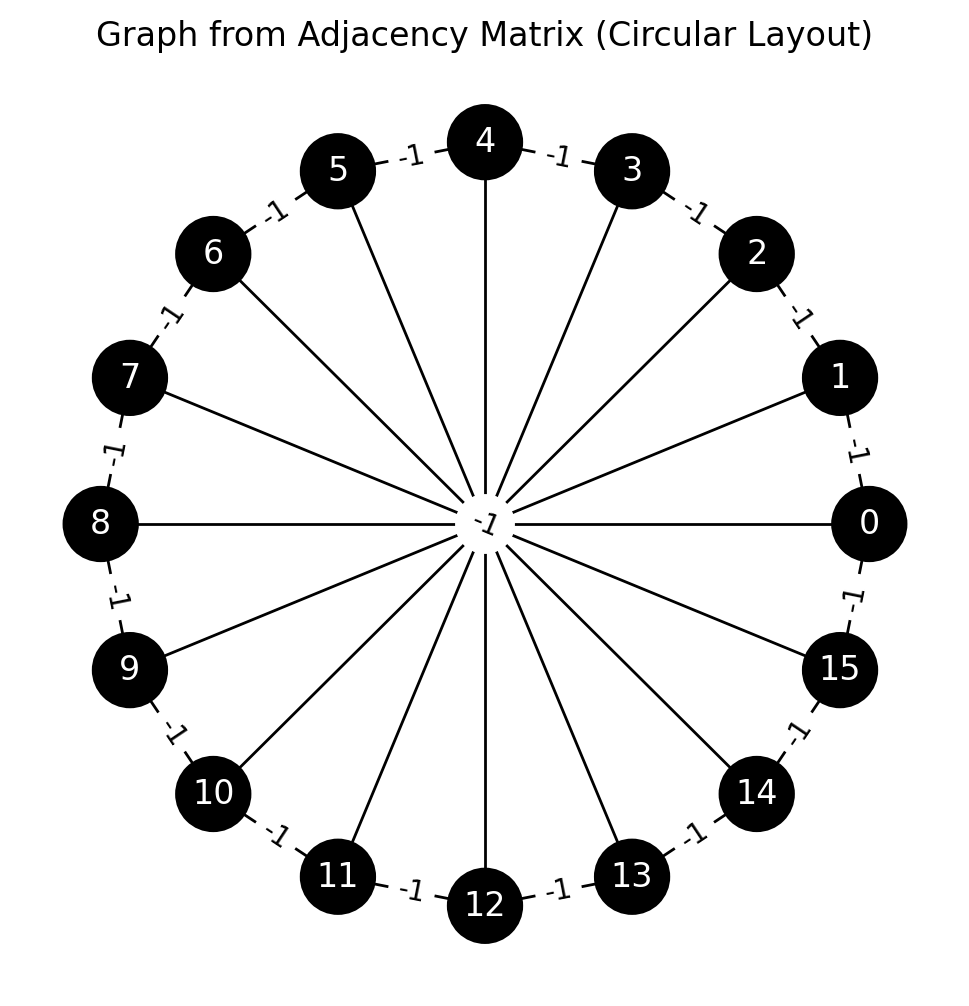

Final state of the machine: [ 1.  1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.]
Final energy of the machine: -20.0
Final cut size: 22.0
Runtime of the function: 0.5064536930003669 seconds


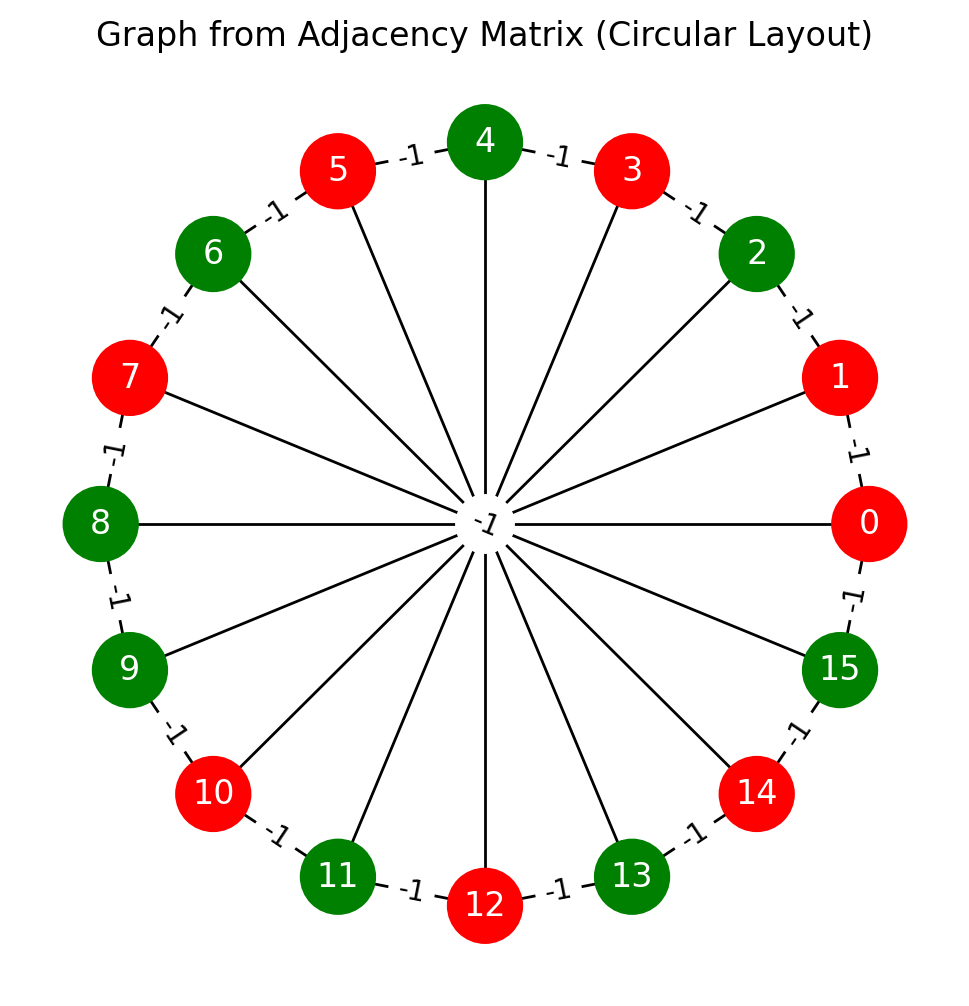

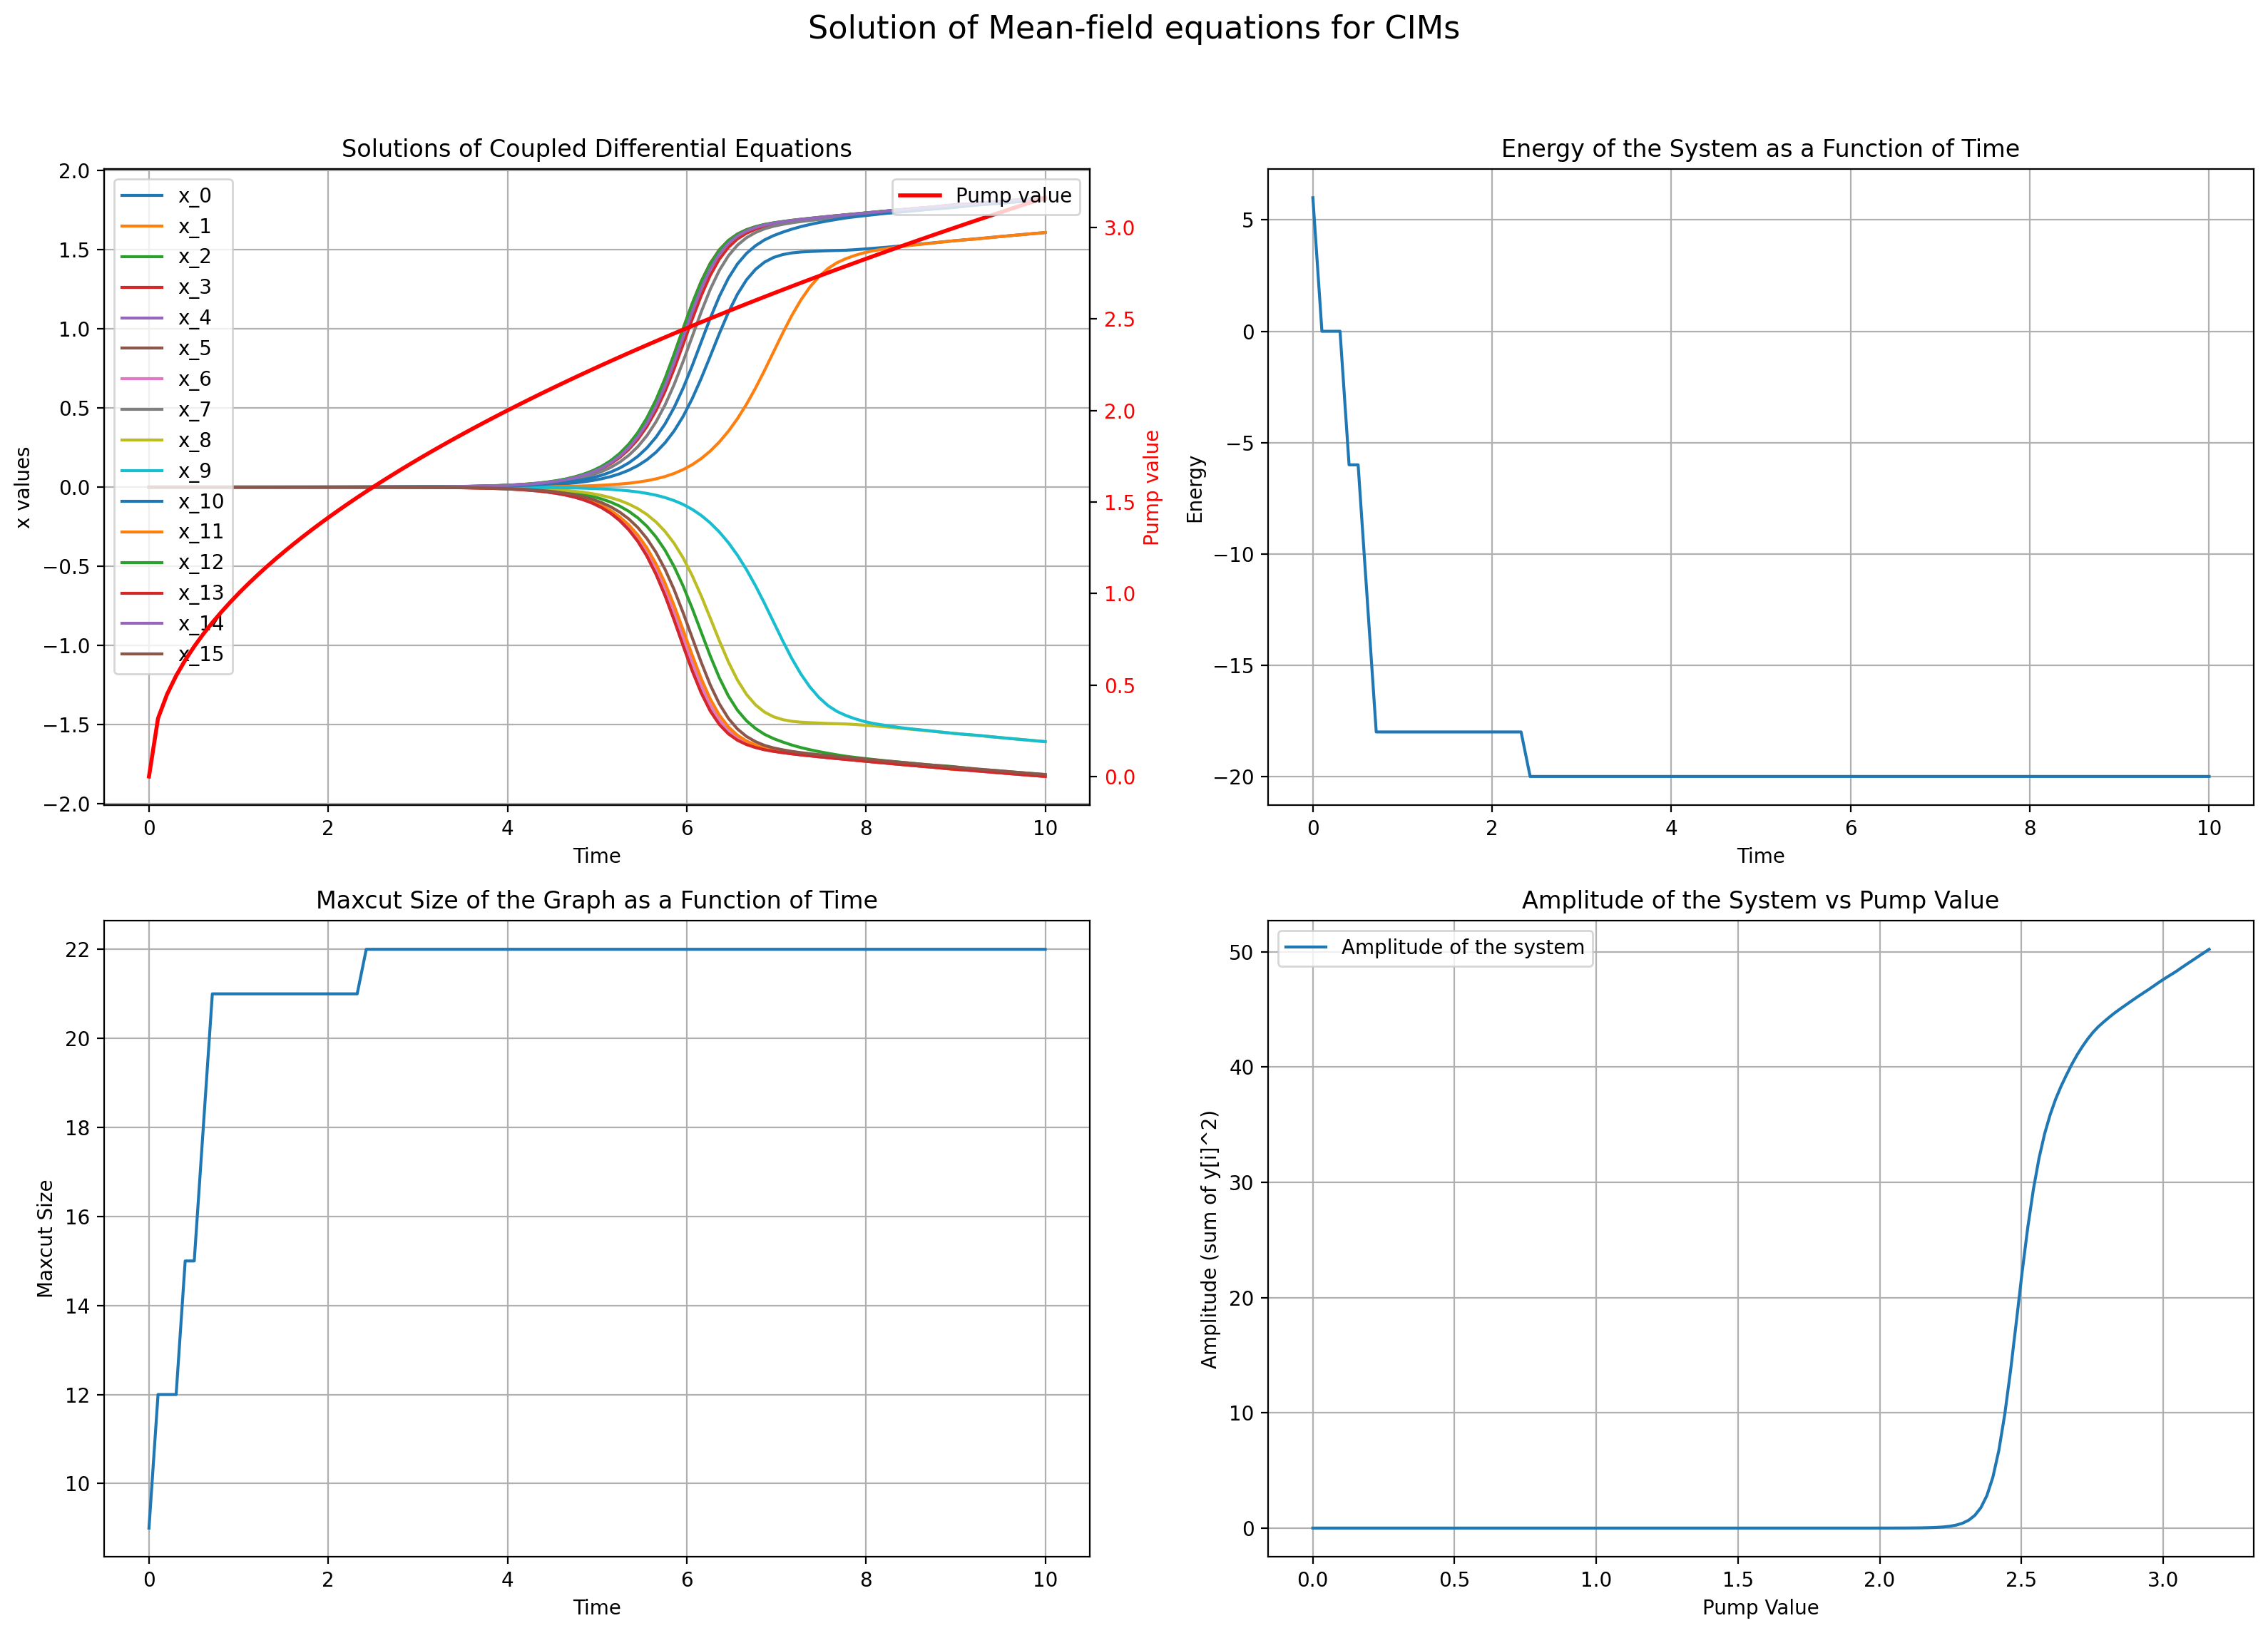

In [53]:
# Define the input function p(t)
def pump_function(t, args):
    pump_type = args['pump_type']
    rng = np.random.default_rng()
    if pump_type == 'linear':
        return  p * t + p0
    elif pump_type == 'sqrt':
        return  p * np.sqrt(t) + p0
    elif pump_type == 'sinusoidal':
        return  p * np.sin(t) + p0
    elif pump_type == 'chaotic':
        random_values = rng.random(len(t))
        return  p * random_values + p0
    else:
        raise ValueError(f"Unknown pump type: {pump_type}")

pump_type = 'linear'  # Default pump type (can be set to 'linear', 'sqrt', 'sinusoidal', or 'chaotic')


# Define the system of differential equations
def coupled_odes(t, x, p, epsilon, J, pump_function, pump_type, N):
    dxdt = np.zeros_like(x)  # Initialize derivative array
    pump_value = pump_function(t, {'pump_type': pump_type})  # Get the pump value
    for i in range(N):
        interaction_term = epsilon * sum(J[i, j] * x[j] for j in range(N) if j != i)
        dxdt[i] = (pump_value - 1) * x[i] - x[i]**3 + interaction_term
    return dxdt

# Implement Euler's method
def euler_method(odes_func, t_span, x0, t_eval, args):
    t0, tf = t_span
    dt = t_eval[1] - t_eval[0]  # Step size
    t_values = np.arange(t0, tf + dt, dt)
    x_values = [x0]
    for t in t_values[:-1]:
        x_current = x_values[-1]
        x_next = x_current + dt * odes_func(t, x_current, *args)
        x_values.append(x_next)
    return t_values, np.array(x_values).T

# Implement RK4 method
def rk4_method(odes_func, t_span, x0, t_eval, args):
    t0, tf = t_span
    dt = t_eval[1] - t_eval[0]
    t_values = np.arange(t0, tf + dt, dt)
    x_values = [x0]
    for t in t_values[:-1]:
        x_current = x_values[-1]
        k1 = dt * odes_func(t, x_current, *args)
        k2 = dt * odes_func(t + dt / 2, x_current + k1 / 2, *args)
        k3 = dt * odes_func(t + dt / 2, x_current + k2 / 2, *args)
        k4 = dt * odes_func(t + dt, x_current + k3, *args)
        x_next = x_current + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        x_values.append(x_next)
    return t_values, np.array(x_values).T

# Define the solver wrapper
def solve_system(method, t_span, x0, t_eval, args):
    if method == 'Euler':
        t, y = euler_method(coupled_odes, t_span, x0, t_eval, args)
    elif method in ['RK45', 'RK23', 'DOP853']:
        sol = solve_ivp(coupled_odes, t_span, x0, method=method, t_eval=t_eval, args=args)
        t, y = sol.t, sol.y
    elif method == 'RK4':
        t, y = rk4_method(coupled_odes, t_span, x0, t_eval, args)
    else:
        raise ValueError(f"Unknown method: {method}")
    return t, y

def max_cut_size_from_ising(H, edge_weights):

    total_edge_weight = np.sum(edge_weights) / 2  # Total weight of the edges
    cut_size = (-total_edge_weight - H) / 2
    return cut_size

def plot_graph_from_adjacency_matrix(J, layout="circular", node_values=None):
    """
    Plots a graph from an adjacency matrix using NetworkX.

    Parameters:
        J (2D array-like): Adjacency matrix of the graph.
        layout (str): Layout for the graph ('circular', 'spring', 'random', 'spectral', 'planar').
        node_values (list): List of +1 or -1 for coloring nodes. Default is None (nodes are black).

    Returns:
        None: Displays the plot.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(J))

    # Assign node colors based on node_values
    if node_values is not None and len(node_values) > 0:
        node_colors = ['red' if value == +1 else 'green' for value in node_values]
    else:
        node_colors = ['black'] * len(G.nodes)  # Default black color for all nodes

    # Select the layout
    if layout == "spring":
        pos = nx.spring_layout(G)  # Spring layout for better visualization
    elif layout == "circular":
        pos = nx.circular_layout(G)  # Circular layout
    elif layout == "random":
        pos = nx.random_layout(G)  # Random layout
    elif layout == "spectral":
        pos = nx.spectral_layout(G)  # Spectral layout
    elif layout == "planar":
        try:
            pos = nx.planar_layout(G)  # Planar layout
        except nx.NetworkXException:
            raise ValueError("Planar layout only works for planar graphs.")
    else:
        raise ValueError("Invalid layout. Choose 'circular', 'spring', 'random', 'spectral', or 'planar'.")

    # Plot the graph
    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='white')
    # Add edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(f"Graph from Adjacency Matrix ({layout.capitalize()} Layout)")
    plt.axis('off')  # Turn off the axis
    plt.show()



# Example usage
if __name__ == '__main__':
    # Define parameters
    #N = 16
    epsilon = 0.4
    p0 = 0.0
    p = 1
    pump_type = 'sqrt'

    # Define pump function
    def pump_function(t, args):
        pump_type = args['pump_type']
        if pump_type == 'linear':
            return p * t + p0
        elif pump_type == 'sqrt':
            return p * np.sqrt(t) + p0
        elif pump_type == 'sinusoidal':
            return p * np.sin(t) + p0
        else:
            raise ValueError(f"Unknown pump type: {pump_type}")

    # Define random coupling matrix
    #J = np.random.rand(N, N) * 0.5
    #np.fill_diagonal(J, 0)

    # Call the function without node values (default black nodes)
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=[])

    # Initial conditions
    x0 = 0.0001 * (2 * np.random.rand(N) - 1)

    # Time span and evaluation points
    t_span = (0, 10)
    t_eval = np.linspace(*t_span, 100)

    # Measure runtime
    start_time = timeit.default_timer()

    # Solve the system with Euler
    args = (p, epsilon, J, pump_function, pump_type, N)
    method = 'RK45'  # Options: 'Euler', 'RK4', 'RK45', 'RK23', 'DOP853'
    t, y = solve_system(method, t_span, x0, t_eval, args)

    # End runtime measurement
    end_time = timeit.default_timer()

    sol_f = np.sign(y[0:N, -1])
    print('Final state of the machine:', sol_f)

    H = np.zeros(len(t))  # Energy of the system
    for i in range(len(t)):
        H[i] = -0.5 * np.sign(y[0:N, i].T) @ J @ np.sign(y[0:N, i]) - h @ np.sign(y[0:N, i])

    print('Final energy of the machine:', H[-1])
    print('Final cut size:',max_cut_size_from_ising(H[-1],J))
    print("Runtime of the function:", end_time - start_time, "seconds")

    # Calculating Amplitude of the system
    amplitudes = np.sum(y**2, axis=0)  # Sum of y[i]^2 at each time step
    pump_values = pump_function(t,args={'pump_type': pump_type})  # Pump values corresponding to each time step

    # Call the function with node colors
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=np.array(sol_f))


# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid of subplots
fig.suptitle('Solution of the mean-field equations for CIMs', fontsize=16)

# Plot 1: Solutions of Coupled Differential Equations and Pump Values
ax1 = axs[0, 0]
for i in range(N):
    ax1.plot(t, y[i], label=f'x_{i}')
ax1.set_xlabel('Time')
ax1.set_ylabel('x values')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1_secondary = ax1.twinx()
ax1_secondary.plot(t, pump_values, color='red', label='Pump value', linewidth=2)
ax1_secondary.set_ylabel('Pump value', color='red')
ax1_secondary.tick_params(axis='y', labelcolor='red')
ax1_secondary.legend(loc='upper right')
ax1.set_title('Solutions of Coupled Differential Equations')

# Plot 2: Energy of the System
axs[0, 1].plot(t, H)
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Energy')
axs[0, 1].set_title('Energy of the System as a Function of Time')
axs[0, 1].grid(True)

# Plot 3: Max-cut Size
axs[1, 0].plot(t, max_cut_size_from_ising(H, J))
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Maxcut Size')
axs[1, 0].set_title('Maxcut Size of the Graph as a Function of Time')
axs[1, 0].grid(True)

# Plot 4: Amplitude vs Pump Value
axs[1, 1].plot(pump_values, amplitudes, label='Amplitude of the system')
axs[1, 1].set_xlabel('Pump Value')
axs[1, 1].set_ylabel('Amplitude (sum of y[i]^2)')
axs[1, 1].set_title('Amplitude of the System vs Pump Value')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()






# Amplitude Heterogeneity Correction (AHC)

Leleu developed the Amplitude Heterogeneity Correction (AHC) algorithm to help the Coherent Ising Machine escape local energy minima by introducing auxiliary error signals that correct amplitude inhomogeneities in the system [5]. This approach ensures the destabilization of local minima and prevents trapping in suboptimal configurations by controlling the divergence of error signals. The dynamics of the system are described by the following equations:

$$
\frac{d x_i(t)}{d t} = (p-1) x_i(t) - x_i(t)^3 - e_i(t) \sum_j J_{ij} x_j(t), \\
\frac{d e_i(t)}{d t} = -\beta e_i(t)\left(x_i(t)^2 - \alpha\right),
$$
where $x_i(t)$ is the state of the $i$-th oscillator, $e_i(t)$ is the auxiliary error signal, $p$ is the gain parameter, $J_{ij}$ is the coupling strength of the Ising problem, $\alpha$ represents the target amplitude, and $\beta$ controls the rate of change of error variables.

To incorporate an external magnetic field using the mean-field method, an additional term is included in the interaction:

$$
\frac{h_i}{N} \sum_{k} |x_k|,
$$
where $h_i$ represents the external field applied to the $i$-th spin, and $N$ is the total number of spins.

This formulation enables efficient exploration of the solution space while avoiding undesirable attractors, as demonstrated in various Ising problem benchmarks.


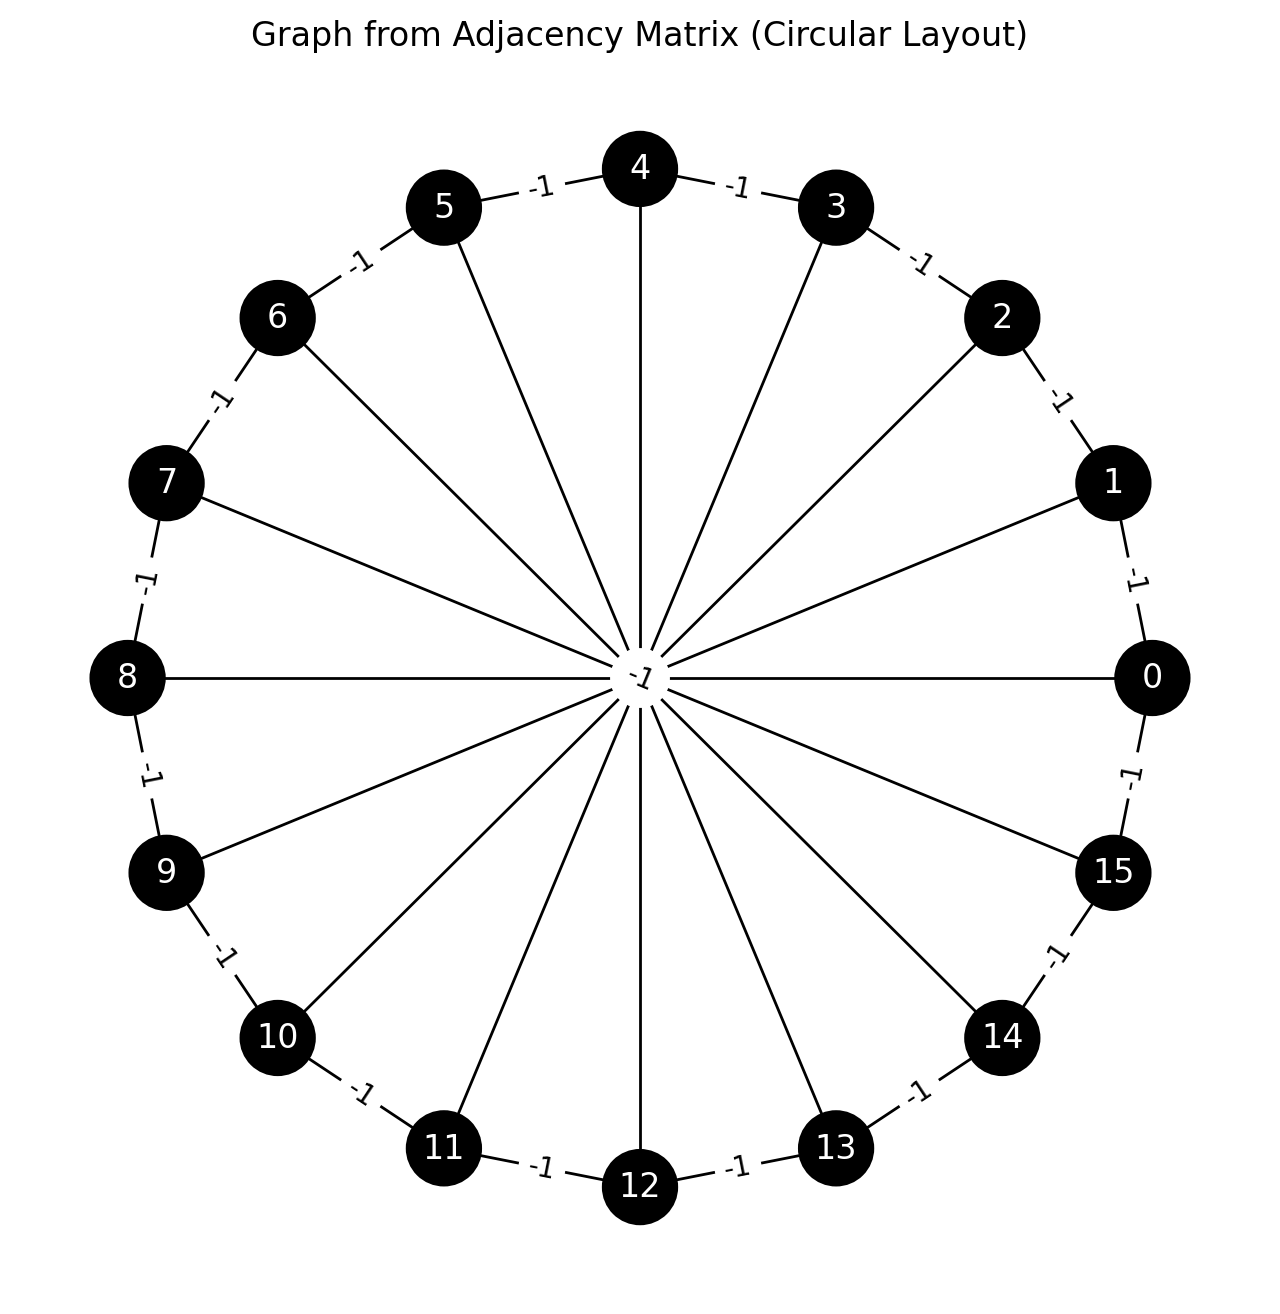

Final state of the machine: [-1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1.]
Final energy of the machine: -20.0
Final cut size: 22.0
Runtime of the function: 16.684602799999993 seconds


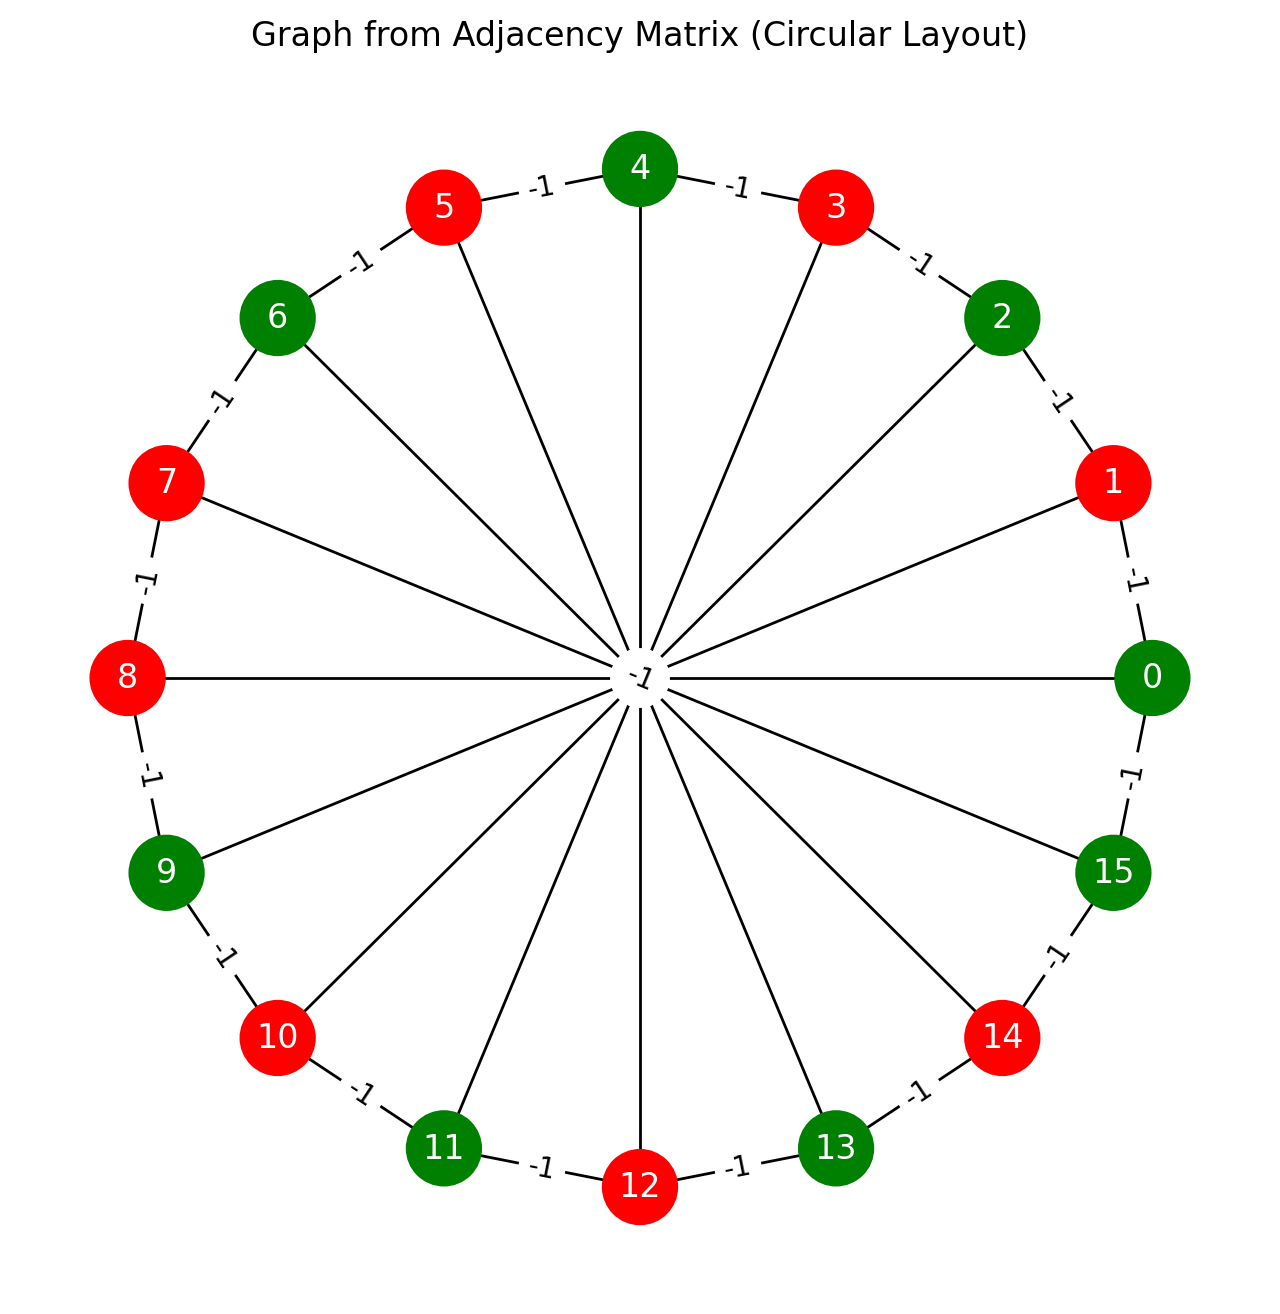

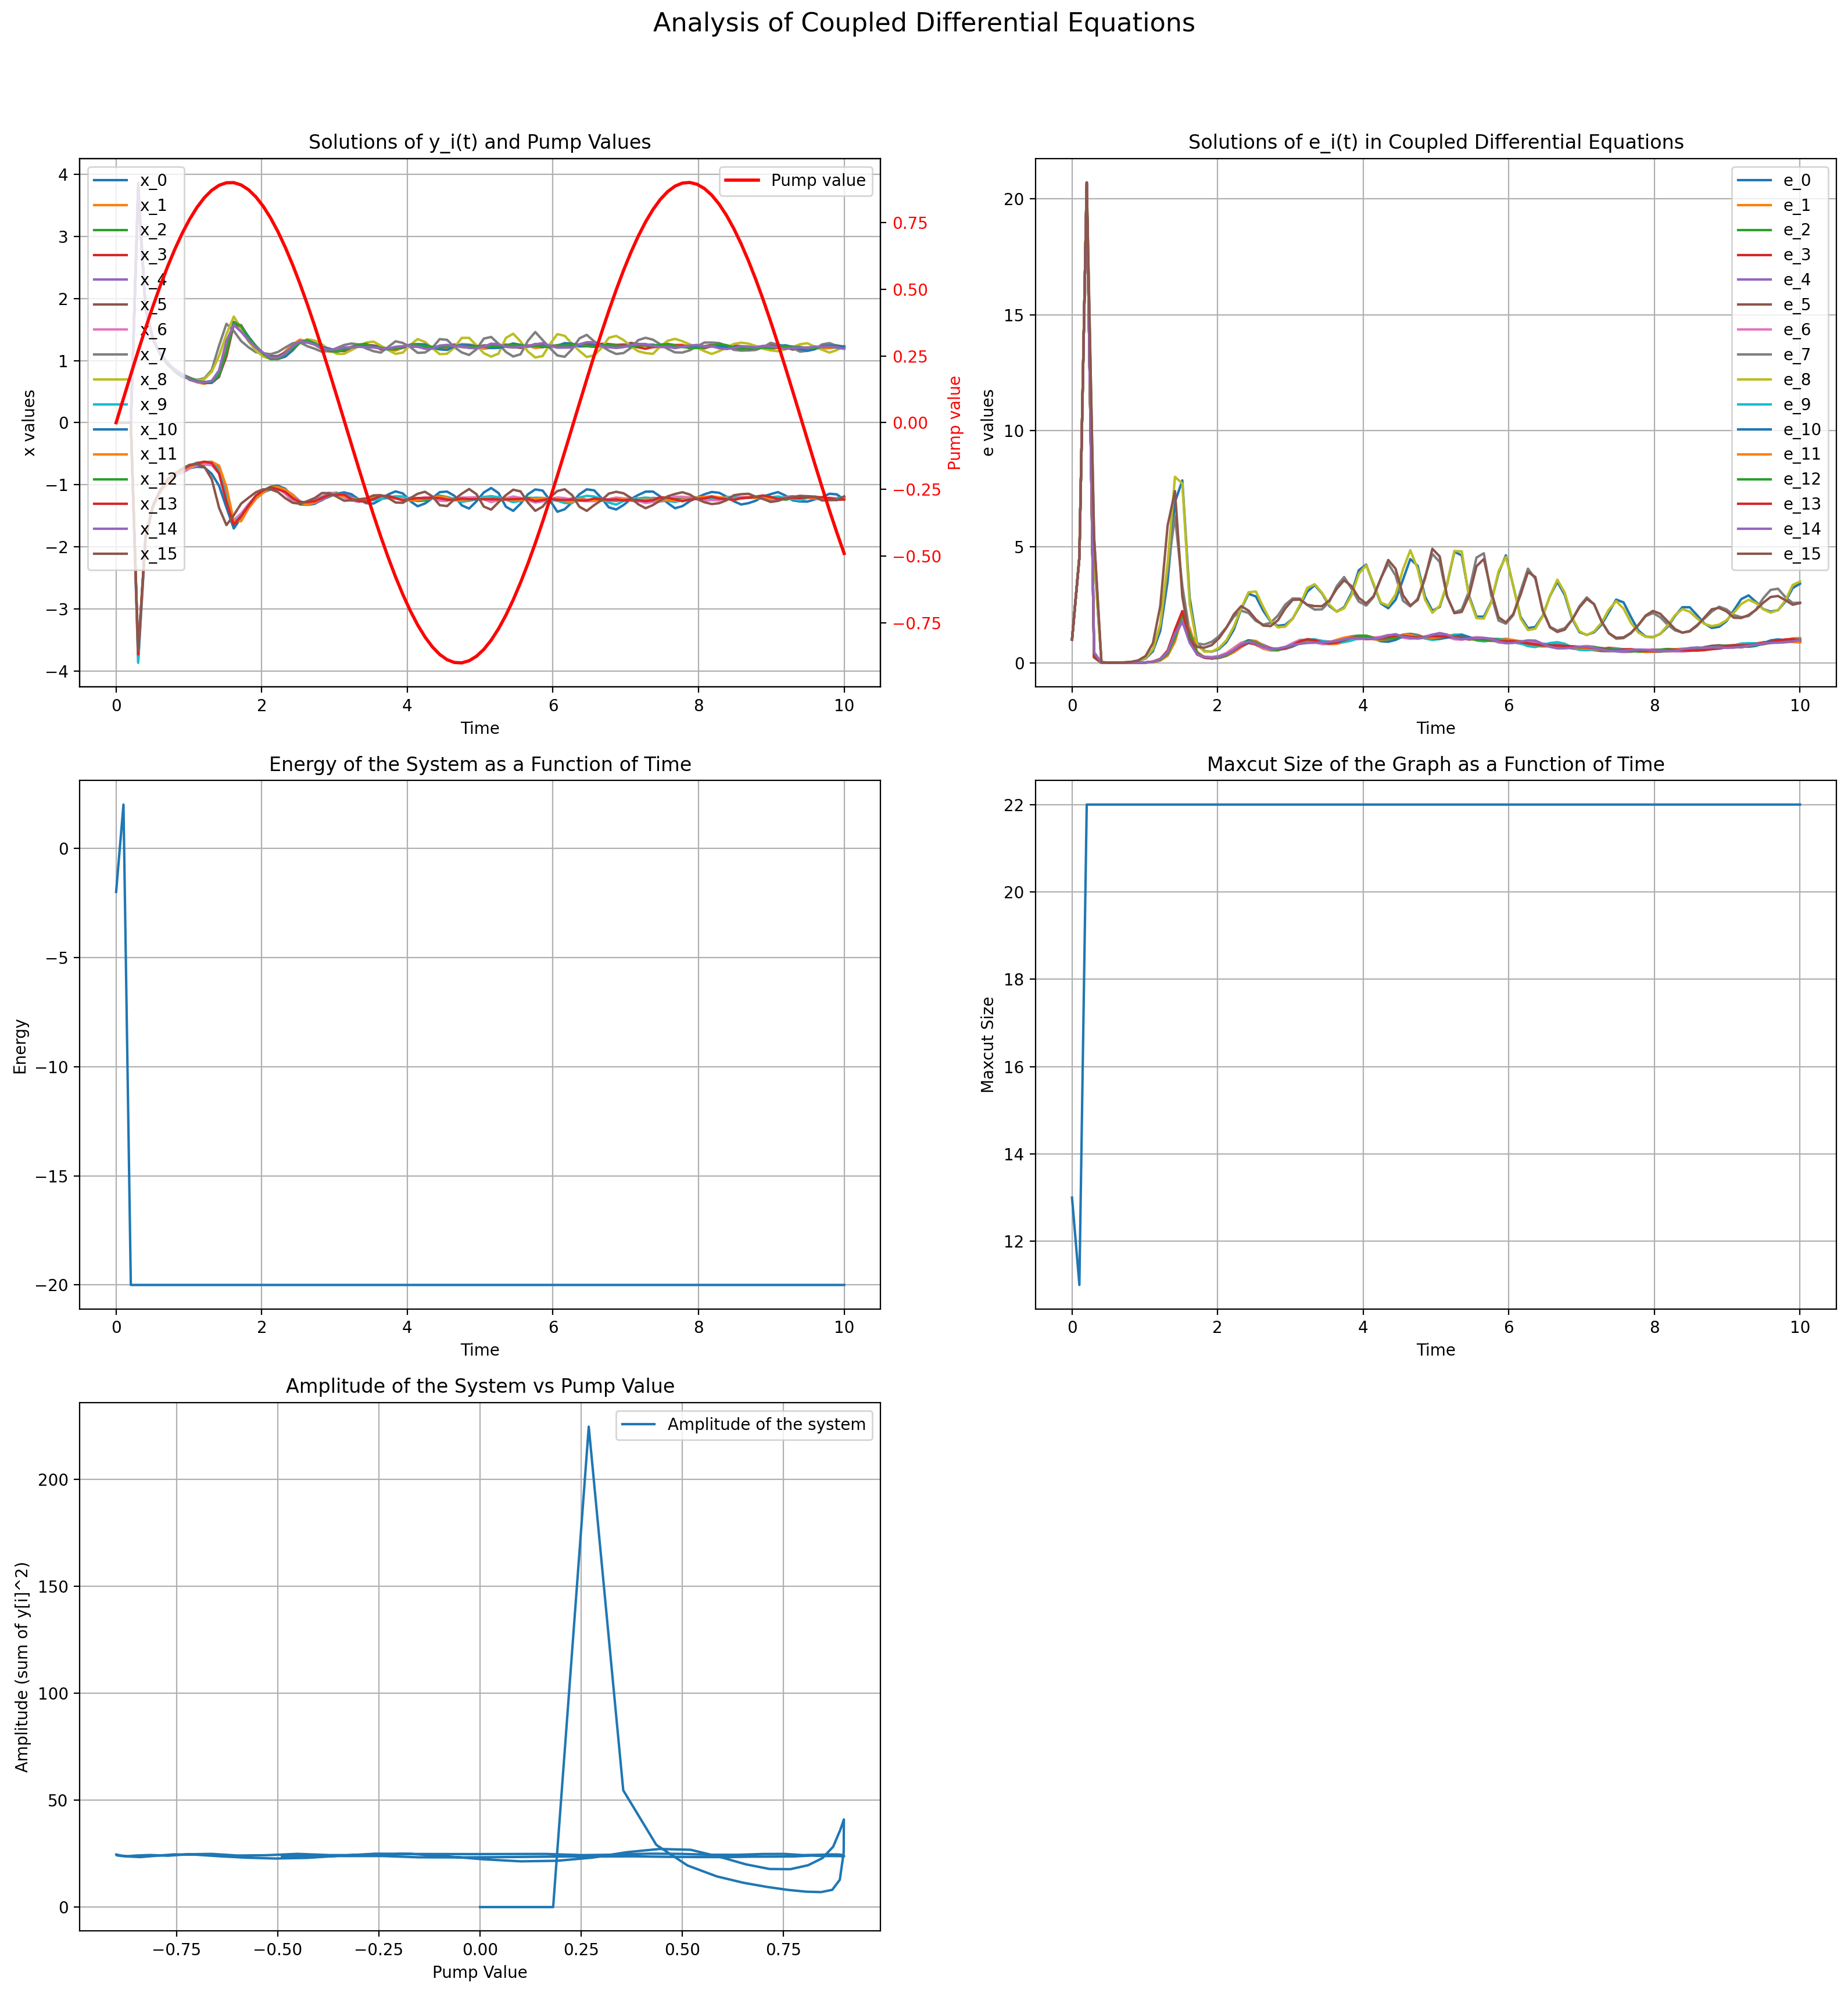

In [56]:
# Define parameters
alpha = 1.5  # Parameter alpha
beta = 10  # Parameter beta
p0 = 0.0  # Pump offset
p = 0.9  # Pump parameter
pump_type = 'sinusoidal'  # Default pump type

# Define the input function p(t)
def pump_function(t, args):
    pump_type = args['pump_type']
    rng = np.random.default_rng()
    if pump_type == 'linear':
        return p * t + p0
    elif pump_type == 'sqrt':
        return p * np.sqrt(t) + p0
    elif pump_type == 'sinusoidal':
        return p * np.sin(t) + p0
    elif pump_type == 'chaotic':
        random_values = rng.random(len(t))
        return p * random_values + p0
    else:
        raise ValueError(f"Unknown pump type: {pump_type}")

# Define the system of differential equations
def coupled_odes(t, y, J, h, N, pump_function, pump_type):
    x = y[:N]
    e = y[N:]
    dxdt = np.zeros(N)
    dedt = np.zeros(N)
    pump_value = pump_function(t, {'pump_type': pump_type})  # Get the pump value
    for i in range(N):
        noise = 0.5 * np.random.normal(0, 0.5)
        interaction_term = sum(J[i, j] * x[j] for j in range(N) if j != i) + h[i] / N * sum(np.abs(x[k]) for k in range(N))
        dxdt[i] = (pump_value - 1) * x[i] - x[i]**3 + e[i] * interaction_term + noise
        dedt[i] = -beta * e[i] * (x[i]**2 - alpha)
    return np.concatenate((dxdt, dedt))

# Implement Euler's method
def euler_method(odes_func, t_span, y0, t_eval, args):
    t0, tf = t_span
    dt = t_eval[1] - t_eval[0]
    t_values = np.arange(t0, tf + dt, dt)
    y_values = [y0]
    for t in t_values[:-1]:
        y_current = y_values[-1]
        y_next = y_current + dt * odes_func(t, y_current, *args)
        y_values.append(y_next)
    return t_values, np.array(y_values).T

# Implement RK4 method
def rk4_method(odes_func, t_span, y0, t_eval, args):
    t0, tf = t_span
    dt = t_eval[1] - t_eval[0]
    t_values = np.arange(t0, tf + dt, dt)
    y_values = [y0]
    for t in t_values[:-1]:
        y_current = y_values[-1]
        k1 = dt * odes_func(t, y_current, *args)
        k2 = dt * odes_func(t + dt / 2, y_current + k1 / 2, *args)
        k3 = dt * odes_func(t + dt / 2, y_current + k2 / 2, *args)
        k4 = dt * odes_func(t + dt, y_current + k3, *args)
        y_next = y_current + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        y_values.append(y_next)
    return t_values, np.array(y_values).T

# Define the solver wrapper
def solve_system(method, t_span, y0, t_eval, args):
    if method == 'Euler':
        t, y = euler_method(coupled_odes, t_span, y0, t_eval, args)
    elif method in ['RK45', 'RK23', 'DOP853']:
        sol = solve_ivp(coupled_odes, t_span, y0, method=method, t_eval=t_eval, args=args)
        t, y = sol.t, sol.y
    elif method == 'RK4':
        t, y = rk4_method(coupled_odes, t_span, y0, t_eval, args)
    else:
        raise ValueError(f"Unknown method: {method}")
    return t, y

def max_cut_size_from_ising(H, edge_weights):

    total_edge_weight = np.sum(edge_weights) / 2  # Total weight of the edges
    cut_size = (-total_edge_weight - H) / 2
    return cut_size

def plot_graph_from_adjacency_matrix(J, layout="circular", node_values=None):
    """
    Plots a graph from an adjacency matrix using NetworkX.

    Parameters:
        J (2D array-like): Adjacency matrix of the graph.
        layout (str): Layout for the graph ('circular', 'spring', 'random', 'spectral', 'planar').
        node_values (list): List of +1 or -1 for coloring nodes. Default is None (nodes are black).

    Returns:
        None: Displays the plot.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(J))

    # Assign node colors based on node_values
    if node_values is not None and len(node_values) > 0:
        node_colors = ['red' if value == +1 else 'green' for value in node_values]
    else:
        node_colors = ['black'] * len(G.nodes)  # Default black color for all nodes

    # Select the layout
    if layout == "spring":
        pos = nx.spring_layout(G)  # Spring layout for better visualization
    elif layout == "circular":
        pos = nx.circular_layout(G)  # Circular layout
    elif layout == "random":
        pos = nx.random_layout(G)  # Random layout
    elif layout == "spectral":
        pos = nx.spectral_layout(G)  # Spectral layout
    elif layout == "planar":
        try:
            pos = nx.planar_layout(G)  # Planar layout
        except nx.NetworkXException:
            raise ValueError("Planar layout only works for planar graphs.")
    else:
        raise ValueError("Invalid layout. Choose 'circular', 'spring', 'random', 'spectral', or 'planar'.")

    # Plot the graph
    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='white')
    # Add edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(f"Graph from Adjacency Matrix ({layout.capitalize()} Layout)")
    plt.axis('off')  # Turn off the axis
    plt.show()

# Example usage
if __name__ == '__main__':
    # Define problem parameters
#     N = 16
#     J = np.random.rand(N, N) * 0.5  # Random coupling matrix
#     np.fill_diagonal(J, 0)
#     h = np.random.rand(N)  # Random external field


    # Call the function without node values (default black nodes)
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=[])

    # Initial conditions
    x0 = np.zeros(N) + 0.0001 * (2 * np.random.rand(N) - 1)
    e0 = np.ones(N)
    y0 = np.concatenate((x0, e0))  # Combine initial conditions

    # Time span and evaluation points
    t_span = (0, 10)
    t_eval = np.linspace(*t_span, 100)

    # Measure runtime
    start_time = timeit.default_timer()

    # Solve the system
    args = (J, h, N, pump_function, pump_type)
    method = 'RK45'
    t, y = solve_system(method, t_span, y0, t_eval, args)

    # End runtime measurement
    end_time = timeit.default_timer()

    # Calculate energy
    H = np.zeros(len(t))
    for i in range(len(t)):
        H[i] = -0.5 * np.sign(y[0:N, i].T) @ J @ np.sign(y[0:N, i]) - h @ np.sign(y[0:N, i])

    # Final state and energy
    sol_f = np.sign(y[0:N, -1])
    print('Final state of the machine:', sol_f)
    print('Final energy of the machine:', H[-1])
    print('Final cut size:',max_cut_size_from_ising(H[-1],J))
    print("Runtime of the function:", end_time - start_time, "seconds")

    # Calculating Amplitude of the system
    amplitudes = np.sum(y[0:N]**2, axis=0)  # Sum of y[i]^2 at each time step
    pump_values = pump_function(t,args={'pump_type': pump_type})  # Pump values corresponding to each time step

     # Call the function with node colors
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=np.array(sol_f))

    # Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 18))  # 3x2 grid of subplots
fig.suptitle('Solution of AHC equations for CIMs', fontsize=16)

# Plot 1: Solutions of y[i] and Pump Values
ax1 = axs[0, 0]
for i in range(N):
    ax1.plot(t, y[i], label=f'x_{i}')
ax1.set_xlabel('Time')
ax1.set_ylabel('x values')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1_secondary = ax1.twinx()
ax1_secondary.plot(t, pump_values, color='red', label='Pump value', linewidth=2)
ax1_secondary.set_ylabel('Pump value', color='red')
ax1_secondary.tick_params(axis='y', labelcolor='red')
ax1_secondary.legend(loc='upper right')
ax1.set_title('Solutions of y_i(t) and Pump Values')

# Plot 2: Solutions of e[i]
ax2 = axs[0, 1]
for i in range(N, 2 * N):
    ax2.plot(t, y[i], label=f'e_{i - N}')
ax2.set_xlabel('Time')
ax2.set_ylabel('e values')
ax2.legend()
ax2.grid(True)
ax2.set_title('Solutions of e_i(t) in Coupled Differential Equations')

# Plot 3: Energy of the System
ax3 = axs[1, 0]
ax3.plot(t, H)
ax3.set_xlabel('Time')
ax3.set_ylabel('Energy')
ax3.grid(True)
ax3.set_title('Energy of the System as a Function of Time')

# Plot 4: Max-cut Size
ax4 = axs[1, 1]
ax4.plot(t, max_cut_size_from_ising(H, J))
ax4.set_xlabel('Time')
ax4.set_ylabel('Maxcut Size')
ax4.grid(True)
ax4.set_title('Maxcut Size of the Graph as a Function of Time')

# Plot 5: Amplitude vs Pump Value
ax5 = axs[2, 0]
ax5.plot(pump_values, amplitudes, label='Amplitude of the system')
ax5.set_xlabel('Pump Value')
ax5.set_ylabel('Amplitude (sum of y[i]^2)')
ax5.legend()
ax5.grid(True)
ax5.set_title('Amplitude of the System vs Pump Value')

# Hide the empty subplot (if any)
axs[2, 1].axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()


# Chaotic Amplitude Control (CAC)

Chaotic Amplitude Control (CAC) is a nonrelaxational mean-field method that improves upon standard relaxation dynamics in Coherent Ising Machines (CIMs). It enhances the exploration of the solution space by introducing error signals that destabilize local minima, resulting in chaotic dynamics capable of escaping suboptimal configurations. The system is described by the following coupled equations [6]:

$$
f_i(t) = e_i(t) \sum_j J_{ij} x_j(t), \\
\frac{d x_i(t)}{d t} = (p-1) x_i(t) - x_i(t)^3 - f_i(t), \\
\frac{d e_i(t)}{d t} = -\beta e_i(t)\left(f_i(t)^2 - \alpha\right),
$$

where $x_i(t)$ is the amplitude of the $i$-th oscillator, $e_i(t)$ represents the error signal, $f_i(t)$ is the feedback term based on the coupling matrix $J_{ij}$, $p$ is the gain parameter driving the system, $\beta$ controls the rate of the error dynamics, and $\alpha$ is the target amplitude. The feedback signal $f_i(t)$ reflects the influence of neighboring oscillators and their coupling strengths $J_{ij}$.

This formulation enables the system to escape local minima and saddle points efficiently, leveraging the additional dimensions provided by $e_i(t)$. Unlike relaxational methods, CAC dynamically destabilizes local minima, driving the system toward near-optimal solutions.


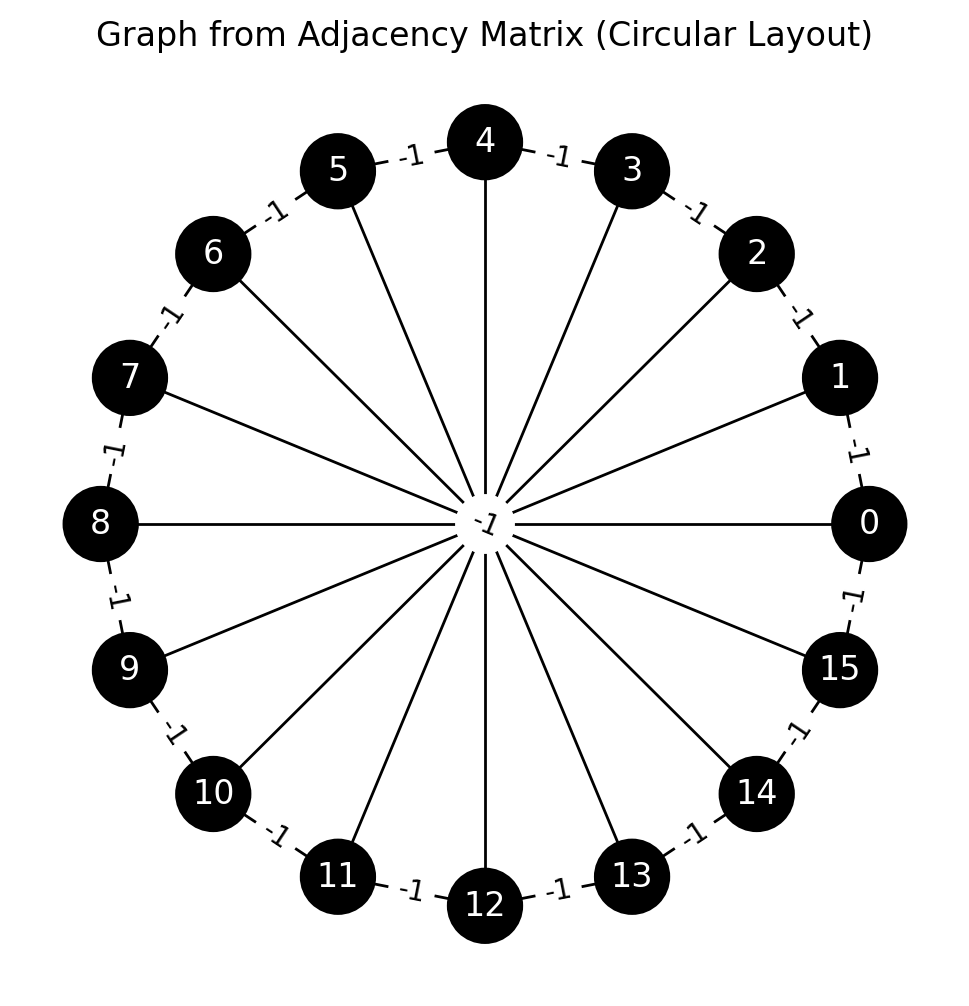

Final state of the machine: [-1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1.]
Final energy of the machine: -20.0
Final cut size: 22.0
Runtime of the function: 15.365624797999772 seconds


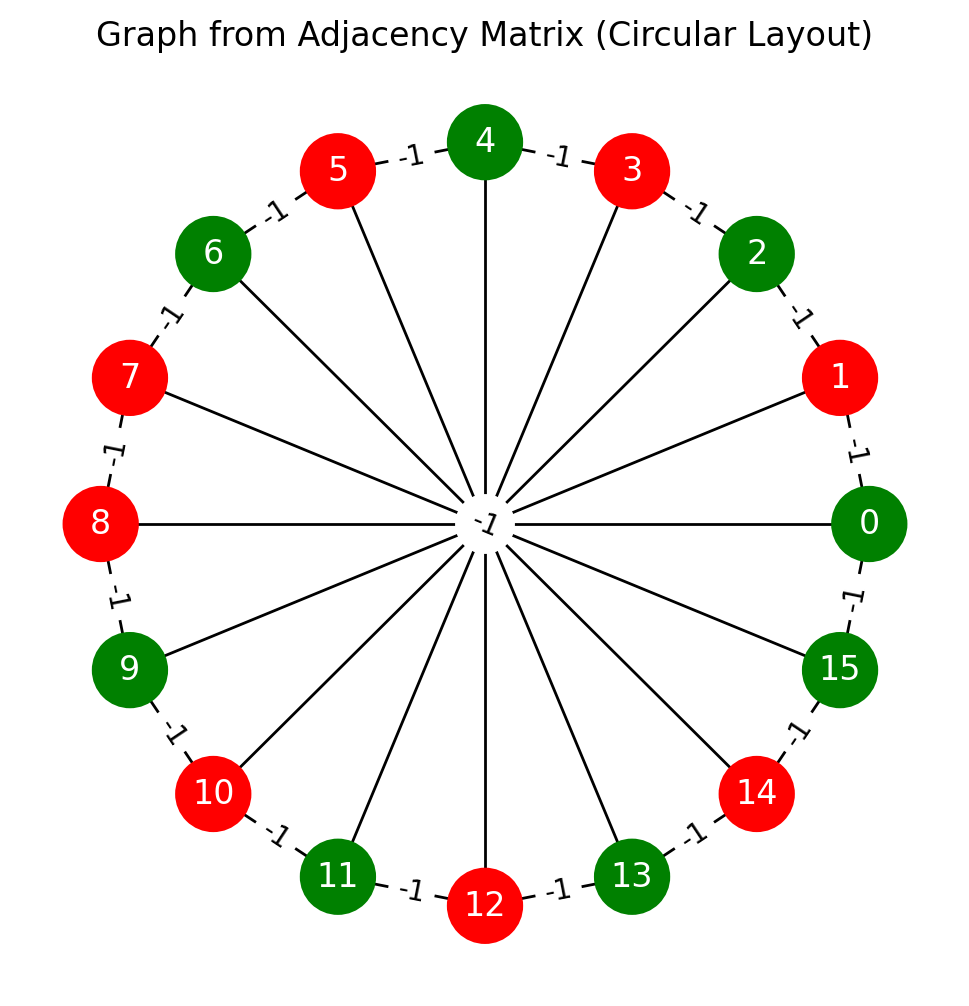

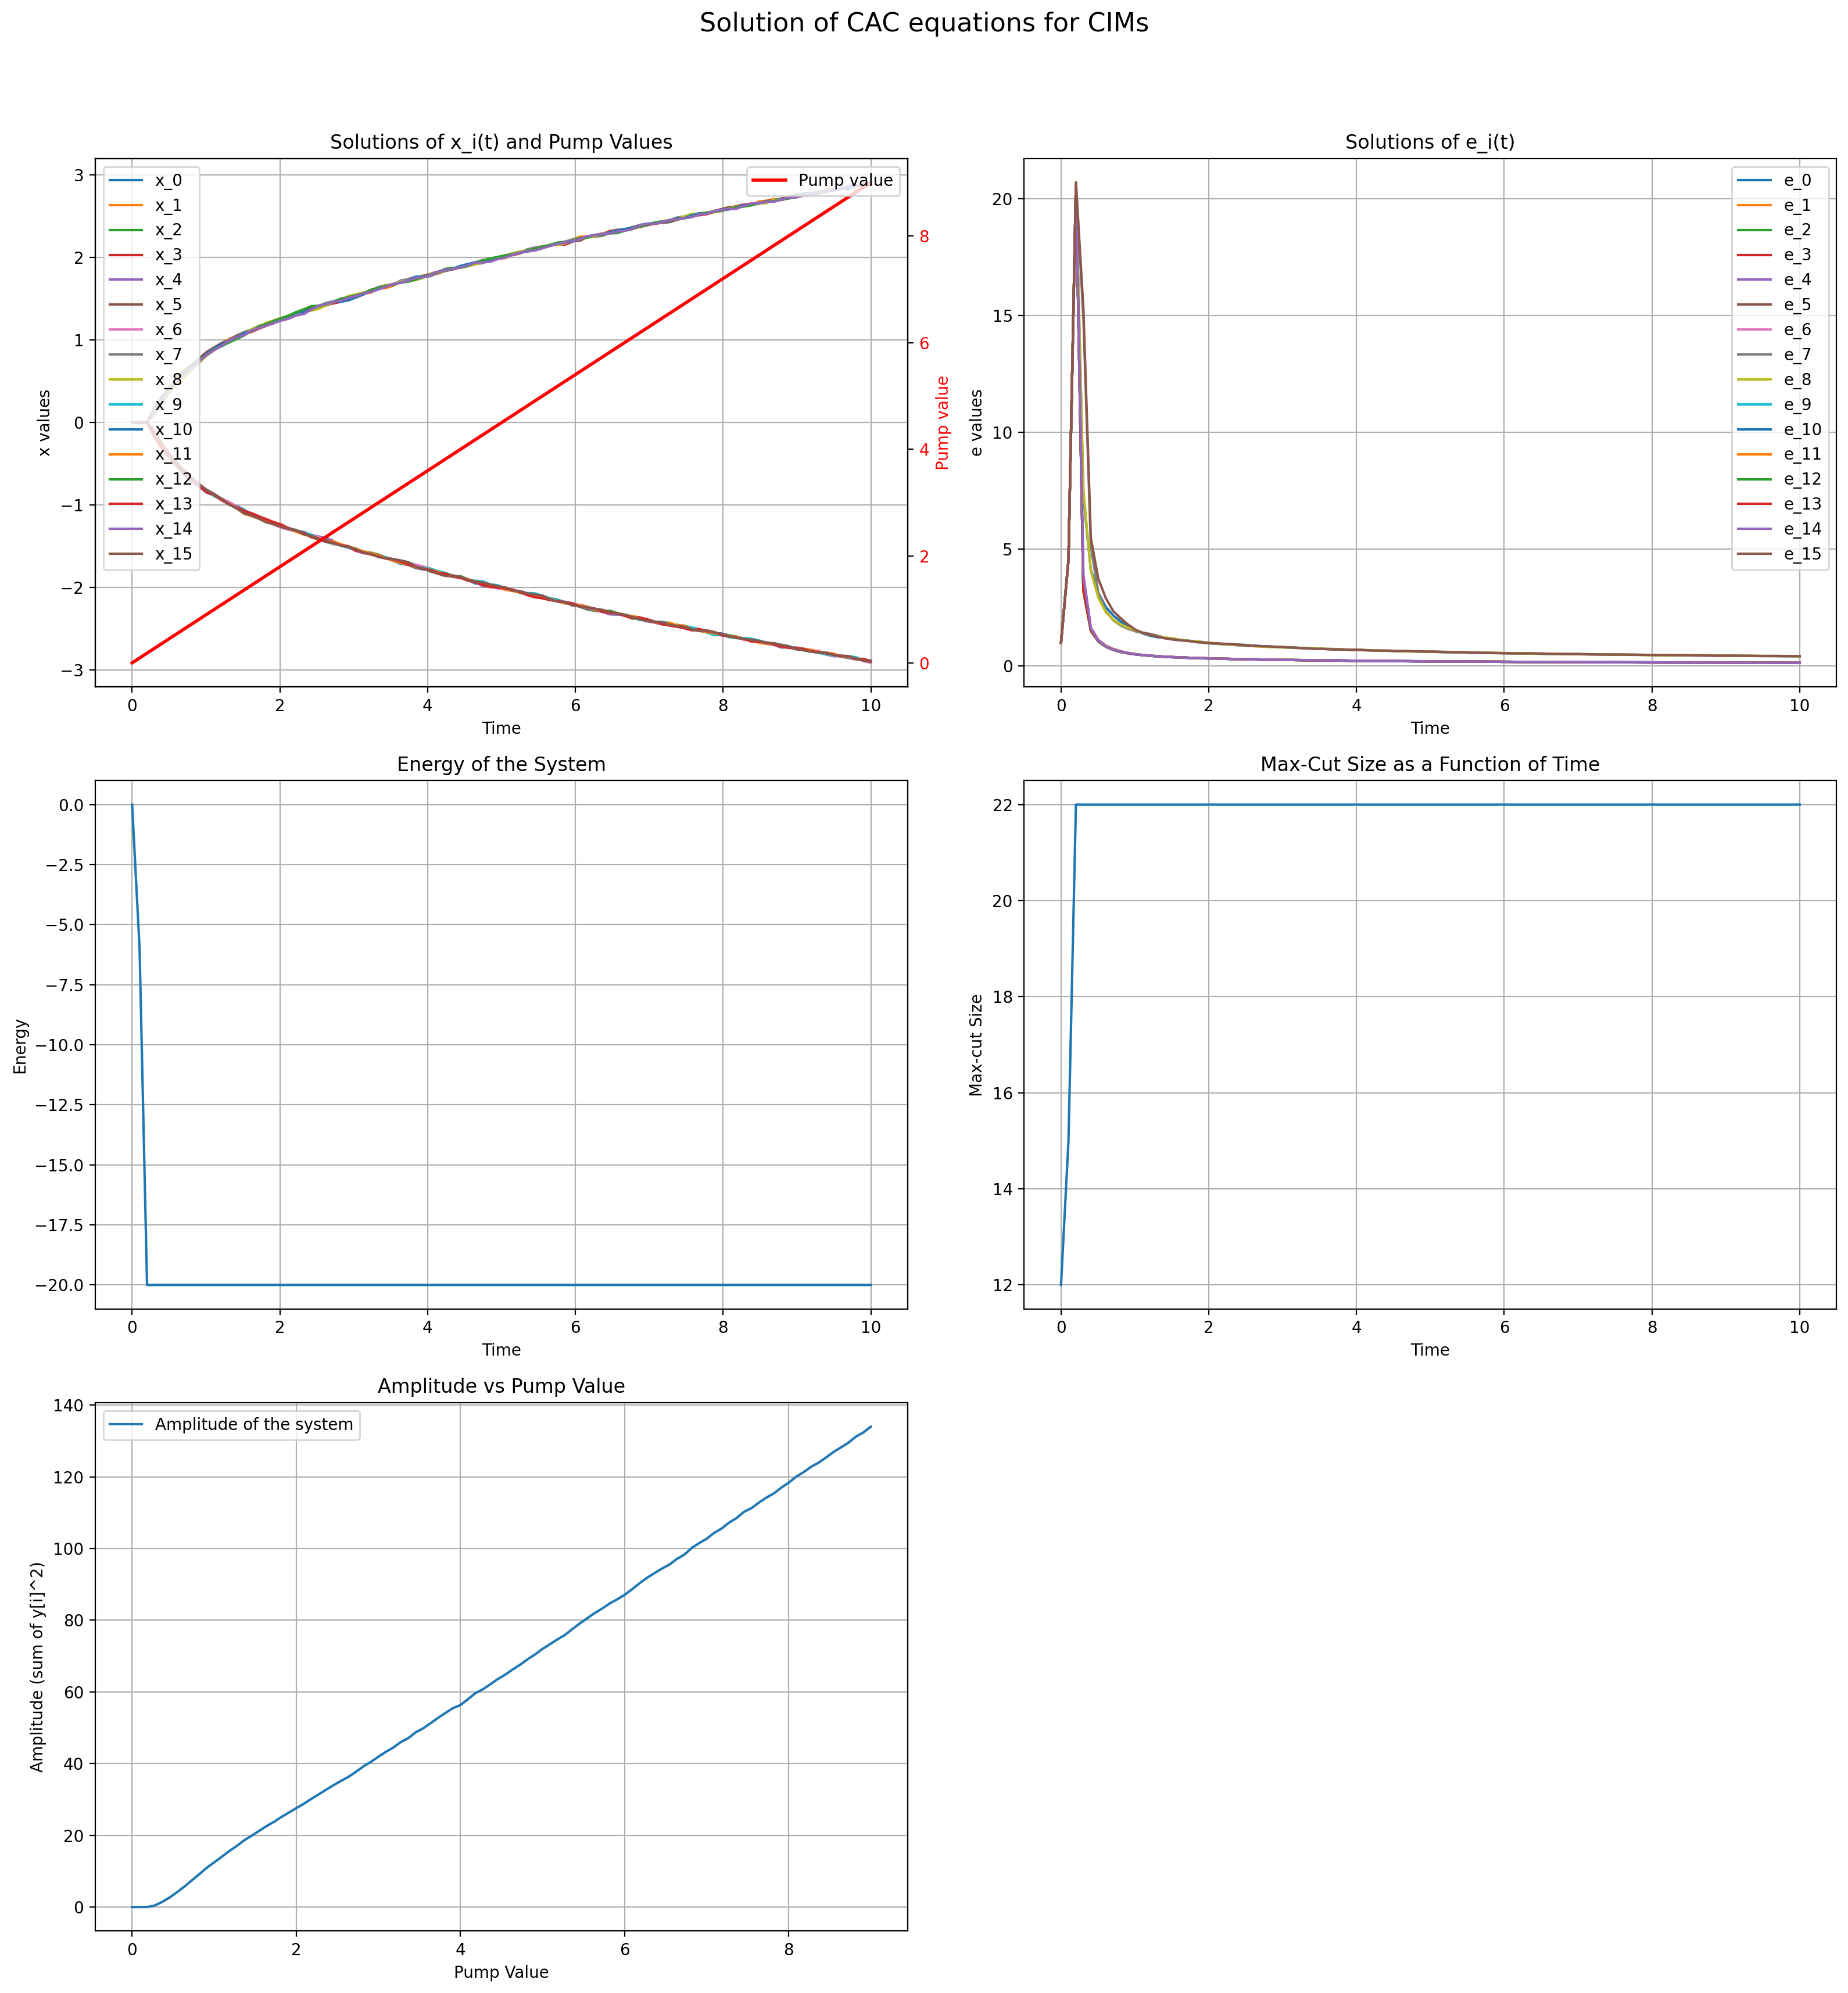

In [58]:
# Define parameters
alpha = 1.5  # Parameter alpha
beta = 10  # Parameter beta
p0 = 0.0  # Pump offset
p = 0.9  # Pump parameter
pump_type = 'linear'  # Default pump type

# Define the input function p(t)
def pump_function(t, args):
    pump_type = args['pump_type']
    rng = np.random.default_rng()
    if pump_type == 'linear':
        return p * t + p0
    elif pump_type == 'sqrt':
        return p * np.sqrt(t) + p0
    elif pump_type == 'sinusoidal':
        return p * np.sin(t) + p0
    elif pump_type == 'chaotic':
        random_values = rng.random(len(t))
        return p * random_values + p0
    else:
        raise ValueError(f"Unknown pump type: {pump_type}")

# Define the system of differential equations
def coupled_odes(t, y, J, h, N, pump_function, pump_type):
    x = y[:N]
    e = y[N:]
    dxdt = np.zeros(N)
    dedt = np.zeros(N)
    pump_value = pump_function(t, {'pump_type': pump_type})  # Get the pump value
    # Calculate f_i for each i
    f = np.zeros(N)
    for i in range(N):
        f[i] = e[i] * (sum(J[i, j] * x[j] for j in range(N))+h[i]/N*sum(np.abs(x[k]) for k in range(N)))

    # Calculate dxdt and dedt based on f_i
    for i in range(N):
        noise = 0.5*np.random.normal(0,0.5)
        dxdt[i] = (pump_value - 1) * x[i] - x[i]**3 + f[i]+noise
        dedt[i] = -beta * e[i] * (f[i]**2 - alpha)

    return np.concatenate((dxdt, dedt))

# Implement Euler's method
def euler_method(odes_func, t_span, y0, t_eval, args):
    t0, tf = t_span
    dt = t_eval[1] - t_eval[0]
    t_values = np.arange(t0, tf + dt, dt)
    y_values = [y0]
    for t in t_values[:-1]:
        y_current = y_values[-1]
        y_next = y_current + dt * odes_func(t, y_current, *args)
        y_values.append(y_next)
    return t_values, np.array(y_values).T

# Implement RK4 method
def rk4_method(odes_func, t_span, y0, t_eval, args):
    t0, tf = t_span
    dt = t_eval[1] - t_eval[0]
    t_values = np.arange(t0, tf + dt, dt)
    y_values = [y0]
    for t in t_values[:-1]:
        y_current = y_values[-1]
        k1 = dt * odes_func(t, y_current, *args)
        k2 = dt * odes_func(t + dt / 2, y_current + k1 / 2, *args)
        k3 = dt * odes_func(t + dt / 2, y_current + k2 / 2, *args)
        k4 = dt * odes_func(t + dt, y_current + k3, *args)
        y_next = y_current + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        y_values.append(y_next)
    return t_values, np.array(y_values).T

# Define the solver wrapper
def solve_system(method, t_span, y0, t_eval, args):
    if method == 'Euler':
        t, y = euler_method(coupled_odes, t_span, y0, t_eval, args)
    elif method in ['RK45', 'RK23', 'DOP853']:
        sol = solve_ivp(coupled_odes, t_span, y0, method=method, t_eval=t_eval, args=args)
        t, y = sol.t, sol.y
    elif method == 'RK4':
        t, y = rk4_method(coupled_odes, t_span, y0, t_eval, args)
    else:
        raise ValueError(f"Unknown method: {method}")
    return t, y

def max_cut_size_from_ising(H, edge_weights):

    total_edge_weight = np.sum(edge_weights) / 2  # Total weight of the edges
    cut_size = (-total_edge_weight - H) / 2
    return cut_size

def plot_graph_from_adjacency_matrix(J, layout="circular", node_values=None):
    """
    Plots a graph from an adjacency matrix using NetworkX.

    Parameters:
        J (2D array-like): Adjacency matrix of the graph.
        layout (str): Layout for the graph ('circular', 'spring', 'random', 'spectral', 'planar').
        node_values (list): List of +1 or -1 for coloring nodes. Default is None (nodes are black).

    Returns:
        None: Displays the plot.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(J))

    # Assign node colors based on node_values
    if node_values is not None and len(node_values) > 0:
        node_colors = ['red' if value == +1 else 'green' for value in node_values]
    else:
        node_colors = ['black'] * len(G.nodes)  # Default black color for all nodes

    # Select the layout
    if layout == "spring":
        pos = nx.spring_layout(G)  # Spring layout for better visualization
    elif layout == "circular":
        pos = nx.circular_layout(G)  # Circular layout
    elif layout == "random":
        pos = nx.random_layout(G)  # Random layout
    elif layout == "spectral":
        pos = nx.spectral_layout(G)  # Spectral layout
    elif layout == "planar":
        try:
            pos = nx.planar_layout(G)  # Planar layout
        except nx.NetworkXException:
            raise ValueError("Planar layout only works for planar graphs.")
    else:
        raise ValueError("Invalid layout. Choose 'circular', 'spring', 'random', 'spectral', or 'planar'.")

    # Plot the graph
    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='white')
    # Add edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(f"Graph from Adjacency Matrix ({layout.capitalize()} Layout)")
    plt.axis('off')  # Turn off the axis
    plt.show()

# Example usage
if __name__ == '__main__':
    # Define problem parameters
#     N = 16
#     J = np.random.rand(N, N) * 0.5  # Random coupling matrix
#     np.fill_diagonal(J, 0)
#     h = np.random.rand(N)  # Random external field


    # Call the function without node values (default black nodes)
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=[])

    # Initial conditions
    x0 = np.zeros(N) + 0.0001 * (2 * np.random.rand(N) - 1)
    e0 = np.ones(N)
    y0 = np.concatenate((x0, e0))  # Combine initial conditions

    # Time span and evaluation points
    t_span = (0, 10)
    t_eval = np.linspace(*t_span, 100)

    # Measure runtime
    start_time = timeit.default_timer()

    # Solve the system
    args = (J, h, N, pump_function, pump_type)
    method = 'RK45'
    t, y = solve_system(method, t_span, y0, t_eval, args)

    # End runtime measurement
    end_time = timeit.default_timer()

    # Calculate energy
    H = np.zeros(len(t))
    for i in range(len(t)):
        H[i] = -0.5 * np.sign(y[0:N, i].T) @ J @ np.sign(y[0:N, i]) - h @ np.sign(y[0:N, i])

    # Final state and energy
    sol_f = np.sign(y[0:N, -1])
    print('Final state of the machine:', sol_f)
    print('Final energy of the machine:', H[-1])
    print('Final cut size:',max_cut_size_from_ising(H[-1],J))
    print("Runtime of the function:", end_time - start_time, "seconds")

    # Calculating Amplitude of the system
    amplitudes = np.sum(y[0:N]**2, axis=0)  # Sum of y[i]^2 at each time step
    pump_values = pump_function(t,args={'pump_type': pump_type})  # Pump values corresponding to each time step

     # Call the function with node colors
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=np.array(sol_f))


    # Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 18))  # 3x2 grid of subplots
fig.suptitle('Solution of CAC equations for CIMs', fontsize=16)

# Plot 1: y[i] solutions with pump values (secondary axis)
ax1 = axs[0, 0]
for i in range(N):
    ax1.plot(t, y[i], label=f'x_{i}')
ax1.set_xlabel('Time')
ax1.set_ylabel('x values')
ax1.grid(True)
ax1.legend(loc='upper left')
ax1_secondary = ax1.twinx()
ax1_secondary.plot(t, pump_values, color='red', label='Pump value', linewidth=2)
ax1_secondary.set_ylabel('Pump value', color='red')
ax1_secondary.tick_params(axis='y', labelcolor='red')
ax1_secondary.legend(loc='upper right')
ax1.set_title('Solutions of x_i(t) and Pump Values')

# Plot 2: e[i] solutions
ax2 = axs[0, 1]
for i in range(N, 2 * N):
    ax2.plot(t, y[i], label=f'e_{i - N}')
ax2.set_xlabel('Time')
ax2.set_ylabel('e values')
ax2.legend()
ax2.grid(True)
ax2.set_title('Solutions of e_i(t)')

# Plot 3: Energy of the system
ax3 = axs[1, 0]
ax3.plot(t, H)
ax3.set_xlabel('Time')
ax3.set_ylabel('Energy')
ax3.grid(True)
ax3.set_title('Energy of the System')

# Plot 4: Max-cut size
ax4 = axs[1, 1]
ax4.plot(t, max_cut_size_from_ising(H, J))
ax4.set_xlabel('Time')
ax4.set_ylabel('Max-cut Size')
ax4.grid(True)
ax4.set_title('Max-Cut Size as a Function of Time')

# Plot 5: Amplitude vs Pump Value
ax5 = axs[2, 0]
ax5.plot(pump_values, amplitudes, label='Amplitude of the system')
ax5.set_xlabel('Pump Value')
ax5.set_ylabel('Amplitude (sum of y[i]^2)')
ax5.legend()
ax5.grid(True)
ax5.set_title('Amplitude vs Pump Value')

# Hide the empty subplot
axs[2, 1].axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()

# c-number Solution

The c-number model is a semiclassical approach used to solve CIMs, derived from the truncated Wigner function theory for quantum CIMs. The c-number model approximates operators as complex numbers, describing the dynamics of the in-phase and quadrature components of each DOPO pulse as follows [4]:
$$
\begin{gathered}
\frac{d c_i}{d t} = \left(p - 1 - \left(c_i^2 + s_i^2\right)\right) c_i + \eta \sum_{j=1}^N J_{ij} c_j + g^2 \sqrt{\left(c_i^2 + s_i^2\right) + \frac{1}{2}} W_c, \\
\frac{d s_i}{d t} = \left(-p - 1 - \left(c_i^2 + s_i^2\right)\right) s_i + g^2 \sqrt{\left(c_i^2 + s_i^2\right) + \frac{1}{2}} W_s.
\end{gathered}
$$
Here, $c_i$ and $s_i$ are the normalized c-number amplitudes of the in-phase and quadrature components, $p$ is the normalized pumping rate, and $\eta$ is a constant representing the coupling strength. On the right-hand side of the first equation, the first term represents the pump gain, the second represents linear loss, and the third represents the saturation of parametric gain for degenerate two-photon absorption. The fourth term represents the feedback injection term utilized to achieve mutual coupling between spins. The fifth term accounts for relevant quantum noise, where $g^2$ is the saturation parameter corresponding to the inverse photon number at twice the threshold pump rate of a solitary DOPO, and $W_{c, s}$ are Gaussian white noise terms with a mean of $\langle W_{c, s}(t) \rangle = 0$ and a variance of $\langle W_{c, s}(t) W_{c, s}(t') \rangle = \delta(t - t')$.


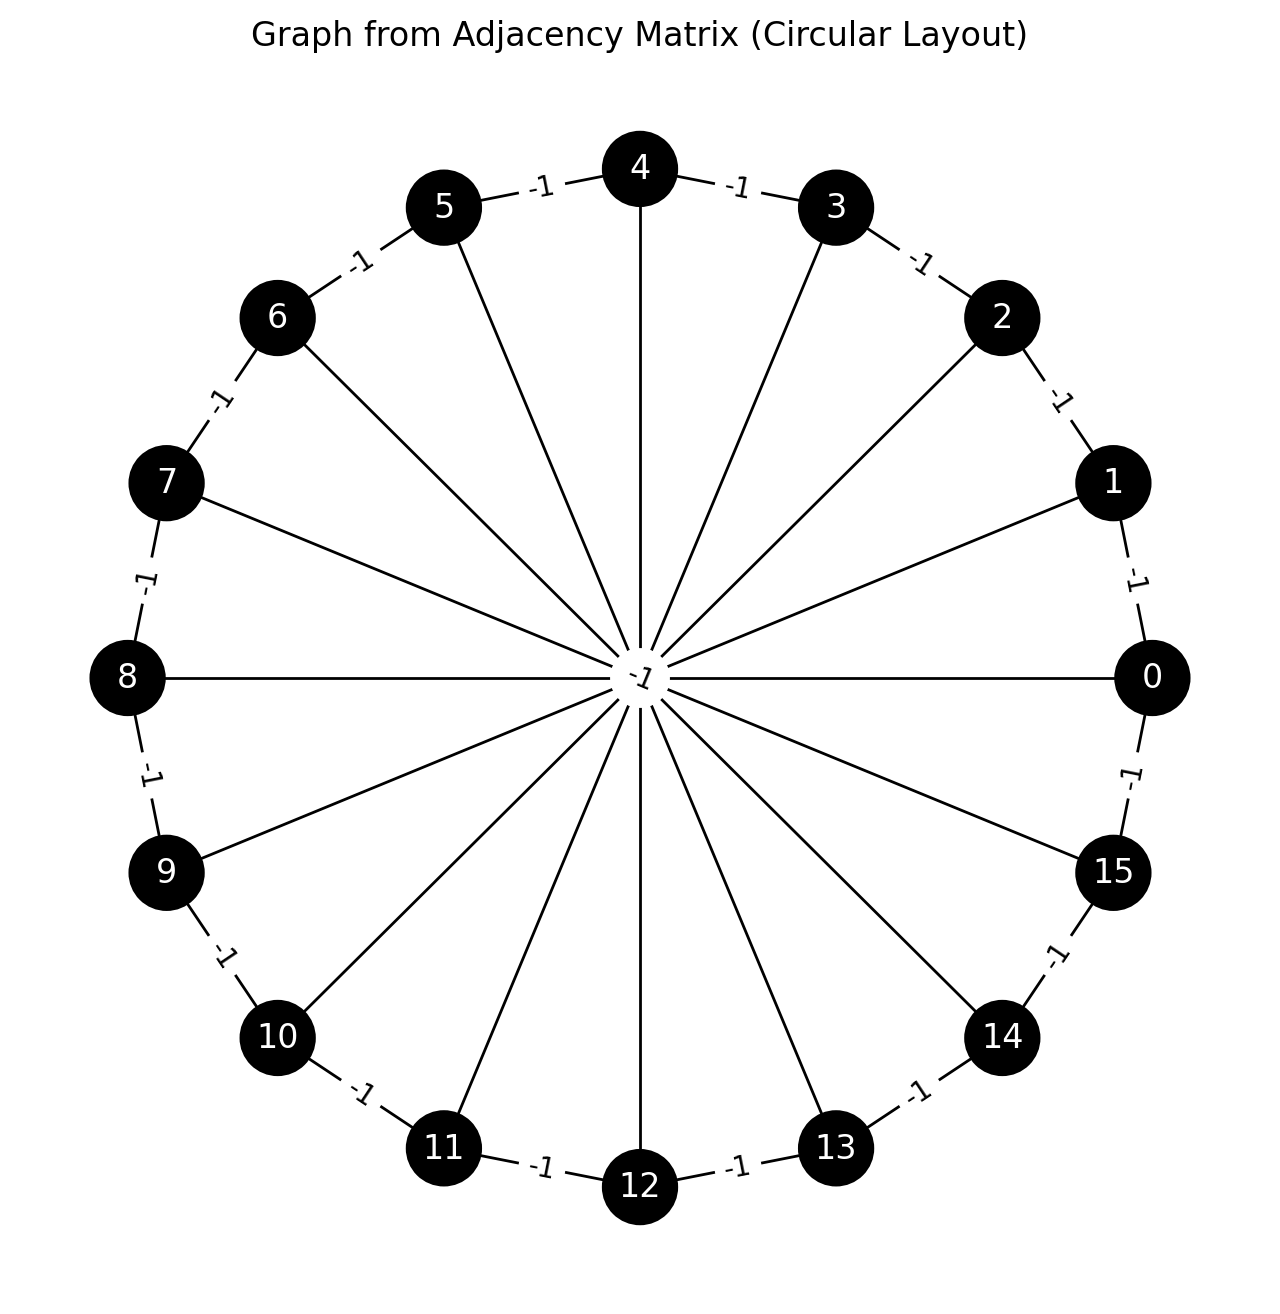

Final state of the machine: [-1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.]
Final energy of the machine: -20.0
Final cut size: 22.0
Runtime of the function: 83.20105715800128 seconds


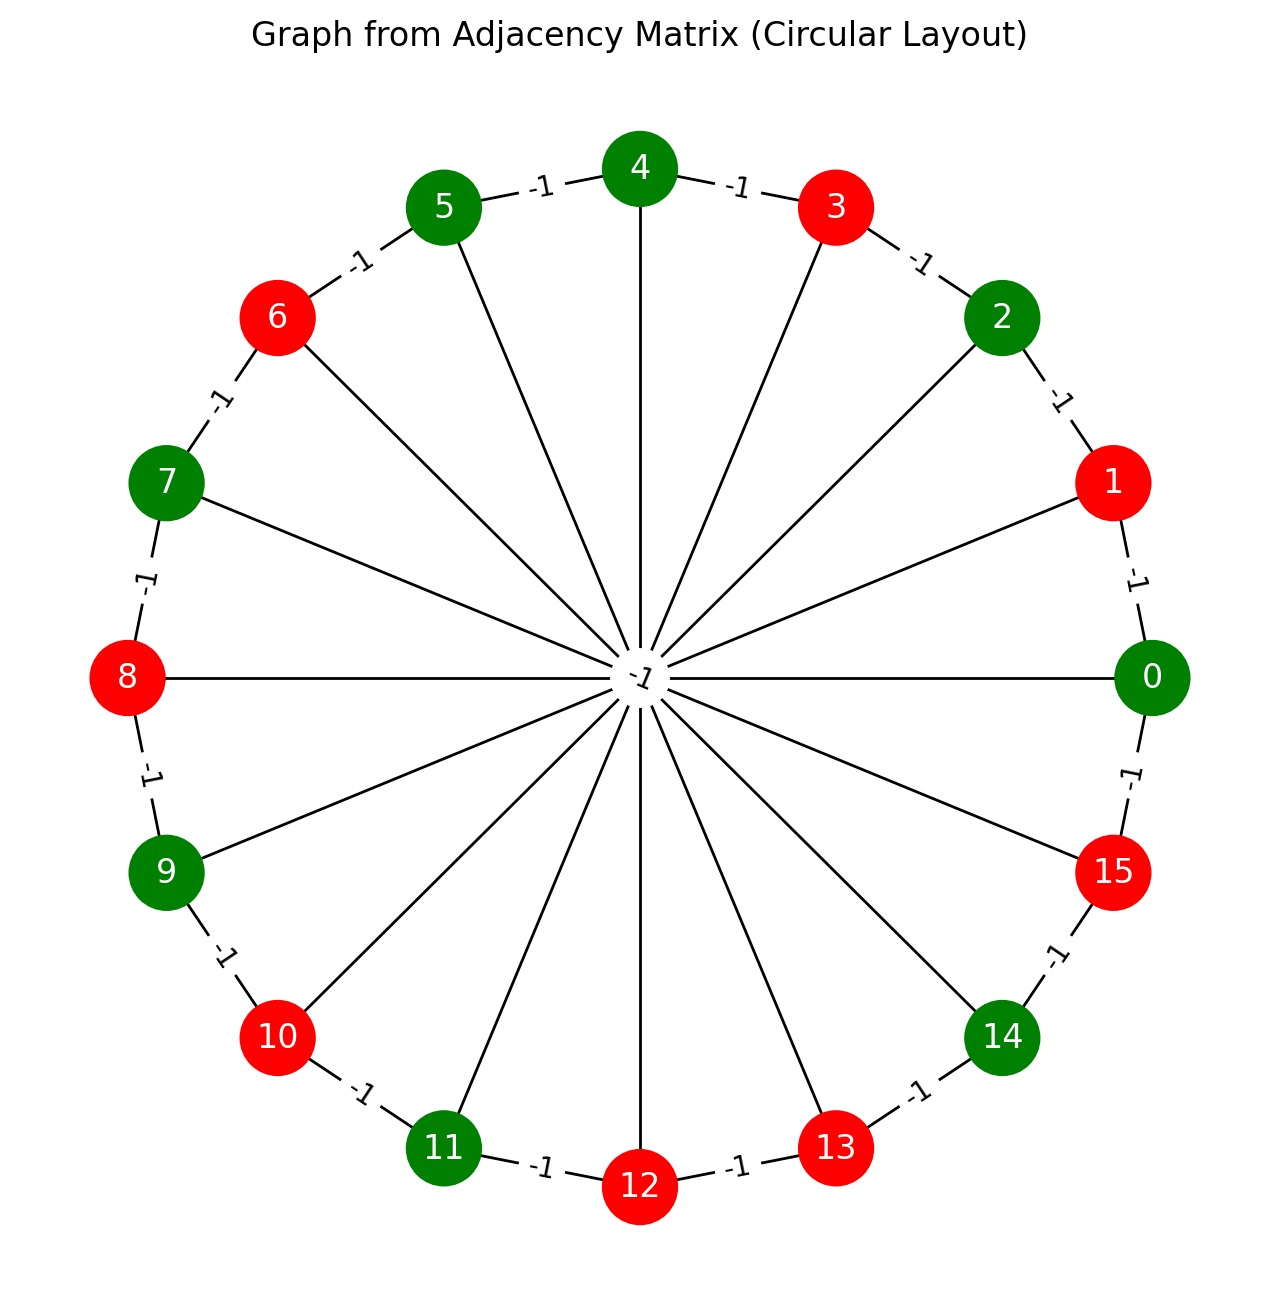

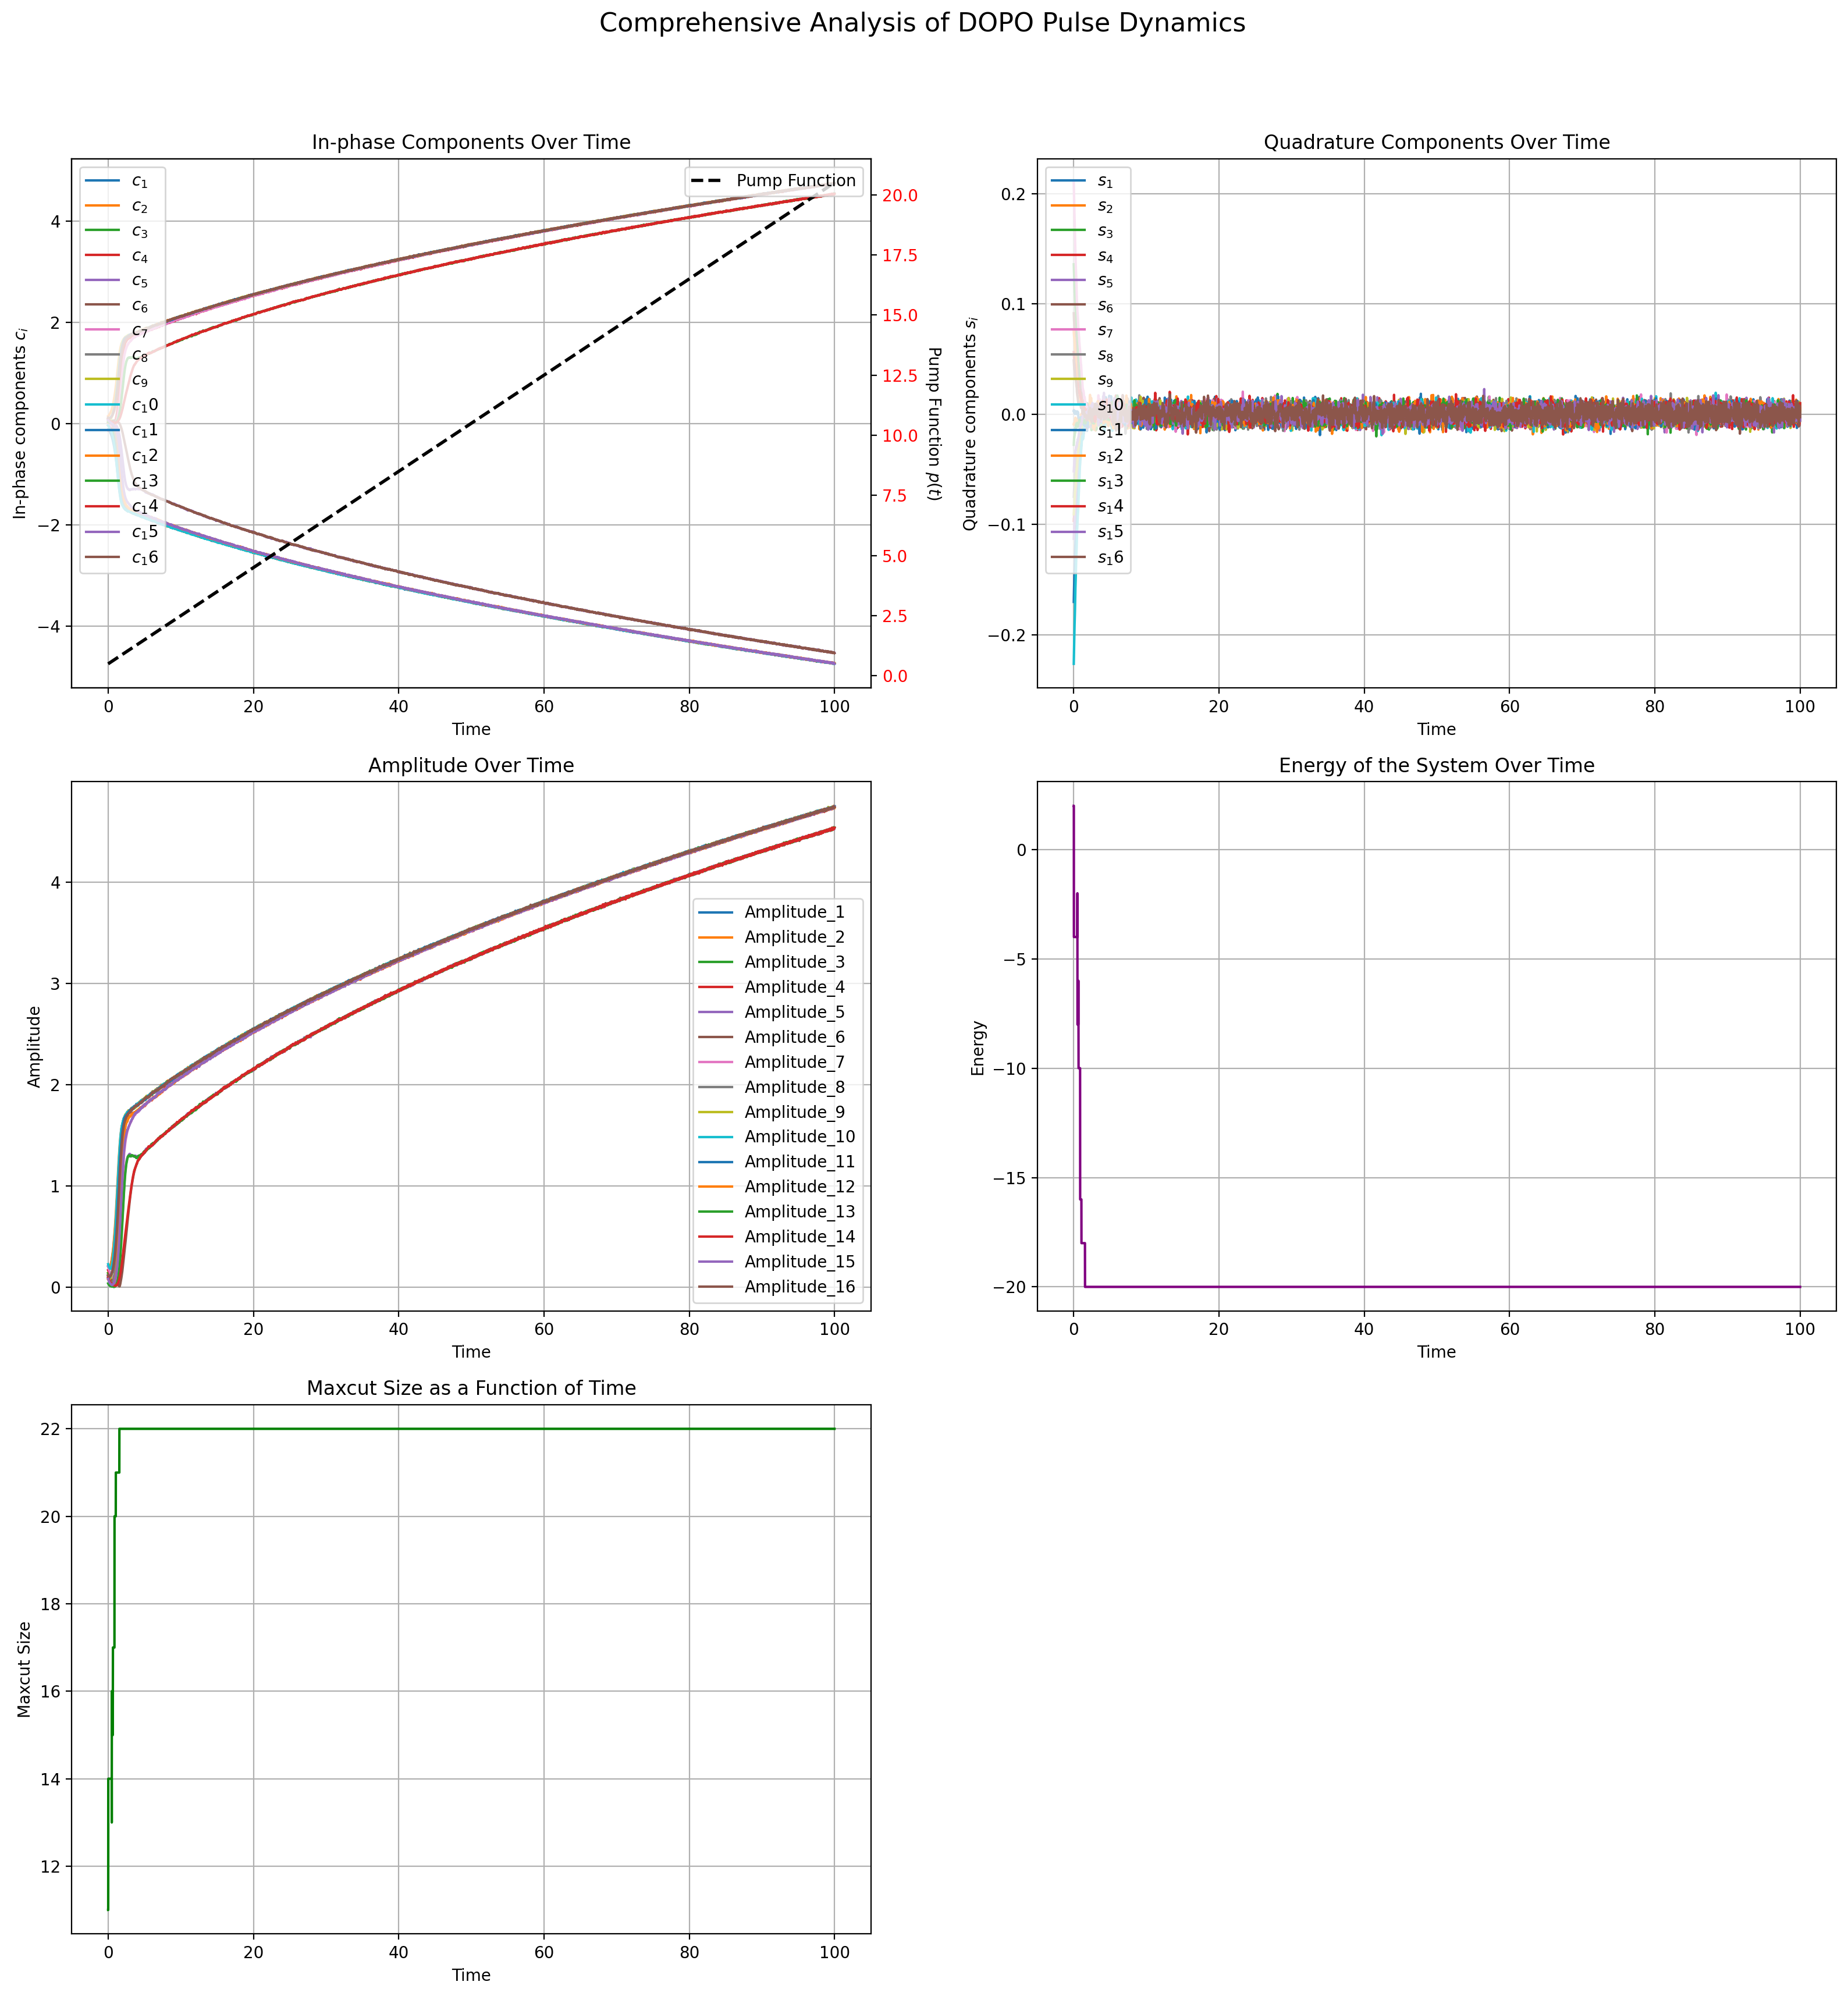

In [61]:
def pump_function(t, option='constant', params=None):
    """
    Defines the pump function p(t) based on the selected option.

    Parameters:
    - t: float or ndarray, time variable.
    - option: str, type of pump function ('constant', 'linear', 'sqrt', 'chaotic').
    - params: dict, additional parameters for the pump function.

    Returns:
    - p: float or ndarray, pump rate at time t.
    """
    if params is None:
        params = {}
    if option == 'constant':
        p0 = params.get('p0', 1.0)
        return p0
    elif option == 'linear':
        p0 = params.get('p0', 0.0)
        rate = params.get('rate', 0.1)
        return p0 + rate * t
    elif option == 'sqrt':
        p0 = params.get('p0', 0.0)
        rate = params.get('rate', 0.1)
        return p0 + rate * np.sqrt(t)
    elif option == 'chaotic':
        # Chaotic increasing pump, example using sine function
        p0 = params.get('p0', 0.0)
        amplitude = params.get('amplitude', 0.5)
        frequency = params.get('frequency', 0.2)
        return p0 + amplitude * np.abs(np.sin(2 * np.pi * frequency * t))
    else:
        raise ValueError("Invalid pump function option.")

def c_number_model(t, y, N, J, eta, g2, pump_option, pump_params, noise_c, noise_s):
    """
    Defines the ODE system for the c-number model.

    Parameters:
    - t: float, current time.
    - y: ndarray, current state vector [c_i, s_i].
    - N: int, number of DOPO pulses (spins).
    - J: ndarray, coupling matrix of shape (N, N).
    - eta: float, coupling strength.
    - g2: float, saturation parameter.
    - pump_option: str, type of pump function.
    - pump_params: dict, parameters for the pump function.
    - noise_c, noise_s: functions, predefined noise functions of time.

    Returns:
    - dydt: ndarray, derivatives [dc_i/dt, ds_i/dt].
    """
    c = y[:N]
    s = y[N:]
    p = pump_function(t, option=pump_option, params=pump_params)

    amplitude_squared = c**2 + s**2

    # Coupling term
    coupling_term = eta * J @ c

    # Noise terms (interpolated from predefined noise sequences)
    W_c = noise_c(t)
    W_s = noise_s(t)
    noise_coeff = g2 * np.sqrt(amplitude_squared + 0.5)

    dc_dt = ((p - 1 - amplitude_squared) * c + coupling_term) + noise_coeff * W_c
    ds_dt = ((-p - 1 - amplitude_squared) * s) + noise_coeff * W_s

    dydt = np.concatenate((dc_dt, ds_dt))
    return dydt

def simulate_c_number_model(N, J, eta, g2, t_span, t_eval, pump_option='constant', pump_params=None, method='RK45', include_noise=False):
    """
    Simulates the c-number model using solve_ivp with RK45 method.

    Parameters:
    - N: int, number of DOPO pulses (spins).
    - J: ndarray, coupling matrix of shape (N, N).
    - eta: float, coupling strength.
    - g2: float, saturation parameter.
    - t_span: tuple, (t_start, t_end), time span of the simulation.
    - t_eval: ndarray, time points where solution is evaluated.
    - pump_option: str, type of pump function.
    - pump_params: dict, parameters for the pump function.
    - include_noise: bool, whether to include stochastic terms.

    Returns:
    - result: OdeResult, result object from solve_ivp.
    """
    # Initial conditions
    y0 = np.zeros(2 * N)
    y0[:N] = np.random.normal(0, 0.1, N)  # Initial c_i
    y0[N:] = np.random.normal(0, 0.1, N)  # Initial s_i

    # Precompute noise sequences if including noise
    if include_noise:
        np.random.seed(0)  # For reproducibility
        W_c_sequence = np.random.normal(0, np.sqrt(t_eval[1] - t_eval[0]), (N, len(t_eval)))
        W_s_sequence = np.random.normal(0, np.sqrt(t_eval[1] - t_eval[0]), (N, len(t_eval)))

        # Interpolate noise sequences
        from scipy.interpolate import interp1d
        noise_c_funcs = [interp1d(t_eval, W_c_sequence[i], kind='linear', fill_value="extrapolate") for i in range(N)]
        noise_s_funcs = [interp1d(t_eval, W_s_sequence[i], kind='linear', fill_value="extrapolate") for i in range(N)]

        # Define functions to provide noise at any time t
        def noise_c(t):
            return np.array([noise_c_funcs[i](t) for i in range(N)])
        def noise_s(t):
            return np.array([noise_s_funcs[i](t) for i in range(N)])
    else:
        # If not including noise, set noise terms to zero
        def noise_c(t):
            return np.zeros(N)
        def noise_s(t):
            return np.zeros(N)

    # Define the ODE system
    def ode_system(t, y):
        return c_number_model(t, y, N, J, eta, g2, pump_option, pump_params, noise_c, noise_s)

    # Implement Euler's method
    def euler_method(odes_func, t_span, y0, t_eval, args):
        t0, tf = t_span
        dt = t_eval[1] - t_eval[0]
        t_values = np.arange(t0, tf + dt, dt)
        y_values = [y0]
        for t in t_values[:-1]:
            y_current = y_values[-1]
            y_next = y_current + dt * odes_func(t, y_current, *args)
            y_values.append(y_next)
        return t_values, np.array(y_values).T

    # Implement RK4 method
    def rk4_method(odes_func, t_span, y0, t_eval, args):
        t0, tf = t_span
        dt = t_eval[1] - t_eval[0]
        t_values = np.arange(t0, tf + dt, dt)
        y_values = [y0]
        for t in t_values[:-1]:
            y_current = y_values[-1]
            k1 = dt * odes_func(t, y_current, *args)
            k2 = dt * odes_func(t + dt / 2, y_current + k1 / 2, *args)
            k3 = dt * odes_func(t + dt / 2, y_current + k2 / 2, *args)
            k4 = dt * odes_func(t + dt, y_current + k3, *args)
            y_next = y_current + (k1 + 2 * k2 + 2 * k3 + k4) / 6
            y_values.append(y_next)
        return t_values, np.array(y_values).T

    # Unified solver function
    def solve_ode_system(ode_func, t_span, y0, t_eval, method='RK45', args=()):
        if method == 'Euler':
            t, y = euler_method(ode_func, t_span, y0, t_eval, args)
            return {"t": t, "y": y}
        elif method == 'RK4':
            t, y = rk4_method(ode_func, t_span, y0, t_eval, args)
            return {"t": t, "y": y}
        elif method in ['RK45', 'RK23', 'DOP853']:
            sol = solve_ivp(ode_func, t_span, y0, method=method, t_eval=t_eval, args=args)
            return {"t": sol.t, "y": sol.y}
        else:
            raise ValueError(f"Unsupported method: {method}")

    # Solve the ODE system
    result = solve_ode_system(ode_system, t_span, y0, t_eval, method=method, args=())
    return result

def max_cut_size_from_ising(H, edge_weights):

    total_edge_weight = np.sum(edge_weights) / 2  # Total weight of the edges
    cut_size = (-total_edge_weight - H) / 2
    return cut_size

def plot_graph_from_adjacency_matrix(J, layout="circular", node_values=None):
    """
    Plots a graph from an adjacency matrix using NetworkX.

    Parameters:
        J (2D array-like): Adjacency matrix of the graph.
        layout (str): Layout for the graph ('circular', 'spring', 'random', 'spectral', 'planar').
        node_values (list): List of +1 or -1 for coloring nodes. Default is None (nodes are black).

    Returns:
        None: Displays the plot.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(J))

    # Assign node colors based on node_values
    if node_values is not None and len(node_values) > 0:
        node_colors = ['red' if value == +1 else 'green' for value in node_values]
    else:
        node_colors = ['black'] * len(G.nodes)  # Default black color for all nodes

    # Select the layout
    if layout == "spring":
        pos = nx.spring_layout(G)  # Spring layout for better visualization
    elif layout == "circular":
        pos = nx.circular_layout(G)  # Circular layout
    elif layout == "random":
        pos = nx.random_layout(G)  # Random layout
    elif layout == "spectral":
        pos = nx.spectral_layout(G)  # Spectral layout
    elif layout == "planar":
        try:
            pos = nx.planar_layout(G)  # Planar layout
        except nx.NetworkXException:
            raise ValueError("Planar layout only works for planar graphs.")
    else:
        raise ValueError("Invalid layout. Choose 'circular', 'spring', 'random', 'spectral', or 'planar'.")

    # Plot the graph
    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='white')
    # Add edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(f"Graph from Adjacency Matrix ({layout.capitalize()} Layout)")
    plt.axis('off')  # Turn off the axis
    plt.show()

def main():
    # Simulation parameters
#     N = 5  # Number of DOPO pulses (spins)
    eta = 1  # Coupling strength
    g2 = 1  # Saturation parameter
    t_span = (0, 100)  # Time span of the simulation
    dt = 0.01  # Time step size
    t_eval = np.arange(t_span[0], t_span[1], dt)

    # Coupling matrix J (e.g., random symmetric matrix)
#     np.random.seed(0)  # For reproducibility
#     J = np.random.randn(N, N)
#     J = (J + J.T) / 2  # Make it symmetric

    # Call the function without node values (default black nodes)
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=[])

    # Pump function parameters
    pump_option = 'linear'  # Options: 'constant', 'linear', 'sqrt', 'chaotic'
    pump_params = {'p0': 0.5, 'rate': 0.2}

    # Include stochastic terms or not
    include_noise = True  # Set to False to exclude noise terms

    # Measure runtime
    start_time = timeit.default_timer()

    # Run the simulation
    result = simulate_c_number_model(
    N, J, eta, g2, t_span, t_eval, pump_option, pump_params, method='RK45', include_noise=True)

    # End runtime measurement
    end_time = timeit.default_timer()

    # Extract solutions
    c_values = result["y"][:N, :]  # Use result["y"] consistently
    s_values = result["y"][N:, :]

    # Calculate energy
    H = np.zeros(len(t_eval))
    for i in range(len(t_eval)):
        H[i] = -0.5 * np.sign(c_values[0:N, i].T) @ J @ np.sign(c_values[0:N, i]) - h @ np.sign(c_values[0:N, i])

    # Final state and energy
    sol_f = np.sign(c_values[0:N, -1])
    print('Final state of the machine:', sol_f)
    print('Final energy of the machine:', H[-1])
    print('Final cut size:',max_cut_size_from_ising(H[-1],J))
    print("Runtime of the function:", end_time - start_time, "seconds")

     # Call the function with node colors
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=np.array(sol_f))

    # Compute pump function values
    pump_values = [pump_function(t, option=pump_option, params=pump_params) for t in result["t"]]

    # Create a single figure with subplots
    fig, axs = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Solution of c-number equations for CIMs', fontsize=16)

    # Plot 1: In-phase components (c_i) with pump function
    ax1 = axs[0, 0]
    for i in range(N):
        ax1.plot(result["t"], c_values[i, :], label=f'$c_{i+1}$')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('In-phase components $c_i$')
    ax1.grid(True)
    ax1.legend(loc='upper left')
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(result["t"], pump_values, 'k--', label='Pump Function', linewidth=2)
    ax1_secondary.set_ylabel('Pump Function $p(t)$', rotation=270, labelpad=15)
    ax1_secondary.tick_params(axis='y', labelcolor='red')
    ax1_secondary.legend(loc='upper right')
    ax1.set_title('In-phase Components Over Time')

    # Plot 2: Quadrature components (s_i)
    ax2 = axs[0, 1]
    for i in range(N):
        ax2.plot(result["t"], s_values[i, :], label=f'$s_{i+1}$')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Quadrature components $s_i$')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Quadrature Components Over Time')

    # Plot 3: Amplitude for each DOPO pulse
    ax3 = axs[1, 0]
    for i in range(N):
        amplitude = np.sqrt(c_values[i, :]**2 + s_values[i, :]**2)
        ax3.plot(result["t"], amplitude, label=f'Amplitude_{i+1}')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Amplitude')
    ax3.grid(True)
    ax3.legend()
    ax3.set_title('Amplitude Over Time')

    # Plot 4: Energy of the system
    ax4 = axs[1, 1]
    ax4.plot(result["t"], H, color='purple')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Energy')
    ax4.grid(True)
    ax4.set_title('Energy of the System Over Time')

    # Plot 5: Max-cut size
    ax5 = axs[2, 0]
    ax5.plot(result["t"], max_cut_size_from_ising(H, J), color='green')
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Maxcut Size')
    ax5.grid(True)
    ax5.set_title('Maxcut Size as a Function of Time')

    # Hide the last empty subplot
    axs[2, 1].axis('off')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
    plt.show()

if __name__ == "__main__":
    main()


# Stochastic c-number model

In this part, I use the Euler-Maruyama method to solve the stochastic c-number model. The Euler-Maruyama method is a numerical technique used to approximate solutions of stochastic differential equations (SDEs). It extends the Euler method to include a stochastic term modeled as a Wiener process. For an SDE of the form:

$$
dX_t = a(X_t, t) \, dt + b(X_t, t) \, dW_t,
$$

where $X_t$ is the stochastic process, $a(X_t, t)$ is the drift term, $b(X_t, t)$ is the diffusion term, and $W_t$ is the Wiener process (Brownian motion).

The Euler-Maruyama approximation at discrete time steps $t_n$ with step size $\Delta t$ is:

$$
X_{n+1} = X_n + a(X_n, t_n) \, \Delta t + b(X_n, t_n) \, \Delta W_n,
$$

where $\Delta W_n = W_{t_{n+1}} - W_{t_n} \sim \mathcal{N}(0, \Delta t)$ is a normally distributed random variable with mean $0$ and variance $\Delta t$.

This iterative scheme provides an approximation to the solution of the SDE.


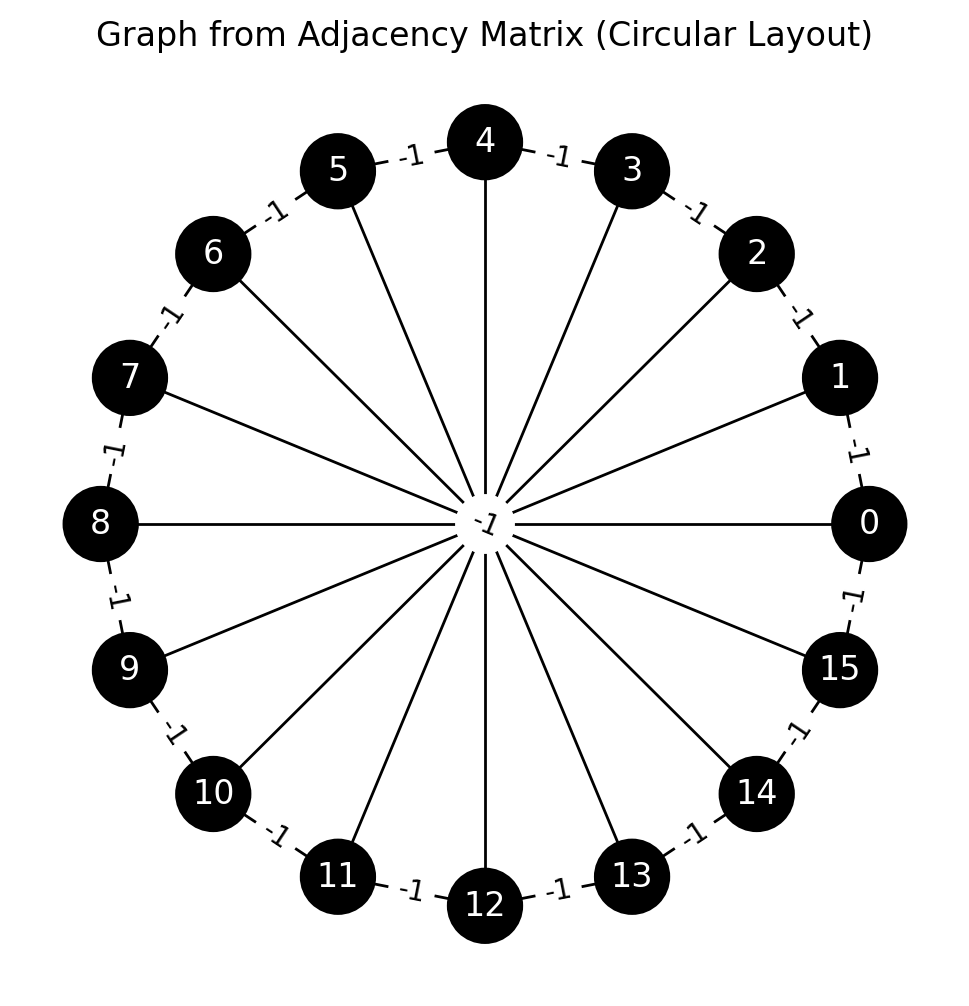

Final state of the machine: [-1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1.]
Final energy of the machine: -10.0
Final cut size: 17.0
Runtime of the function: 1.1751188609996461 seconds


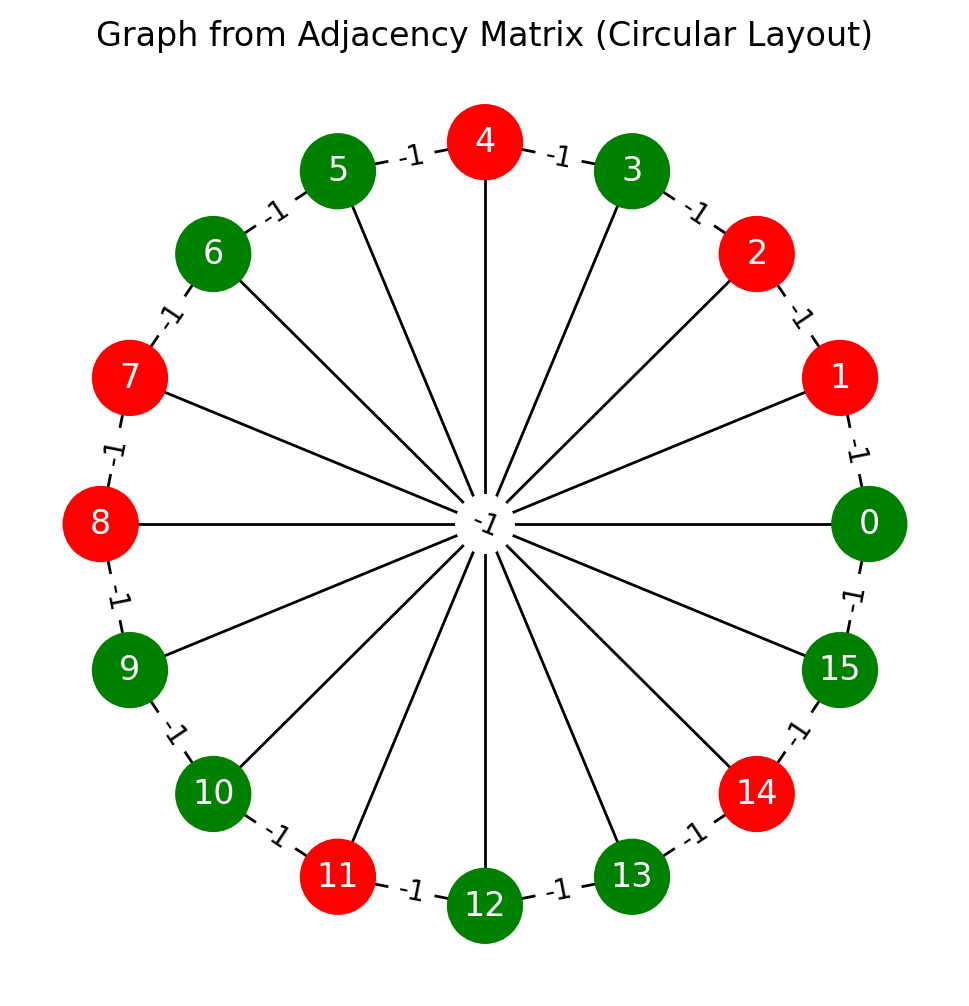

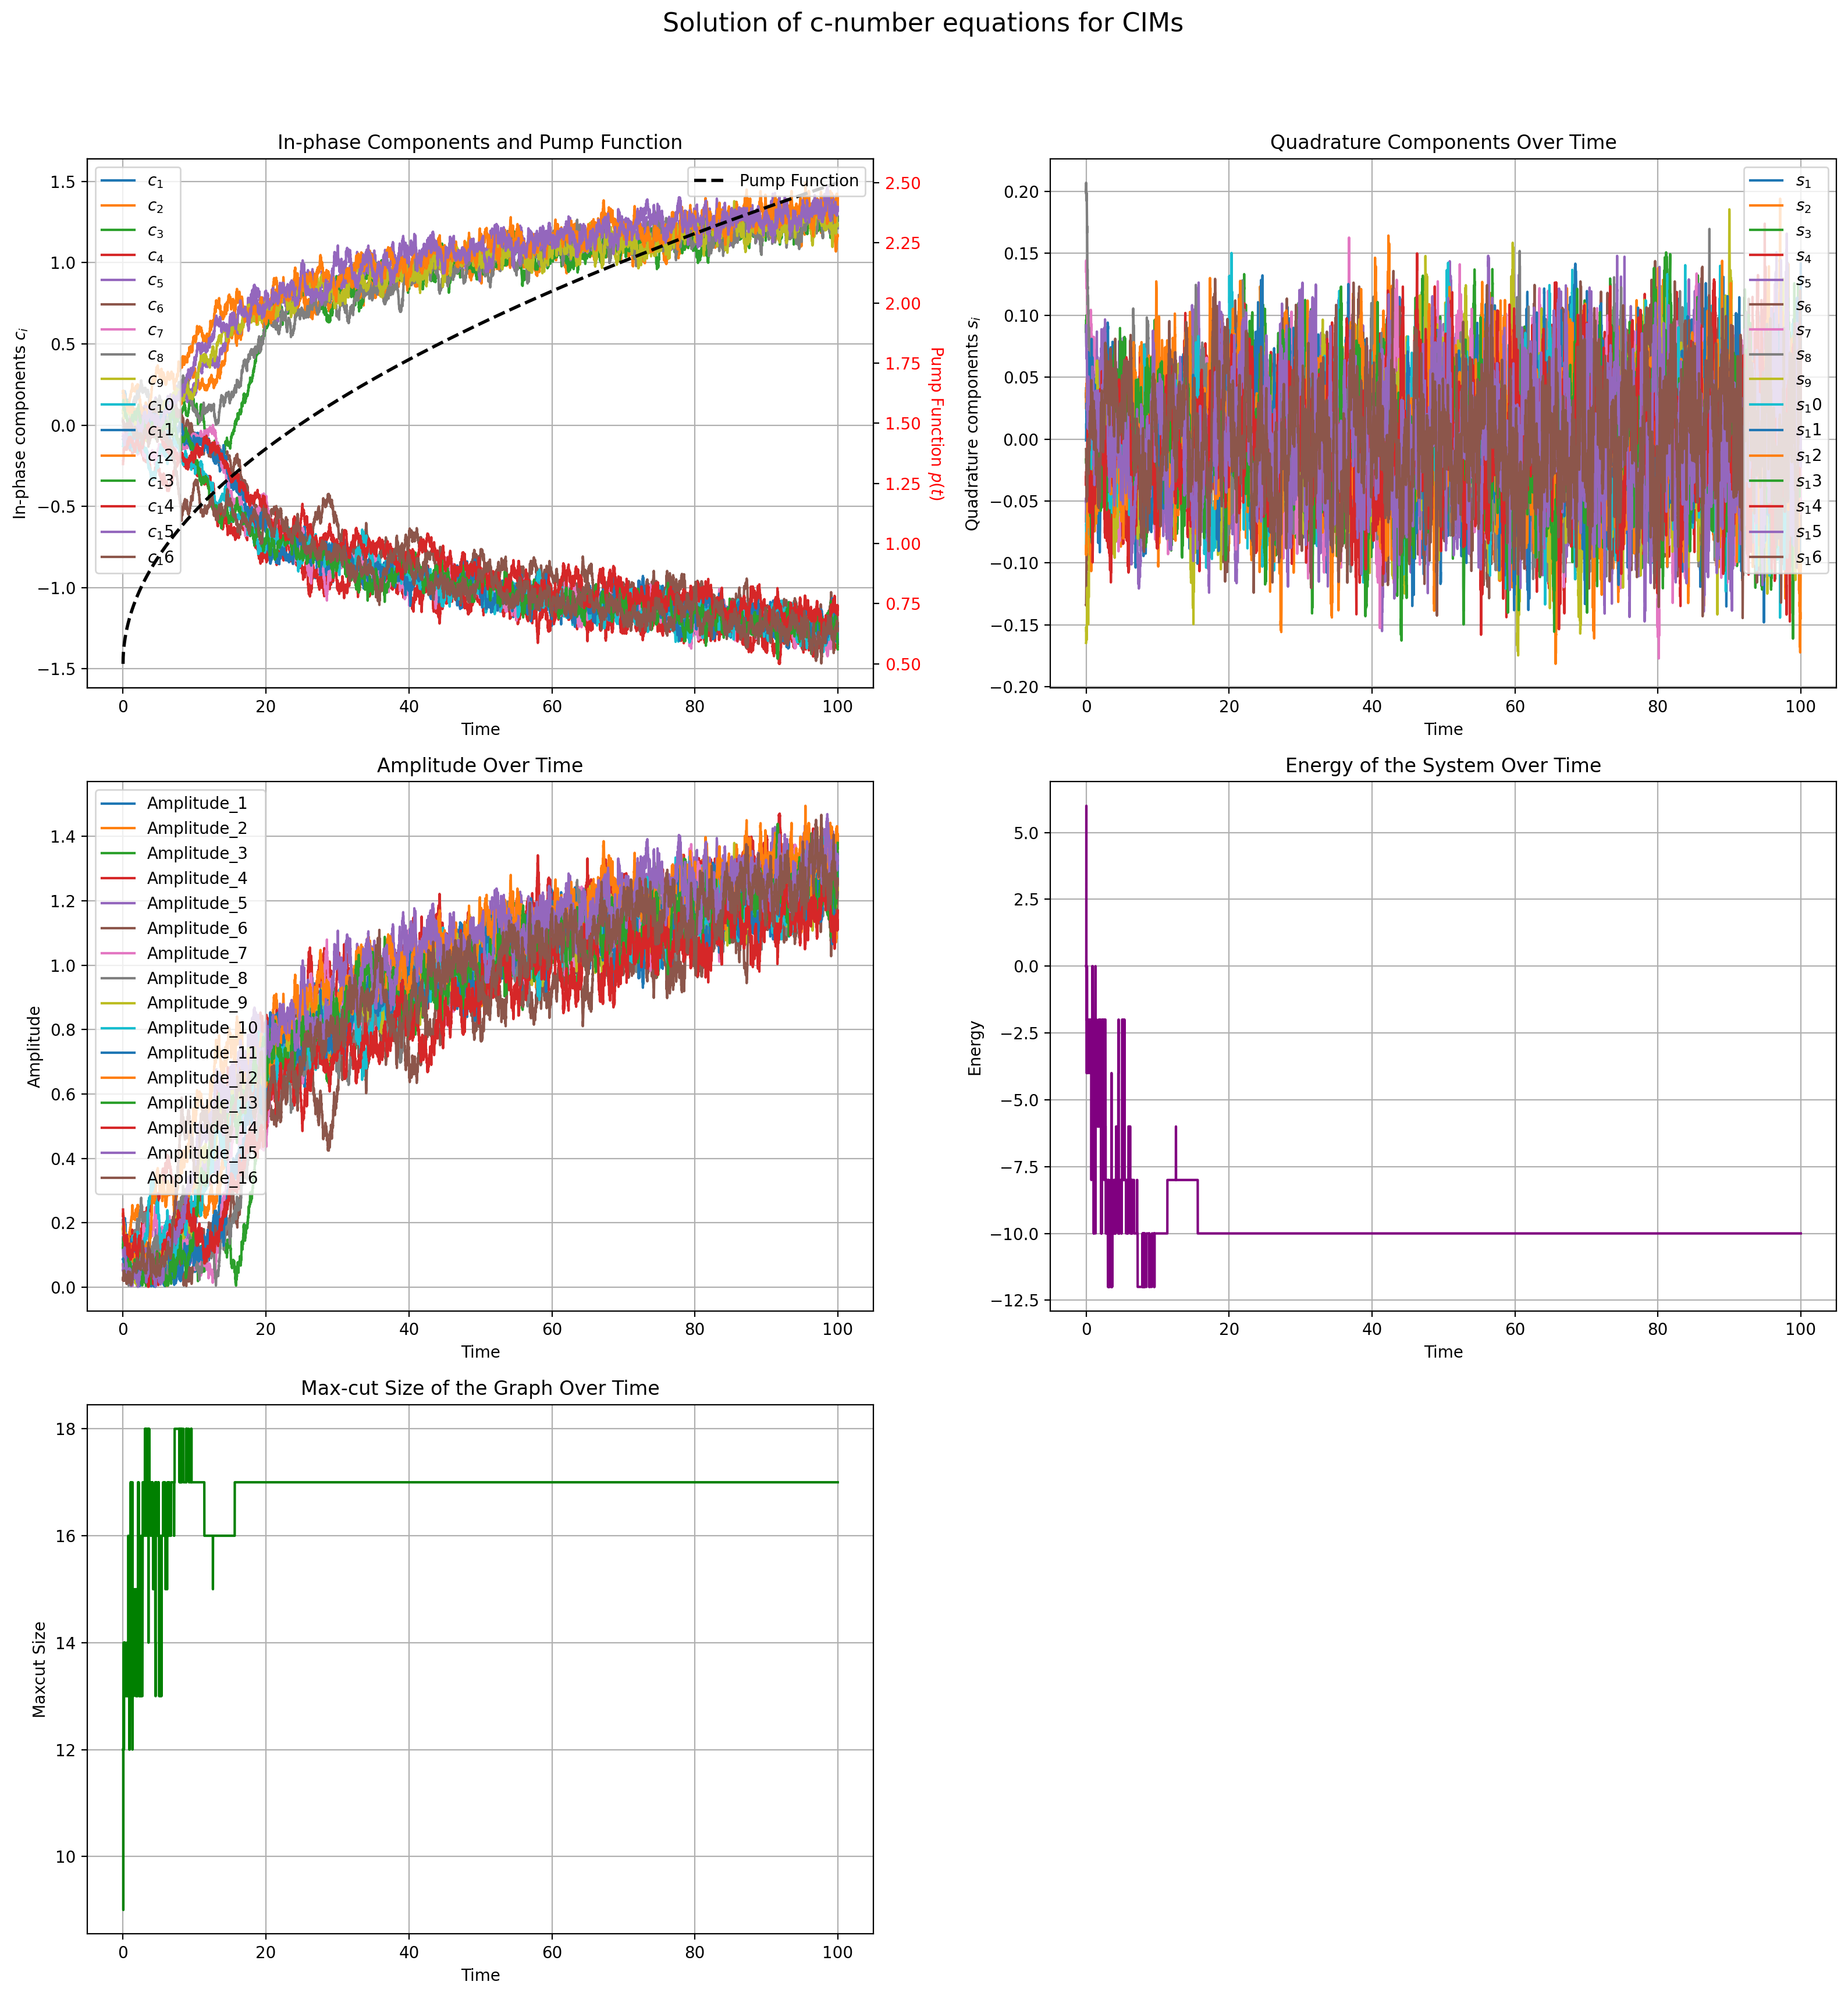

In [63]:
def pump_function(t, option='constant', params=None):
    """
    Defines the pump function p(t) based on the selected option.

    Parameters:
    - t: float or ndarray, time variable.
    - option: str, type of pump function ('constant', 'linear', 'sqrt', 'chaotic').
    - params: dict, additional parameters for the pump function.

    Returns:
    - p: float or ndarray, pump rate at time t.
    """
    if params is None:
        params = {}
    if option == 'constant':
        p0 = params.get('p0', 1.0)
        return p0
    elif option == 'linear':
        p0 = params.get('p0', 0.0)
        rate = params.get('rate', 0.1)
        return p0 + rate * t
    elif option == 'sqrt':
        p0 = params.get('p0', 0.0)
        rate = params.get('rate', 0.1)
        return p0 + rate * np.sqrt(t)
    elif option == 'chaotic':
        # Chaotic increasing pump, example using sine function
        p0 = params.get('p0', 0.0)
        amplitude = params.get('amplitude', 0.5)
        frequency = params.get('frequency', 0.2)
        return p0 + amplitude * np.abs(np.sin(2 * np.pi * frequency * t))
    else:
        raise ValueError("Invalid pump function option.")

def simulate_c_number_model(N, J, eta, g2, gamma, t_span, dt, pump_option='constant', pump_params=None):
    """
    Simulates the c-number model using the Euler-Maruyama method.

    Parameters:
    - N: int, number of DOPO pulses (spins).
    - J: ndarray, coupling matrix of shape (N, N).
    - eta: float, coupling strength.
    - g2: float, saturation parameter.
    - gamma: float, damping rate (not explicitly in equations but can be included).
    - t_span: tuple, (t_start, t_end), time span of the simulation.
    - dt: float, time step size.
    - pump_option: str, type of pump function.
    - pump_params: dict, parameters for the pump function.

    Returns:
    - t_values: ndarray, time values.
    - c_values: ndarray, values of c_i over time, shape (N, len(t_values)).
    - s_values: ndarray, values of s_i over time, shape (N, len(t_values)).
    """
    t_start, t_end = t_span
    t_values = np.arange(t_start, t_end, dt)
    num_steps = len(t_values)

    # Initialize c_i and s_i
    c = np.zeros((N, num_steps))
    s = np.zeros((N, num_steps))

    # Initial conditions (can be set as desired)
    c[:, 0] = np.random.normal(0, 0.1, N)
    s[:, 0] = np.random.normal(0, 0.1, N)

    # Precompute sqrt of dt for noise terms
    sqrt_dt = np.sqrt(dt)

    for n in range(num_steps - 1):
        t = t_values[n]
        p = pump_function(t, option=pump_option, params=pump_params)

        c_n = c[:, n]
        s_n = s[:, n]

        # Compute the magnitude squared of the amplitude
        amplitude_squared = c_n**2 + s_n**2

        # Generate Gaussian white noise terms
        W_c = np.random.normal(0, 1, N)
        W_s = np.random.normal(0, 1, N)

        # Compute the coupling term for c_i
        coupling_term = eta * J @ c_n

        # Compute the noise coefficient
        noise_coeff = g2 * np.sqrt(amplitude_squared + 0.5)

        # Update c_i
        dc = ((p - 1 - amplitude_squared) * c_n + coupling_term) * dt \
             + noise_coeff * W_c * sqrt_dt

        # Update s_i
        ds = ((-p - 1 - amplitude_squared) * s_n) * dt \
             + noise_coeff * W_s * sqrt_dt

        # Update the values for the next time step
        c[:, n+1] = c_n + dc
        s[:, n+1] = s_n + ds

    return t_values, c, s

def max_cut_size_from_ising(H, edge_weights):

    total_edge_weight = np.sum(edge_weights) / 2  # Total weight of the edges
    cut_size = (-total_edge_weight - H) / 2
    return cut_size

def plot_graph_from_adjacency_matrix(J, layout="circular", node_values=None):
    """
    Plots a graph from an adjacency matrix using NetworkX.

    Parameters:
        J (2D array-like): Adjacency matrix of the graph.
        layout (str): Layout for the graph ('circular', 'spring', 'random', 'spectral', 'planar').
        node_values (list): List of +1 or -1 for coloring nodes. Default is None (nodes are black).

    Returns:
        None: Displays the plot.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(J))

    # Assign node colors based on node_values
    if node_values is not None and len(node_values) > 0:
        node_colors = ['red' if value == +1 else 'green' for value in node_values]
    else:
        node_colors = ['black'] * len(G.nodes)  # Default black color for all nodes

    # Select the layout
    if layout == "spring":
        pos = nx.spring_layout(G)  # Spring layout for better visualization
    elif layout == "circular":
        pos = nx.circular_layout(G)  # Circular layout
    elif layout == "random":
        pos = nx.random_layout(G)  # Random layout
    elif layout == "spectral":
        pos = nx.spectral_layout(G)  # Spectral layout
    elif layout == "planar":
        try:
            pos = nx.planar_layout(G)  # Planar layout
        except nx.NetworkXException:
            raise ValueError("Planar layout only works for planar graphs.")
    else:
        raise ValueError("Invalid layout. Choose 'circular', 'spring', 'random', 'spectral', or 'planar'.")

    # Plot the graph
    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='white')
    # Add edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(f"Graph from Adjacency Matrix ({layout.capitalize()} Layout)")
    plt.axis('off')  # Turn off the axis
    plt.show()

def main():
    # Simulation parameters
#     N = 5  # Number of DOPO pulses (spins)
    eta = 0.1  # Coupling strength
    g2 = 0.1  # Saturation parameter
    gamma = 0.0  # Damping rate (not used here but can be included)
    t_span = (0, 100)  # Time span of the simulation
    dt = 0.01  # Time step size

    # Coupling matrix J (e.g., random symmetric matrix)
#     np.random.seed(0)  # For reproducibility
#     J = np.random.randn(N, N)
#     J = (J + J.T) / 2  # Make it symmetric

    # Call the function without node values (default black nodes)
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=[])

    # Pump function parameters
    pump_option = 'sqrt'  # Options: 'constant', 'linear', 'sqrt', 'chaotic'
    pump_params = {'p0': 0.5, 'rate': 0.2}

    # Measure runtime
    start_time = timeit.default_timer()

    # Run the simulation
    t_values, c_values, s_values = simulate_c_number_model(
        N, J, eta, g2, gamma, t_span, dt, pump_option, pump_params
    )

    # End runtime measurement
    end_time = timeit.default_timer()

    # Calculate energy
    H = np.zeros(len(t_values))
    for i in range(len(t_values)):
        H[i] = -0.5 * np.sign(c_values[0:N, i].T) @ J @ np.sign(c_values[0:N, i]) - h @ np.sign(c_values[0:N, i])

    # Final state and energy
    sol_f = np.sign(c_values[0:N, -1])
    print('Final state of the machine:', sol_f)
    print('Final energy of the machine:', H[-1])
    print('Final cut size:',max_cut_size_from_ising(H[-1],J))
    print("Runtime of the function:", end_time - start_time, "seconds")

     # Call the function with node colors
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=np.array(sol_f))


    # Compute pump values
    pump_values = [pump_function(t, option=pump_option, params=pump_params) for t in t_values]

    # Create a figure with subplots
    fig, axs = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Solution of c-number equations for CIMs', fontsize=16)

    # Plot 1: In-phase components (c_i) with pump function
    ax1 = axs[0, 0]
    for i in range(N):
        ax1.plot(t_values, c_values[i, :], label=f'$c_{i+1}$')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('In-phase components $c_i$')
    ax1.grid(True)
    ax1.legend(loc='upper left')
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(t_values, pump_values, 'k--', label='Pump Function', linewidth=2)
    ax1_secondary.set_ylabel('Pump Function $p(t)$', color='red', rotation=270, labelpad=15)
    ax1_secondary.tick_params(axis='y', labelcolor='red')
    ax1_secondary.legend(loc='upper right')
    ax1.set_title('In-phase Components and Pump Function')

    # Plot 2: Quadrature components (s_i)
    ax2 = axs[0, 1]
    for i in range(N):
        ax2.plot(t_values, s_values[i, :], label=f'$s_{i+1}$')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Quadrature components $s_i$')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Quadrature Components Over Time')

    # Plot 3: Amplitude for each DOPO pulse
    ax3 = axs[1, 0]
    for i in range(N):
        amplitude = np.sqrt(c_values[i, :]**2 + s_values[i, :]**2)
        ax3.plot(t_values, amplitude, label=f'Amplitude_{i+1}')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Amplitude')
    ax3.grid(True)
    ax3.legend()
    ax3.set_title('Amplitude Over Time')

    # Plot 4: Energy of the system
    ax4 = axs[1, 1]
    ax4.plot(t_values, H, color='purple')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Energy')
    ax4.grid(True)
    ax4.set_title('Energy of the System Over Time')

    # Plot 5: Max-cut size
    ax5 = axs[2, 0]
    ax5.plot(t_values, max_cut_size_from_ising(H, J), color='green')
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Maxcut Size')
    ax5.grid(True)
    ax5.set_title('Max-cut Size of the Graph Over Time')

    # Hide the unused subplot
    axs[2, 1].axis('off')

    # Adjust layout for clarity
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
    plt.show()

if __name__ == "__main__":
    main()


# CIM Discrete Model

The discrete model assumes no interference between DOPO pulses in a long cavity and considers pulses to get the gain, loss, and coupling at different positions in the CIM. We can describe the alternating occurrence of these processes using a difference equation. The amplitude of the in-phase component in the next round is given by [4]:
$$
c_i(\mathrm{t}+1)=\sqrt{\gamma G_i(t)} c_i(t)+\sqrt{G_i(t)} \eta \sum_{j=1}^N J_{i j} c_j(t)+f_i
$$

Here, $\gamma$ indicates the total loss experienced by DOPO in various optical components within the cavity, and $G_i(t)$ is the nonlinear gain obtained by DOPO in the $\mathrm{t_{\mathrm{th}}}$ round of the nonlinear medium. $f_i$ denotes the vacuum noise and the amplified spontaneous emission noise, which is a random variable with a mean of $\left\langle f_i\right\rangle=0$ and a variance of $\left\langle f_i^2>=\frac{1}{4}(2-\eta) G_i(t)\right.$.

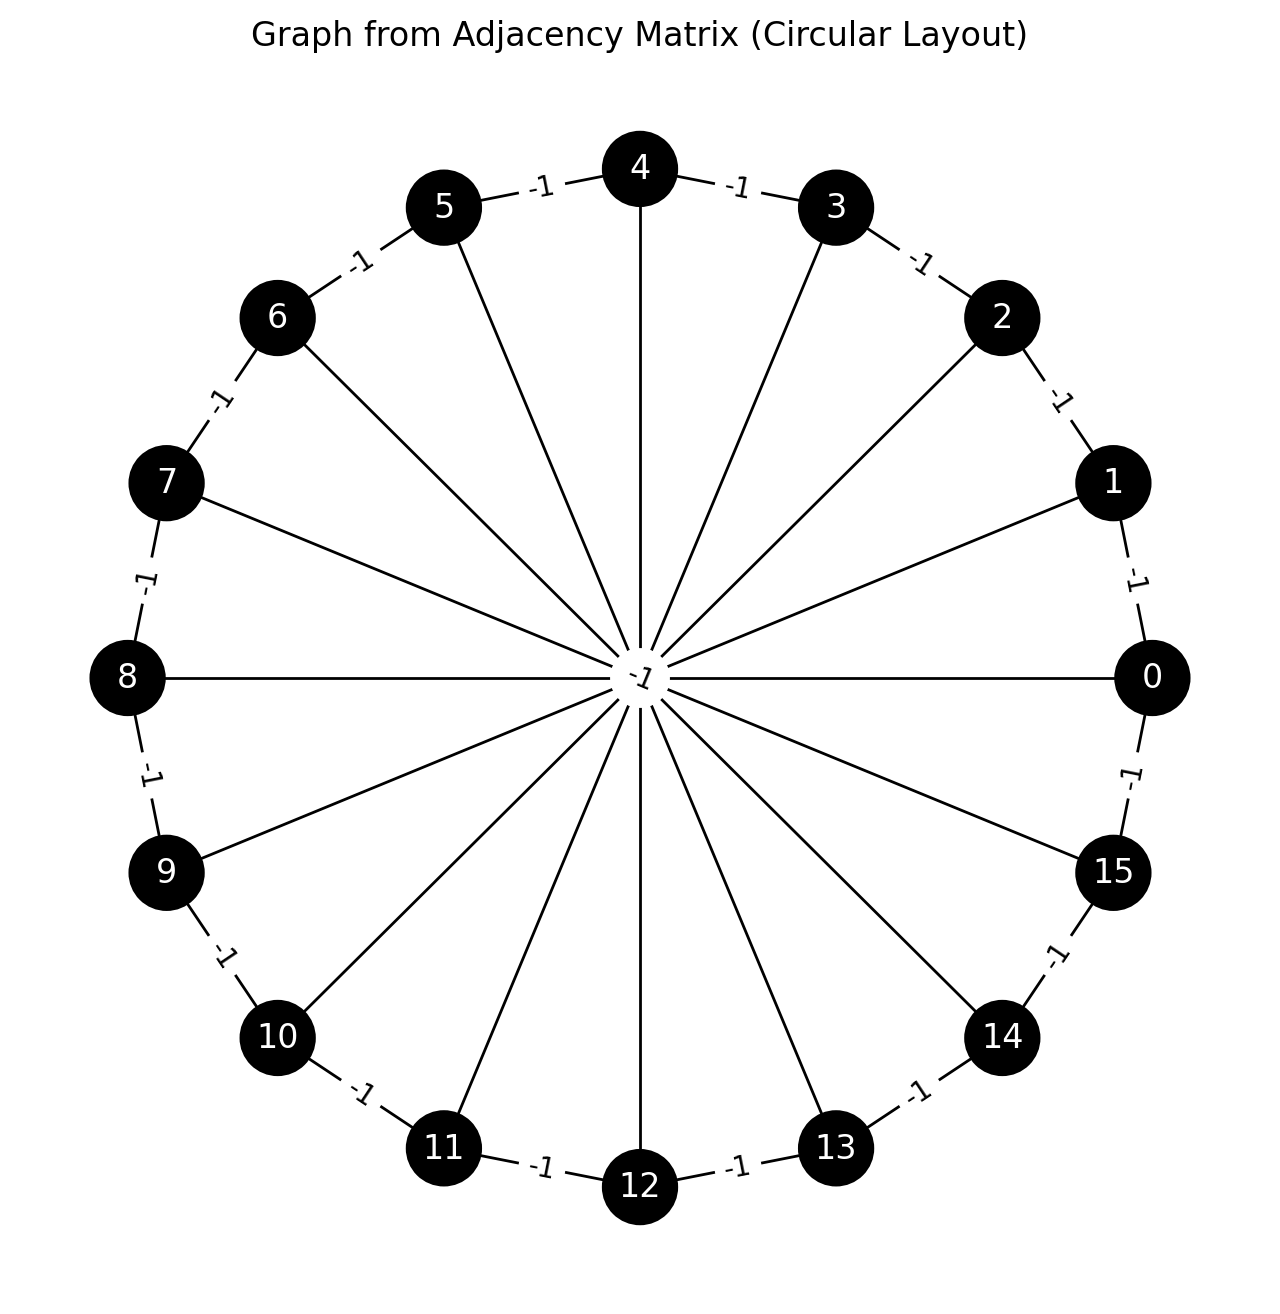

Final state of the machine: [ 1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.]
Final energy of the machine: 8.0
Final cut size: 8.0
Runtime of the function: 0.07293307600048138 seconds


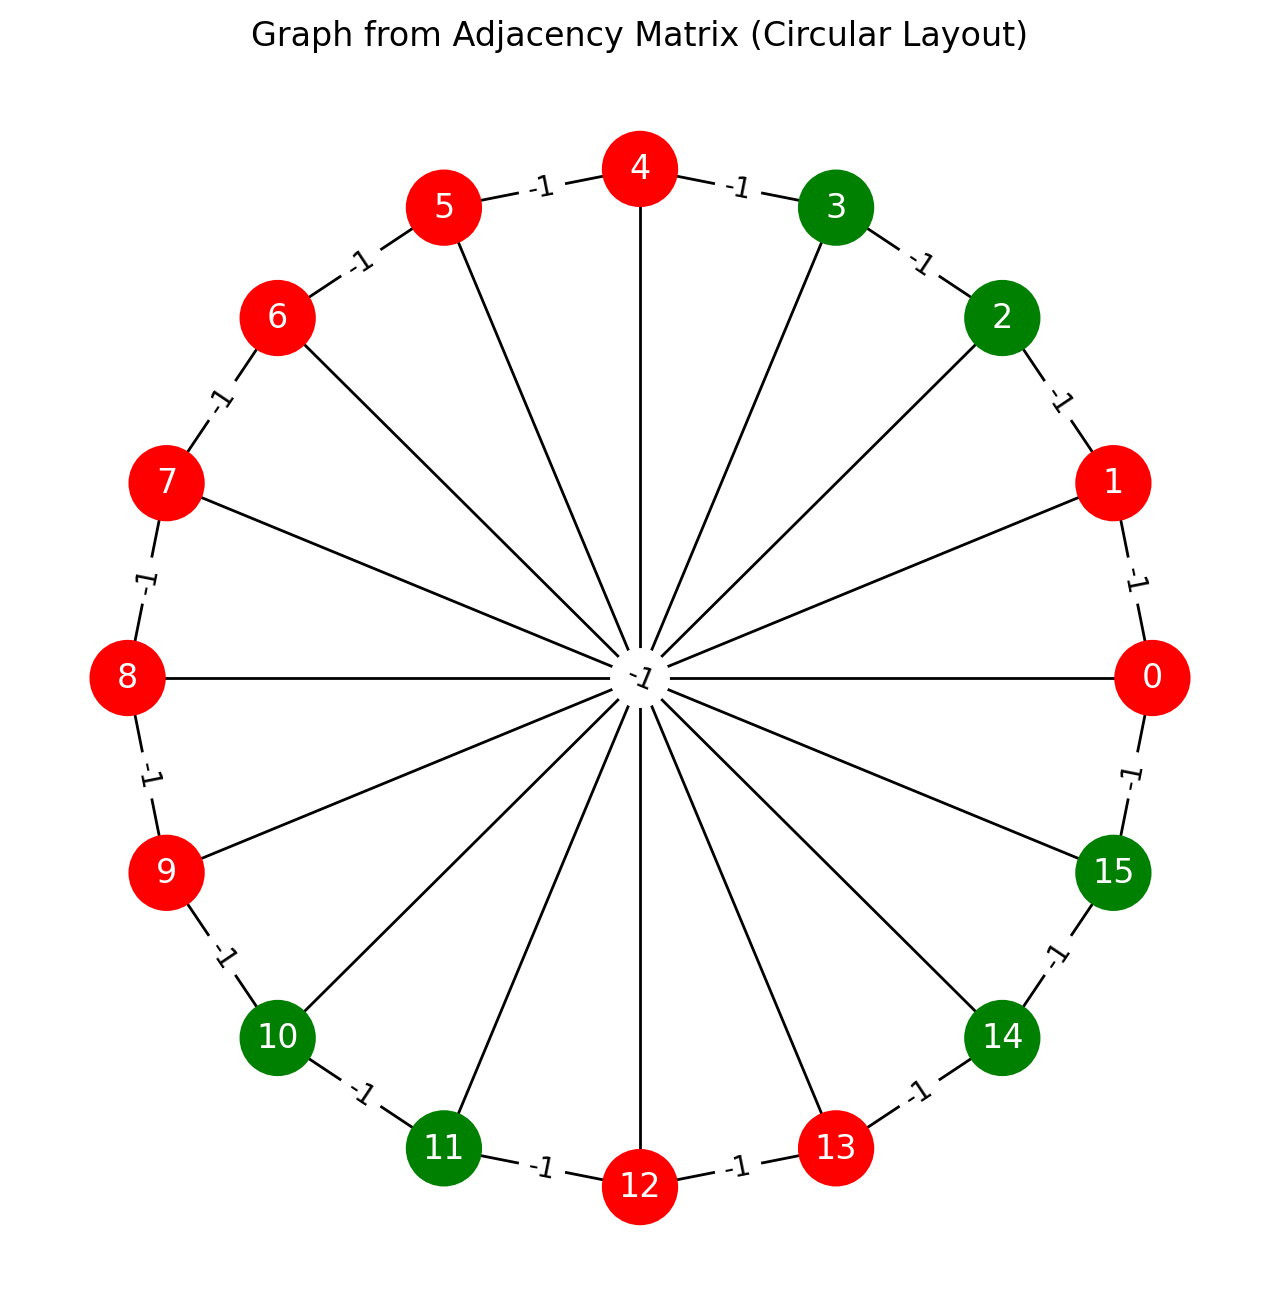

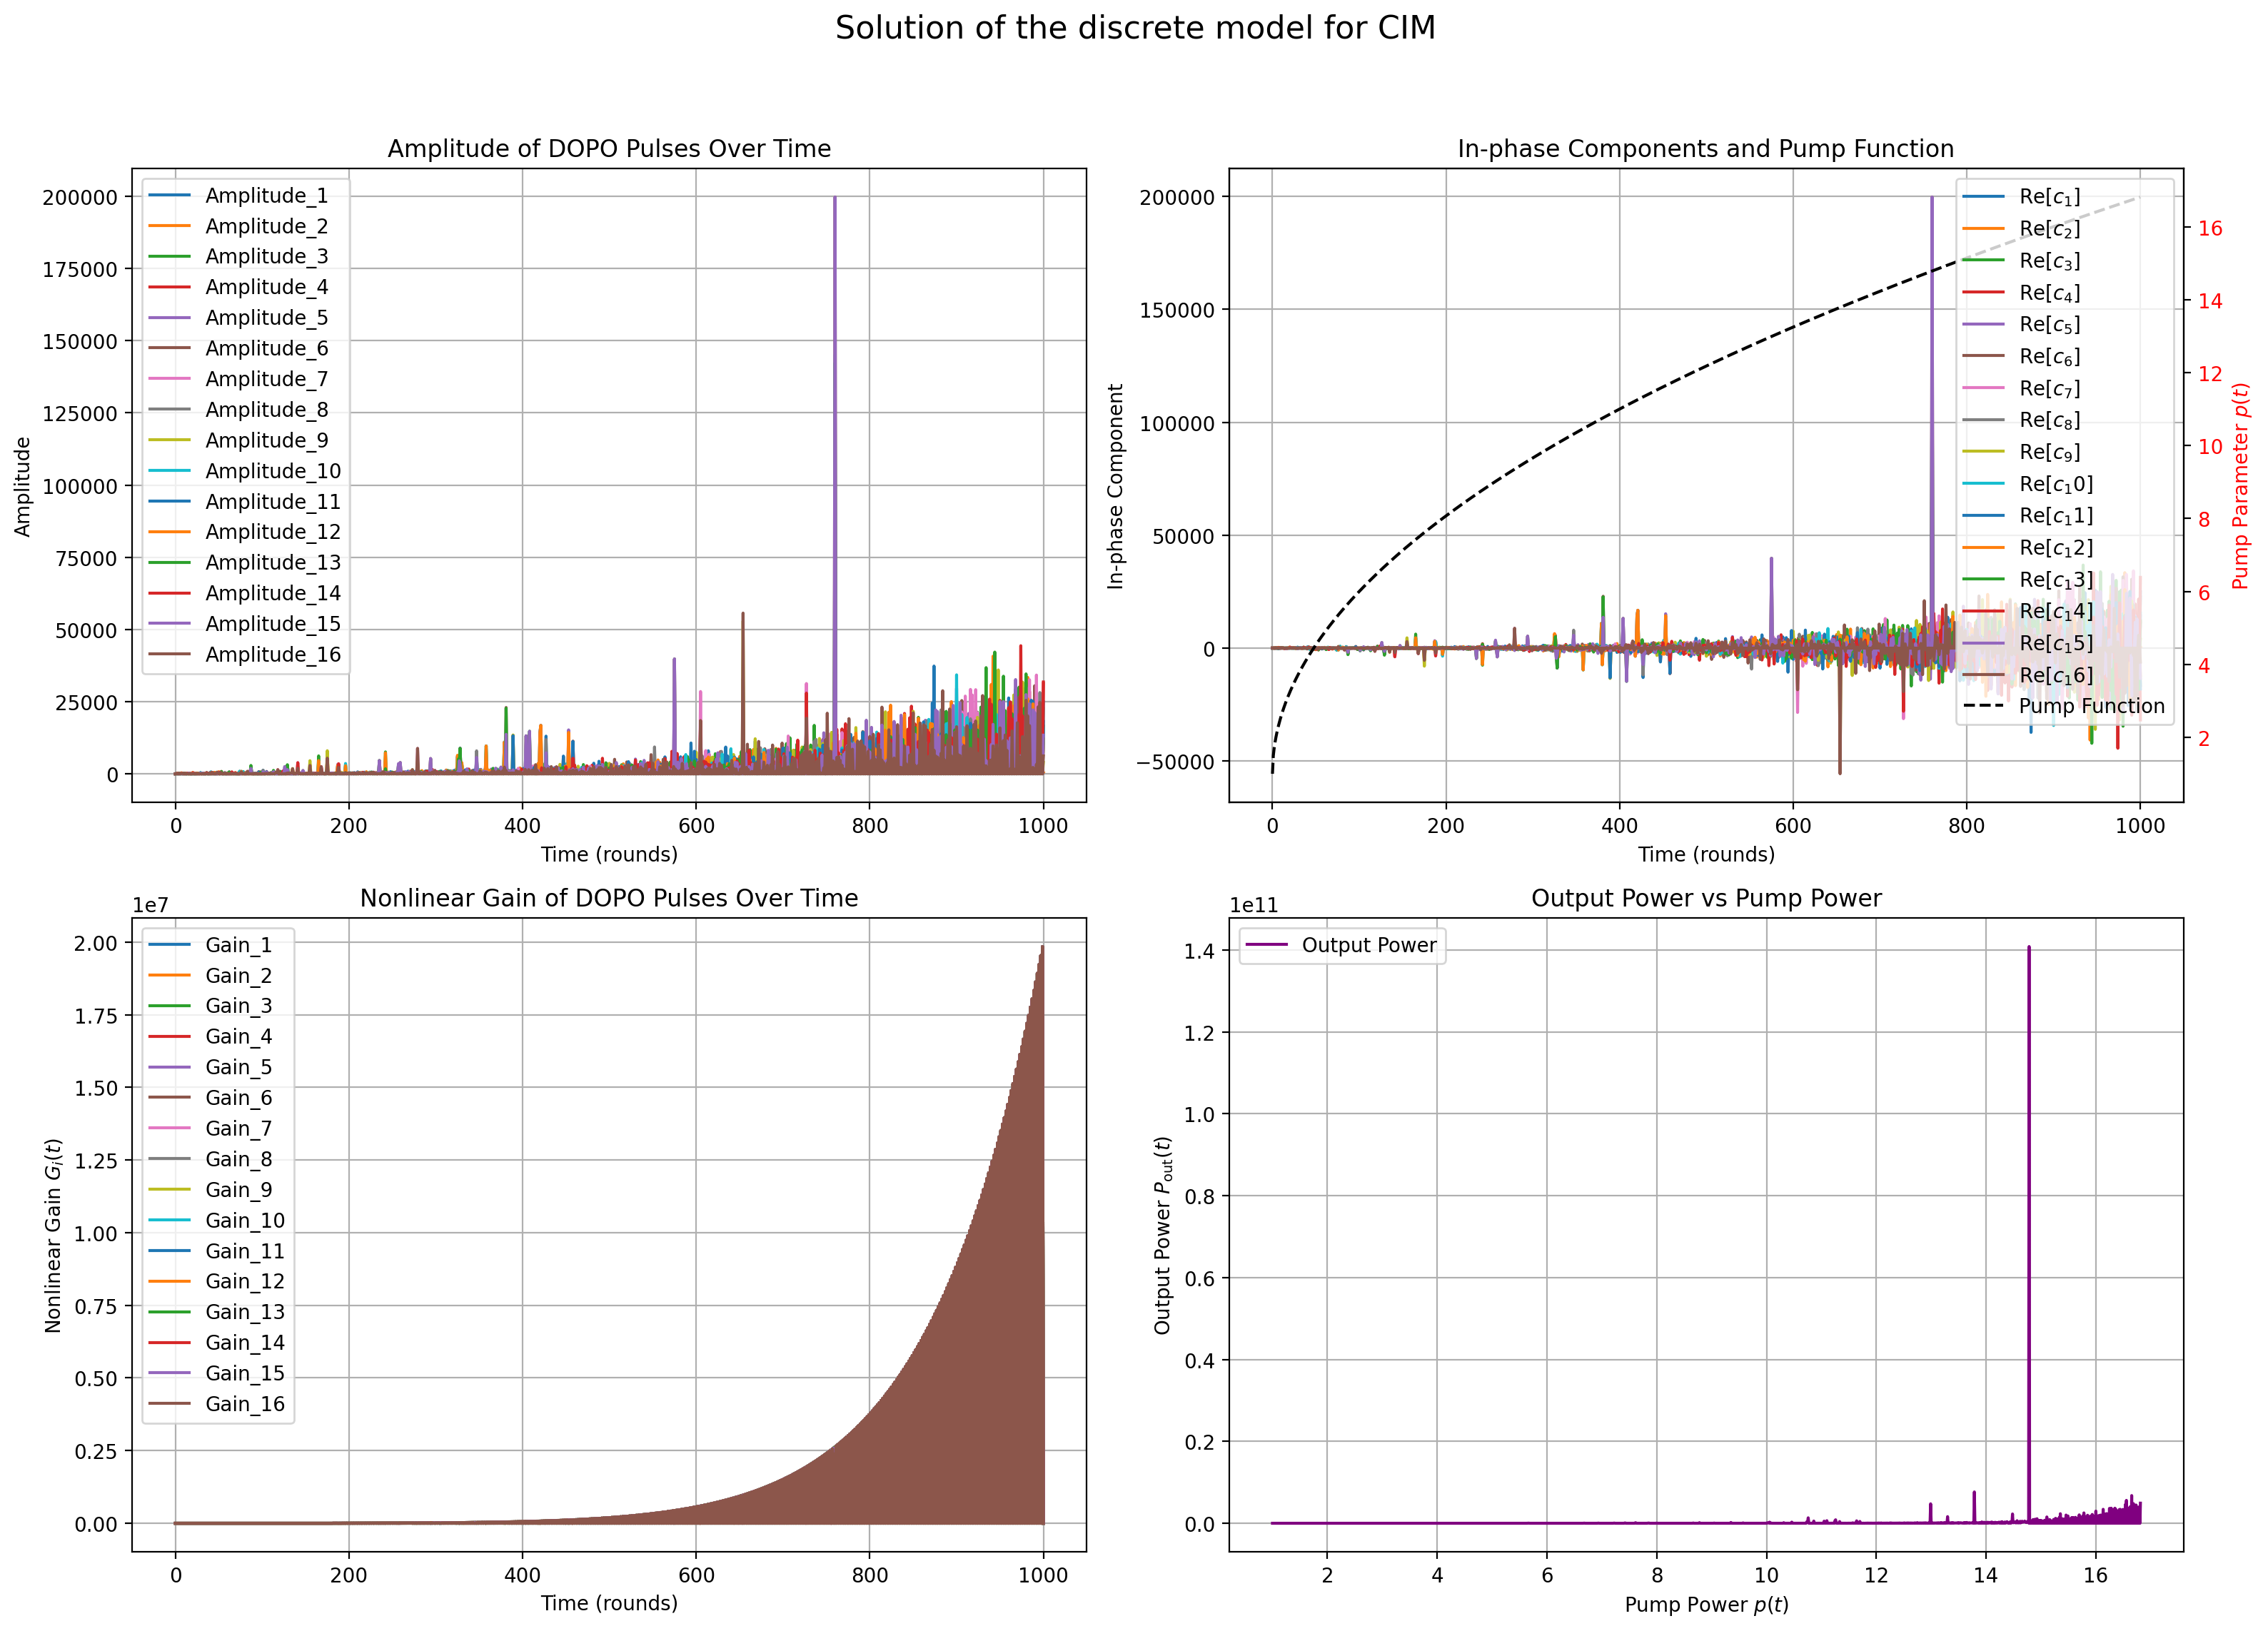

In [66]:
def pump_function(t, option='constant', params=None):
    """
    Defines the pump function p(t) based on the selected option.

    Parameters:
    - t: float or ndarray, time variable.
    - option: str, type of pump function ('constant', 'linear', 'sqrt', 'chaotic').
    - params: dict, additional parameters for the pump function.

    Returns:
    - p: float or ndarray, pump rate at time t.
    """
    if params is None:
        params = {}
    if option == 'constant':
        p0 = params.get('p0', 1.0)
        return p0
    elif option == 'linear':
        p0 = params.get('p0', 0.0)
        rate = params.get('rate', 0.1)
        return p0 + rate * t
    elif option == 'sqrt':
        p0 = params.get('p0', 0.0)
        rate = params.get('rate', 0.1)
        return p0 + rate * np.sqrt(t)
    elif option == 'chaotic':
        # Chaotic increasing pump, example using sine function
        p0 = params.get('p0', 0.0)
        amplitude = params.get('amplitude', 0.5)
        frequency = params.get('frequency', 0.2)
        return p0 + amplitude * np.abs(np.sin(2 * np.pi * frequency * t))
    else:
        raise ValueError("Invalid pump function option.")


def nonlinear_gain(c, p, function_type="exponential", **kwargs):
    """
    Calculate the nonlinear gain for different models based on the function_type.

    Parameters:
    - c (float or array): Signal amplitude(s).
    - p (float): Pump parameter.
    - function_type (str): Type of nonlinear gain function. Options include:
        'saturated', 'exponential', 'logarithmic', 'gaussian', 'power_law', 'step'.
    - **kwargs: Additional parameters for each function type.

    Returns:
    - gain (float or array): Calculated nonlinear gain.
    """

    if function_type == "saturated":
        # Saturated Gain: G(c, p) = exp(p) / (1 + (|c| / c_sat)^n)
        c_sat = kwargs.get('c_sat', 1.0)
        n = kwargs.get('n', 2)
        return np.exp(p) / (1 + (np.abs(c) / c_sat)**n)

    elif function_type == "exponential":
        # Exponential Gain: G(c, p) = exp(p - alpha * |c|^2)
        alpha = kwargs.get('alpha', 0.1)
        return np.exp(p - alpha * np.abs(c)**2)

    elif function_type == "logarithmic":
        # Logarithmic Gain: G(c, p) = log(1 + exp(p)) + beta * |c|^2
        beta = kwargs.get('beta', 0.1)
        return np.log(1 + np.exp(p)) + beta * np.abs(c)**2

    elif function_type == "gaussian":
        # Gaussian Gain: G(c, p) = exp(-|c|^2 / (2 * sigma(p)^2))
        sigma_0 = kwargs.get('sigma_0', 1.0)
        sigma = sigma_0 * np.exp(p)  # Pump-dependent width
        return np.exp(-np.abs(c)**2 / (2 * sigma**2))

    elif function_type == "power_law":
        # Power-Law Gain: G(c, p) = p * |c|^n
        n = kwargs.get('n', 2)
        return p * np.abs(c)**n

    elif function_type == "step":
        # Step Function Gain: G(c, p) = p if |c| > c_thresh else 0
        c_thresh = kwargs.get('c_thresh', 1.0)
        return p if np.abs(c) > c_thresh else 0

    else:
        raise ValueError(f"Unknown function_type: {function_type}. Available options: "
                         "'saturated', 'exponential', 'logarithmic', 'gaussian', 'power_law', 'step'.")


def simulate_cim_discrete(N, J, eta, gamma, t_span, dt, pump_option='constant', pump_params=None, gain_option='exponential',**gainargs):
    """
    Simulates the discrete CIM model using an iterative approach.

    Parameters:
    - N: int, number of DOPO pulses (spins).
    - J: ndarray, coupling matrix of shape (N, N).
    - eta: float, coupling strength (0 < eta < 1).
    - gamma: float, total loss in the cavity (0 < gamma < 1).
    - t_span: tuple, (t_start, t_end), time span of the simulation.
    - dt: float, time step size (integer increment).
    - pump_option: str, type of pump function.
    - pump_params: dict, parameters for the pump function.

    Returns:
    - t_values: ndarray, time values (integer rounds).
    - c_values: ndarray, values of c_i over time, shape (N, num_steps).
    """
    t_start, t_end = t_span
    t_values = np.arange(t_start, t_end + dt, dt)
    num_steps = len(t_values)

    # Initialize c_i
    #c = np.zeros((N, num_steps), dtype=complex)
    c = np.zeros((N, num_steps))

    # Initial conditions (can be set as desired)
    #c[:, 0] = np.random.normal(0, 0.1, N) + 1j * np.random.normal(0, 0.1, N)
    c[:, 0] = np.random.normal(0, 0.1, N)

    for n in range(num_steps - 1):
        t = t_values[n]
        p = pump_function(t, option=pump_option, params=pump_params)

        c_n = c[:, n]

        # Compute the nonlinear gain G_i(t)
        G = nonlinear_gain(c_n, p, function_type=gain_option,**gainargs)

        # Compute the noise term f_i
        variance_fi = 0.25 * (2 - eta) * G
        f_i_real = np.random.normal(0, np.sqrt(variance_fi / 2), N)
        f_i = f_i_real
        #f_i_imag = np.random.normal(0, np.sqrt(variance_fi / 2), N)
        #f_i = f_i_real + 1j * f_i_imag

        # Compute the coupling term
        coupling_term = np.sqrt(G) * eta * J @ c_n

        # Update c_i(t+1)
        c[:, n+1] = np.sqrt(gamma * G) * c_n + coupling_term + f_i

    return t_values, c

def max_cut_size_from_ising(H, edge_weights):

    total_edge_weight = np.sum(edge_weights) / 2  # Total weight of the edges
    cut_size = (-total_edge_weight - H) / 2
    return cut_size

def plot_graph_from_adjacency_matrix(J, layout="circular", node_values=None):
    """
    Plots a graph from an adjacency matrix using NetworkX.

    Parameters:
        J (2D array-like): Adjacency matrix of the graph.
        layout (str): Layout for the graph ('circular', 'spring', 'random', 'spectral', 'planar').
        node_values (list): List of +1 or -1 for coloring nodes. Default is None (nodes are black).

    Returns:
        None: Displays the plot.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(J))

    # Assign node colors based on node_values
    if node_values is not None and len(node_values) > 0:
        node_colors = ['red' if value == +1 else 'green' for value in node_values]
    else:
        node_colors = ['black'] * len(G.nodes)  # Default black color for all nodes

    # Select the layout
    if layout == "spring":
        pos = nx.spring_layout(G)  # Spring layout for better visualization
    elif layout == "circular":
        pos = nx.circular_layout(G)  # Circular layout
    elif layout == "random":
        pos = nx.random_layout(G)  # Random layout
    elif layout == "spectral":
        pos = nx.spectral_layout(G)  # Spectral layout
    elif layout == "planar":
        try:
            pos = nx.planar_layout(G)  # Planar layout
        except nx.NetworkXException:
            raise ValueError("Planar layout only works for planar graphs.")
    else:
        raise ValueError("Invalid layout. Choose 'circular', 'spring', 'random', 'spectral', or 'planar'.")

    # Plot the graph
    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='white')
    # Add edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(f"Graph from Adjacency Matrix ({layout.capitalize()} Layout)")
    plt.axis('off')  # Turn off the axis
    plt.show()


def main():
    # Simulation parameters
    #N = 10  # Number of DOPO pulses (spins)
    eta = -100.0  # Coupling strength (0 < eta < 1)
    gamma = 0.1  # Total loss in the cavity (0 < gamma < 1)
    t_span = (0, 1000)  # Time span (number of rounds)
    dt = 1  # Time step size (integer rounds)

    # Coupling matrix J (e.g., representing an Ising problem)
#     np.random.seed(0)  # For reproducibility
#     J = np.random.randn(N, N)
#     J = (J + J.T) / 2  # Make it symmetric
#     np.fill_diagonal(J, 0)  # Zero out diagonal elements

    # Call the function without node values (default black nodes)
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=[])

    # Pump function parameters
    pump_option = 'sqrt'  # Options: 'constant', 'linear', 'sqrt', 'chaotic'
    pump_params = {'p0': 1.0, 'rate': 0.5}

    # Gain function parameters
    gain_option = 'exponential'  # Options for gain function: 'exponential', 'logarithmic', etc.
    gainargs = {'alpha': 1.0}  # Example additional parameter for exponential gain
#     gain_option = 'saturated'
#     gainargs = {'c_sat': 1.0}

    # Measure runtime
    start_time = timeit.default_timer()

    # Run the simulation
    t_values, c_values = simulate_cim_discrete(
        N, J, eta, gamma, t_span, dt, pump_option, pump_params, gain_option, **gainargs
    )

    # End runtime measurement
    end_time = timeit.default_timer()

    # Calculate energy
    H = np.zeros(len(t_values))
    for i in range(len(t_values)):
        H[i] = -0.5 * np.sign(c_values[0:N, i].T) @ J @ np.sign(c_values[0:N, i])
        #- h @ np.sign(c_values[0:N, i])

    # Final state and energy
    sol_f = np.sign(c_values[0:N, -1])
    print('Final state of the machine:', sol_f)
    print('Final energy of the machine:', H[-1])
    print('Final cut size:',max_cut_size_from_ising(H[-1],J))
    print("Runtime of the function:", end_time - start_time, "seconds")

     # Call the function with node colors
    plot_graph_from_adjacency_matrix(J, layout="circular", node_values=np.array(sol_f))

    # Compute amplitudes and phases
    amplitudes = np.abs(c_values)
    phases = np.angle(c_values)

     # Compute output power (sum of squared amplitudes)
    output_power = np.sum(amplitudes**2, axis=0)

    # Compute nonlinear gain G_i(t) for each pulse
    gains = np.zeros_like(amplitudes)
    for n, t in enumerate(t_values):
        p = pump_function(t, option=pump_option, params=pump_params)
        gains[:, n] = nonlinear_gain(c_values[:, n], p)

    # Compute pump function values
    pump_values = [pump_function(t, option=pump_option, params=pump_params) for t in t_values]

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Solution of the discrete model for CIM', fontsize=16)

    # Plot 1: Amplitudes over time
    ax1 = axs[0, 0]
    for i in range(N):
        ax1.plot(t_values, amplitudes[i, :], label=f'Amplitude_{i+1}')
    ax1.set_xlabel('Time (rounds)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Amplitude of DOPO Pulses Over Time')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: In-phase components with pump function
    ax2 = axs[0, 1]
    for i in range(N):
        ax2.plot(t_values, c_values[i, :].real, label=f'Re[$c_{i+1}$]')
    ax2.set_xlabel('Time (rounds)')
    ax2.set_ylabel('In-phase Component')
    ax2.set_title('In-phase Components and Pump Function')

    # Create twin y-axis for the pump function
    ax2_secondary = ax2.twinx()
    ax2_secondary.plot(t_values, pump_values, 'k--', label='Pump Function')
    ax2_secondary.set_ylabel('Pump Parameter $p(t)$', color='red')
    ax2_secondary.tick_params(axis='y', labelcolor='red')

    # Combine legends for both axes
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_secondary.get_legend_handles_labels()
    ax2_secondary.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax2.grid(True)

    # Plot 3: Nonlinear gain over time
    ax3 = axs[1, 0]
    for i in range(N):
        ax3.plot(t_values, gains[i, :], label=f'Gain_{i+1}')
    ax3.set_xlabel('Time (rounds)')
    ax3.set_ylabel('Nonlinear Gain $G_i(t)$')
    ax3.set_title('Nonlinear Gain of DOPO Pulses Over Time')
    ax3.legend()
    ax3.grid(True)

    # Plot 4: Output power vs pump power
    ax4 = axs[1, 1]
    ax4.plot(pump_values, output_power, label='Output Power', color='purple')
    ax4.set_xlabel('Pump Power $p(t)$')
    ax4.set_ylabel('Output Power $P_{\\text{out}}(t)$')
    ax4.set_title('Output Power vs Pump Power')
    ax4.legend()
    ax4.grid(True)

    # Adjust layout for clarity
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
    plt.show()

if __name__ == "__main__":
    main()


# Benchmarking Different Solvers

While this code introduces many models, it is not feasible to benchmark them effectively within its framework. The primary reason is that each solver involves solving a different number of differential equations, making runtime comparisons between functions unreasonable for assessing performance.

Additionally, for small-scale problems—the focus of this notebook—there is no significant time difference between the various solvers. True benchmarking requires running large-scale problems on FPGAs or supercomputers, as is commonly done in academic research. For more information on benchmarking these models, refer to [4, 5, 6].

# Quantum Model of CIM-Single DOPO

In this part, I will solve the quantum master equation for a single DOPO and show the Wigner function of the single DOPO using the QuTiP package. If you haven’t installed it, you need to install it using either the pip or conda method. The equations for solving the single DOPO are [7]:

**DOPO Hamiltonian:**
$$
\hat{H}_{\text{dopo}} := \frac{\mathrm{i}}{2} \left( p \hat{a}^{\dagger 2} - p^* \hat{a}^2 \right),
$$
where $\hat{a}$ and $\hat{a}^\dagger$ are the annihilation and creation operators, respectively, and $p$ is the pump parameter.

**Jump Operators:**
$$
\hat{L}_{\mathrm{xtal}} := -\sqrt{\eta} \hat{a}^2 \quad \text{(nonlinear loss)},
$$
$$
\hat{L}_{\mathrm{loss}} := \sqrt{2 \gamma} \hat{a} \quad \text{(intrinsic loss)},
$$
$$
\hat{L}_{\mathrm{out}} := \sqrt{2 \kappa} \hat{a} \quad \text{(coupling loss)}.
$$

**Lindblad Equation:**  
The evolution of the density matrix $\hat{\rho}(t)$ is governed by:
$$
\partial_t \hat{\rho}(t) = -\mathrm{i} \left[ \hat{H}_{\mathrm{dopo}}, \hat{\rho}(t) \right] + \left( \mathcal{D} \left[ \hat{L}_{\mathrm{loss}} \right] + \mathcal{D} \left[ \hat{L}_{\mathrm{xtal}} \right] + \mathcal{D} \left[ \hat{L}_{\mathrm{out}} \right] \right) \hat{\rho}(t),
$$
where
$$
\mathcal{D}[\hat{L}] \hat{\rho} = \hat{L} \hat{\rho} \hat{L}^\dagger - \frac{1}{2} \left\{ \hat{L}^\dagger \hat{L}, \hat{\rho} \right\}.
$$

I will try to solve them using the Lindblad master equation (via the `mesolve` solver of QuTiP) or the stochastic master equation for homodyne detection (via the `smesolve` solver of QuTiP).

If you encounter problems installing QuTiP, you can run the code on Google Colab. Avoid using large values of $N$ for the dimension of the Hilbert space.


In [68]:
pip install qutip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 54.3 MB/s eta 0:00:00


In [69]:
from qutip import *
import qutip as qt

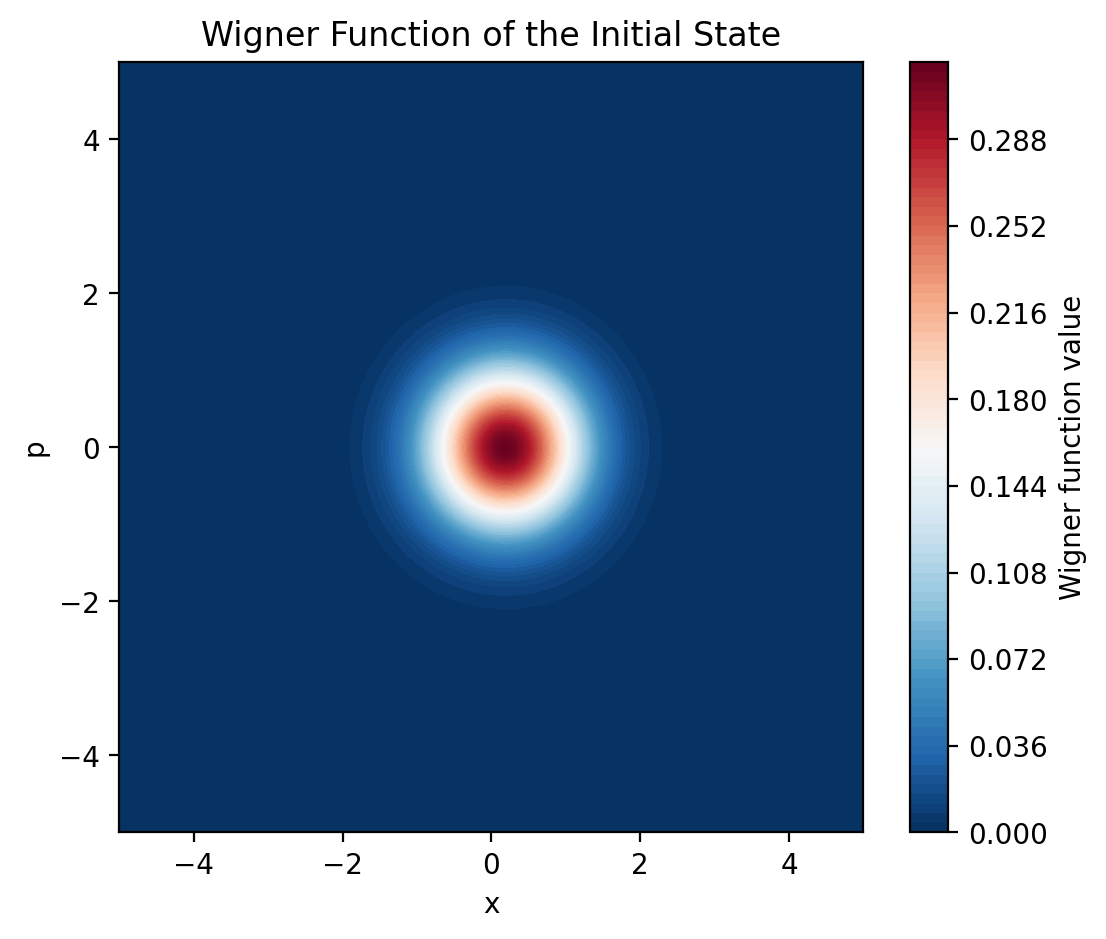

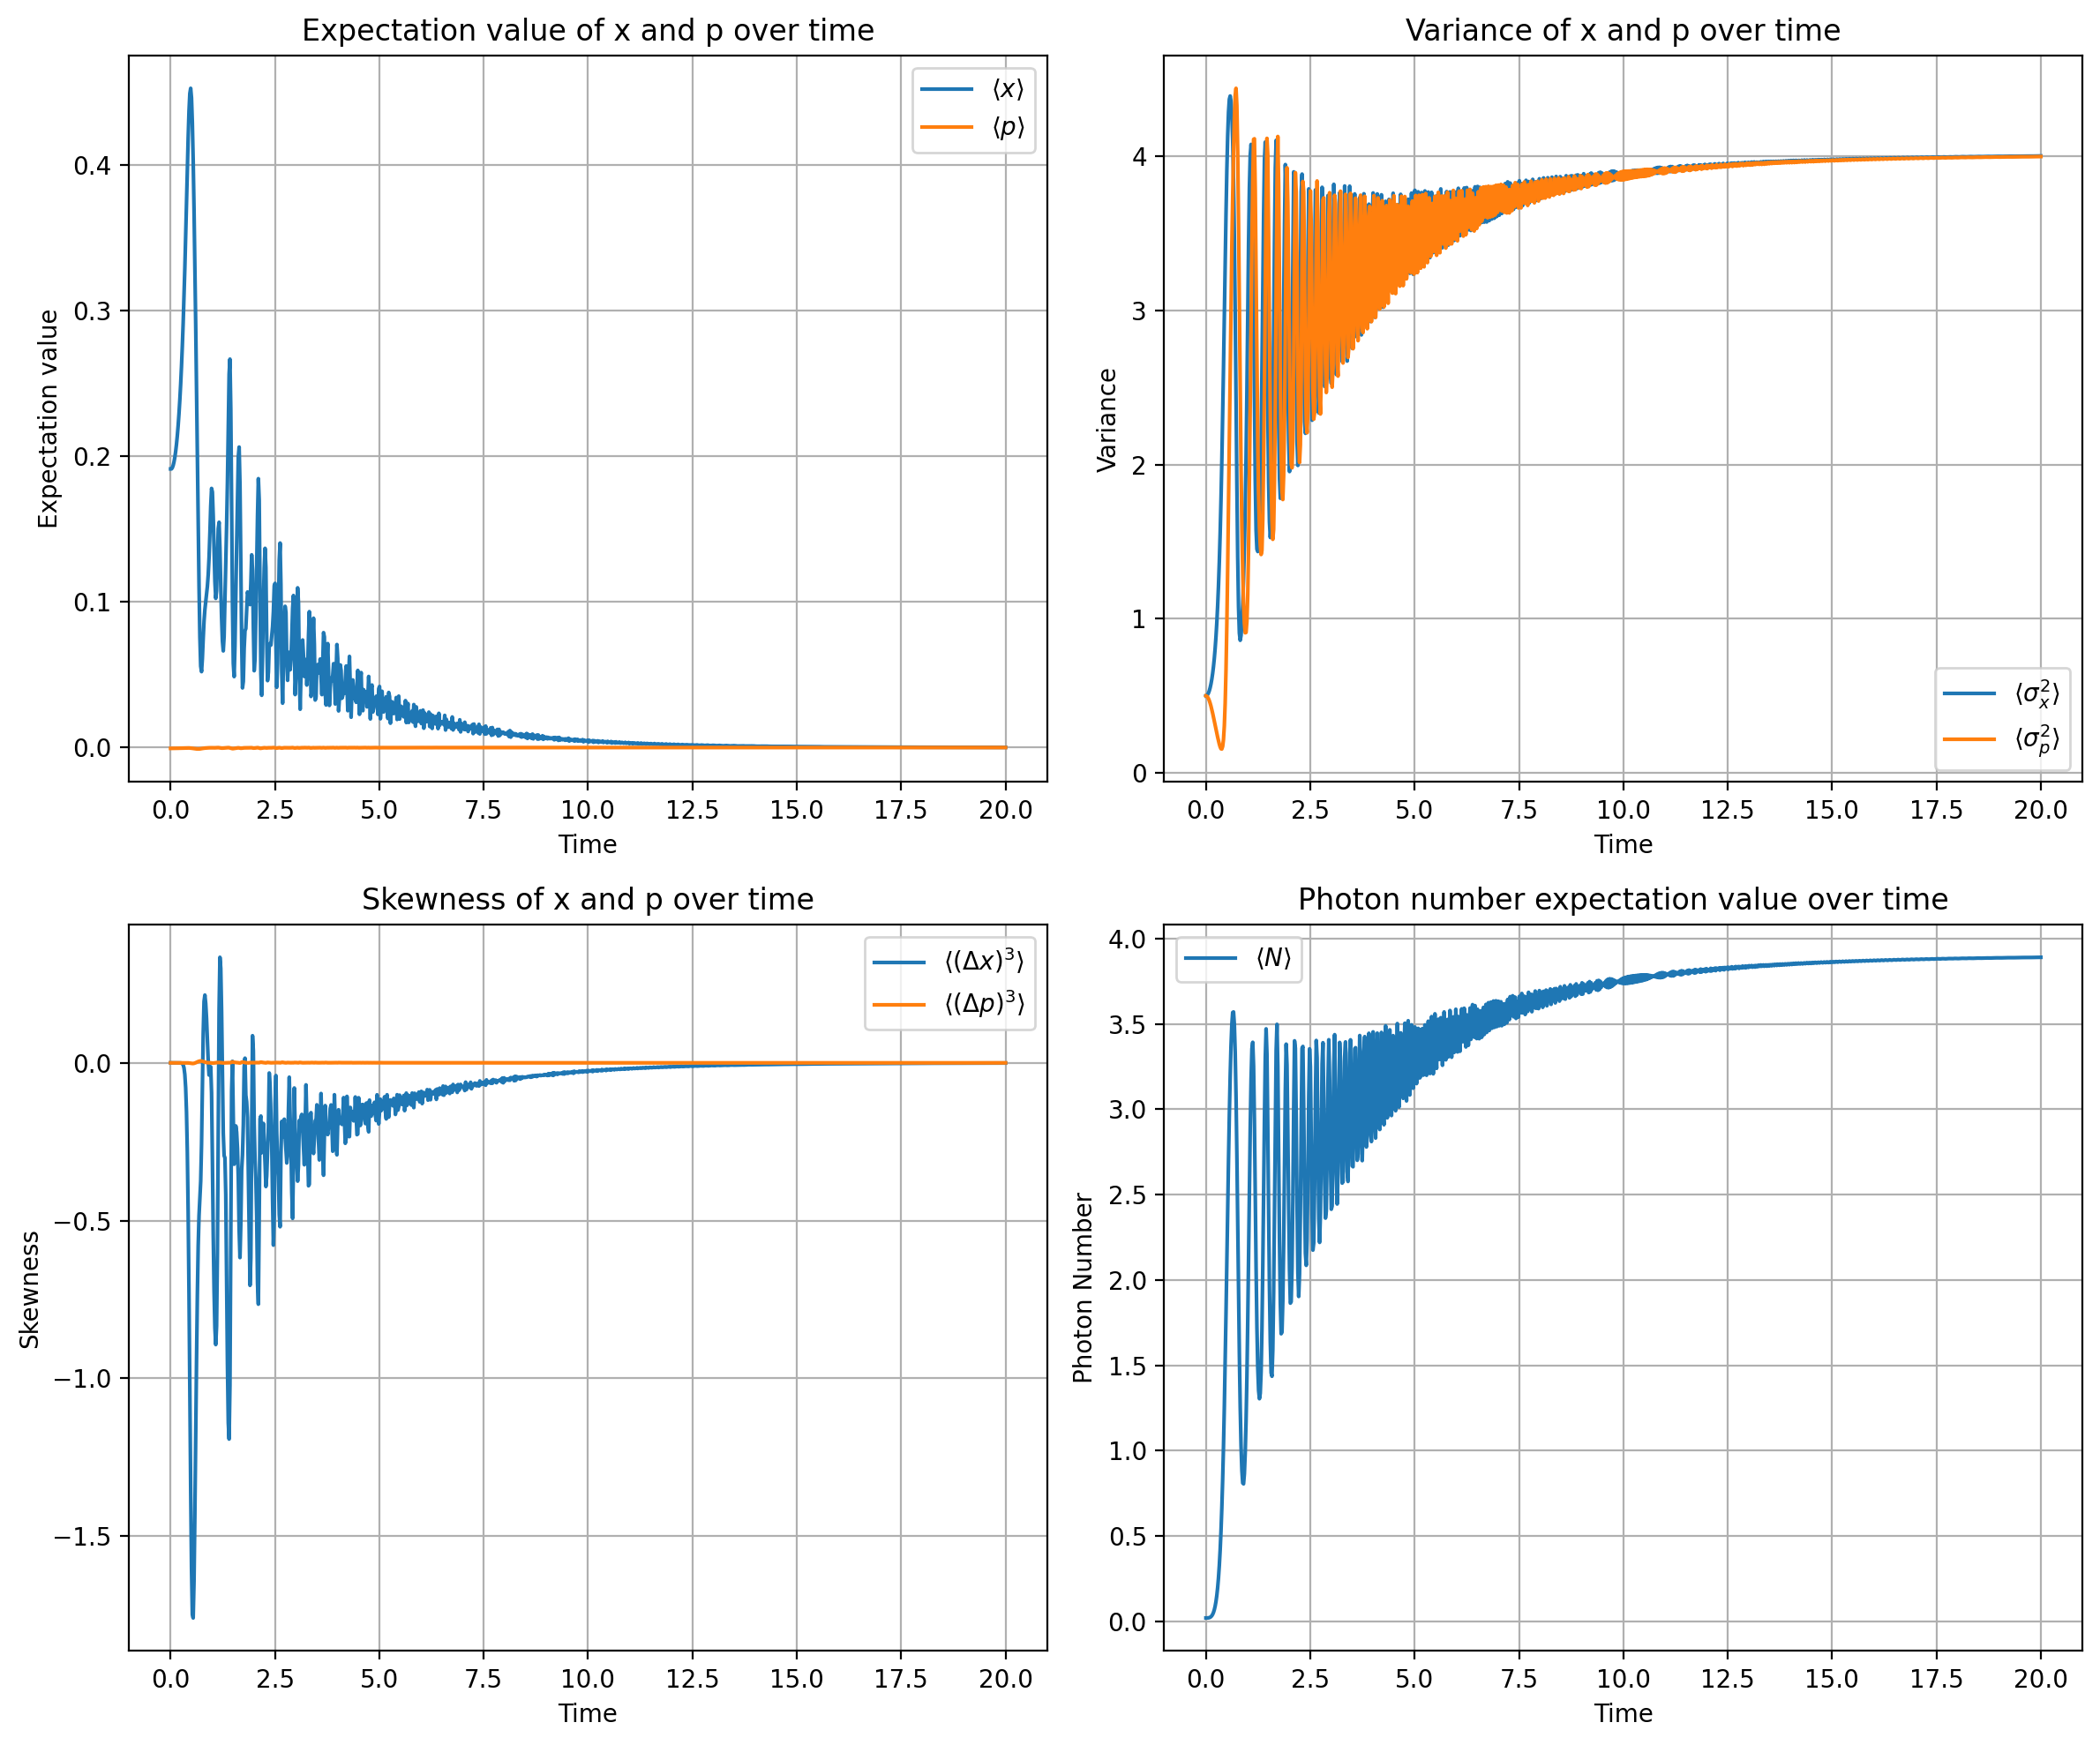

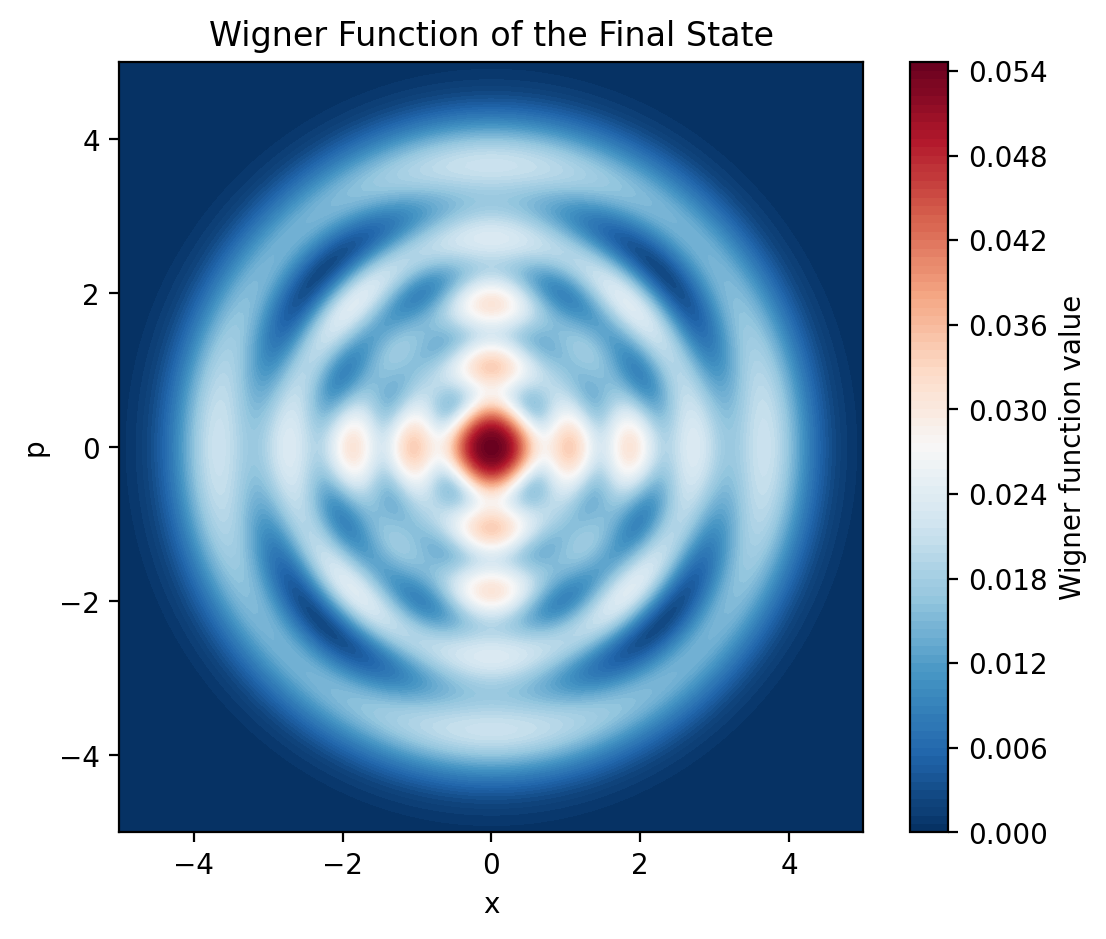

In [78]:
# Define system parameters
N = 10            # Number of Fock states (Hilbert space dimension)
p = 10            # Pump parameter (can be complex)
p0 = 0            # Initial offset for the pump function
gamma = 0.1       # Loss rate
kappa = 0.0      # Output coupling rate
eta = 0.0         # Crystal parameter (positive real number)

# Annihilation and creation operators
a = destroy(N)
adag = a.dag()

# Squeezed state
def squeezed_dm(N, r, phi=0):
    """
    Generate the density matrix for a squeezed state.

    Parameters:
    - N: int, the Hilbert space dimension (number of Fock states).
    - r: float, the squeezing parameter.
    - phi: float, the squeezing angle (default is 0).

    Returns:
    - rho: qutip.Qobj, the density matrix for the squeezed state.
    """
    # Create the vacuum state
    vacuum = qt.basis(N, 0)

    # Generate the squeezing operator
    squeezing_operator = qt.squeeze(N, r, phi)

    # Apply the squeezing operator to the vacuum state
    squeezed_state = squeezing_operator * vacuum

    # Compute the density matrix
    rho = squeezed_state * squeezed_state.dag()
    return rho


# Time-dependent Hamiltonian
def H(t, args):
    pump_type = args['pump_type']
    pump_param = p * t + p0  # Updated pump function with offset p0

    if pump_type == 'linear':
        return (1j / 2) * (adag ** 2 - a ** 2) * pump_param
    elif pump_type == 'sqrt':
        return (1j / 2) * (adag ** 2 - a ** 2) * p * np.sqrt(t) + p0
    elif pump_type == 'sinusoidal':
        return (1j / 2) * (adag ** 2 - a ** 2) * p * np.sin(t) + p0
    elif pump_type == 'chaotic':
        return (1j / 2) * (adag ** 2 - a ** 2) * p * random.random() + p0
    else:
        raise ValueError(f"Unknown pump type: {pump_type}")

# Define time-dependent Hamiltonian in QobjEvo format
pump_type = 'linear'  # Default pump type (can be set to 'linear', 'sqrt', 'sinusoidal', or 'chaotic')
H_dopo = QobjEvo(H, args={'pump_type': pump_type})

# Collapse operators
L_loss = np.sqrt(2 * gamma) * a
L_xtal = -np.sqrt(eta) * a ** 2
L_out = np.sqrt(2 * kappa) * a

# List of collapse operators
c_ops = [L_loss, L_xtal, L_out]

# Initial state (coherent state with small amplitude near zero)
real_parts = 2 * np.random.random(1) - 1  # Real parts
imag_parts = 2 * np.random.random(1) - 1  # Imaginary parts
g_0 = 1
complex_amplitude = g_0 * (real_parts + 1j * imag_parts)

rho0 = coherent_dm(N, complex_amplitude)

# Density Matrix of a squeezed state
# r=0.1
# phi=0
#rho0=qt.Qobj(squeezed_dm(N, r, phi))

# Calculate the Wigner function of the final state
xvec = np.linspace(-5, 5, 200)
W = qt.wigner(rho0, xvec, xvec)
#W = qt.wigner(rho0, xvec, xvec)

# Plot the Wigner function
X, Y = np.meshgrid(xvec, xvec)
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, W, 100, cmap='RdBu_r')
plt.colorbar(label='Wigner function value')
plt.title('Wigner Function of the Initial State')
plt.xlabel('x')
plt.ylabel('p')
plt.show()

# Operators for expectation values
x_op = (a + adag) / np.sqrt(2)
p_op = -1j * (a - adag) / np.sqrt(2)
N_op= adag*a

# Time grid
tlist = np.linspace(0, 20,1000)

# Define stochastic collapse operators for the stochastic process (example)
sc_ops = [a]

e_ops=[x_op,p_op,x_op**2,p_op**2,x_op**3,p_op**3,N_op]

# Set number of trajectories and substeps
ntraj = 10


# Solve the stochastic master equation with smesolve
#result = smesolve(H_dopo, rho0, tlist, c_ops, sc_ops=sc_ops,e_ops=e_ops,options=qutip.Options(store_states=True),ntraj=ntraj)
result = mesolve(H_dopo, rho0, tlist, c_ops, e_ops,options=qutip.Options(store_states=True))

# Extract expectation values
x_expect = result.expect[0]  # Expectation value of 'x'
sigma_x = result.expect[2] - x_expect**2  # Variance of 'x'
p_expect = result.expect[1]  # Expectation value of 'x'
sigma_p = result.expect[3] - p_expect**2  # Variance of 'x'

# Skewness
skew_x=result.expect[4]-3*result.expect[2]*x_expect+2*x_expect**3
skew_p=result.expect[5]-3*result.expect[3]*p_expect+2*p_expect**3

# Expectation of photon number
N_expect=result.expect[6]

# Plot the quadrature expectation values over time
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Expectation value of x and p over time
axes[0, 0].plot(tlist, x_expect, label=r'$\langle x \rangle$')
axes[0, 0].plot(tlist, p_expect, label=r'$\langle p \rangle$')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Expectation value')
axes[0, 0].legend()
axes[0, 0].set_title('Expectation value of x and p over time')
axes[0, 0].grid(True)

# Plot 2: Variance of x and p over time
axes[0, 1].plot(tlist, sigma_x, label=r'$\langle \sigma_{x}^2 \rangle$')
axes[0, 1].plot(tlist, sigma_p, label=r'$\langle \sigma_{p}^2 \rangle$')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Variance')
axes[0, 1].legend()
axes[0, 1].set_title('Variance of x and p over time')
axes[0, 1].grid(True)

# Plot 3: Skewness of x and p over time
axes[1, 0].plot(tlist, skew_x, label=r'$\langle (\Delta x)^3 \rangle$')
axes[1, 0].plot(tlist, skew_p, label=r'$\langle (\Delta p)^3 \rangle$')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Skewness')
axes[1, 0].legend()
axes[1, 0].set_title('Skewness of x and p over time')
axes[1, 0].grid(True)

# Plot 4: Photon number expectation value over time
axes[1, 1].plot(tlist, N_expect, label=r'$\langle N \rangle$')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Photon Number')
axes[1, 1].legend()
axes[1, 1].set_title('Photon number expectation value over time')
axes[1, 1].grid(True)

# Adjust layout for clarity
plt.tight_layout()
plt.show()


#Calculate the Wigner function of the final state
xvec = np.linspace(-5, 5, 200)
W = qt.wigner(result.states[-1], xvec, xvec)

# Plot the Wigner function
X, Y = np.meshgrid(xvec, xvec)
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, W, 100, cmap='RdBu_r')
plt.colorbar(label='Wigner function value')
plt.title('Wigner Function of the Final State')
plt.xlabel('x')
plt.ylabel('p')
plt.show()




# Animation of The Wigner Function for a Single DOPO

<ipython-input-73-15e4e178247a>:27: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '900x750', '-pix_fmt', 'rgba', '-framerate', '10', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'wigner_dynamics.mp4']' returned non-zero exit status 255.

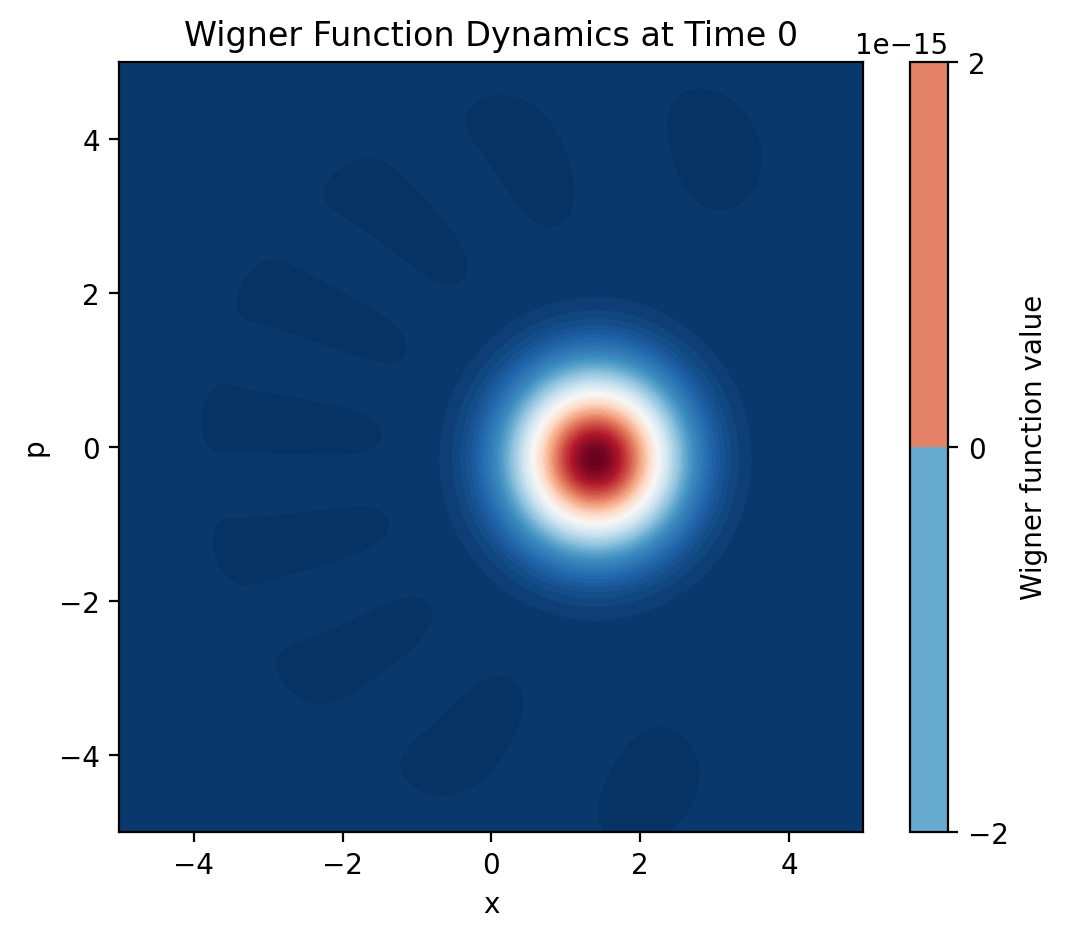

In [73]:
#### Animation of wigner function  #####

# Define the xvec range for the Wigner function
xvec = np.linspace(-5, 5, 200)

# Create a meshgrid for plotting
X, Y = np.meshgrid(xvec, xvec)

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(6, 5))
contour = ax.contourf(X, Y, np.zeros_like(X), 100, cmap='RdBu_r')
colorbar = plt.colorbar(contour, ax=ax, label='Wigner function value')
ax.set_title("Wigner Function Dynamics")
ax.set_xlabel("x")
ax.set_ylabel("p")

# Function to update the contour for each frame
def update(frame):
    rho_t = result.states[frame]  # Get the density matrix for the current time
    W = qt.wigner(rho_t, xvec, xvec)  # Compute the Wigner function
    ax.clear()  # Clear the previous plot
    ax.set_title(f"Wigner Function Dynamics at Time {frame}")
    ax.set_xlabel("x")
    ax.set_ylabel("p")
    global contour  # Declare contour as a global variable (if modifying it directly)
    contour = ax.contourf(X, Y, W, 100, cmap='RdBu_r')
    return contour.collections
# Create the animation
anim = FuncAnimation(fig, update, frames=len(tlist), interval=100, repeat=False)

# Optional: Save the animation as a file
anim.save('wigner_dynamics.mp4', fps=10, dpi=150)

# Show the animation
plt.show()



# Quantum CIM Model for 2 DOPOs

In this study, I solve the master equation for two coupled degenerate optical parametric oscillators (DOPOs) using the beam splitter interaction Hamiltonian. The Hamiltonian, as described by Onodera et al. [8], is given by:

$$
H = \frac{\mathrm{i} r}{4} \left( \hat{a}_1^{\dagger} \hat{a}_1^{\dagger} + \hat{a}_2^{\dagger} \hat{a}_2^{\dagger} - \hat{a}_1 \hat{a}_1 - \hat{a}_2 \hat{a}_2 \right) - \frac{\sin \varphi}{\Gamma+1} \left( \hat{a}_1^{\dagger} \hat{a}_2 + \hat{a}_1 \hat{a}_2^{\dagger} \right),
$$

where $r$ is the normalized pump parameter, $\varphi$ is the coupling phase, and $\Gamma$ characterizes the measurement rate of the output coupler. The dynamical equations are:

$$
\frac{\mathrm{d} \hat{a}_1}{\mathrm{d} t} = r \hat{a}_1^{\dagger} - \hat{a}_1 - \frac{1}{\eta} \hat{a}_1^{\dagger} \hat{a}_1^2 + \frac{e^{i \varphi}}{\Gamma+1} \hat{a}_2,
$$
$$
\frac{\mathrm{d} \hat{a}_2}{\mathrm{d} t} = r \hat{a}_2^{\dagger} - \hat{a}_2 - \frac{1}{\eta} \hat{a}_2^{\dagger} \hat{a}_2^2 + \frac{e^{i \varphi}}{\Gamma+1} \hat{a}_1,
$$

where $\hat{a}_1$ and $\hat{a}_2$ are the annihilation operators for the first and second DOPO, respectively, and $1/\eta$ represents the nonlinear gain saturation. These equations describe the interaction dynamics with coupling characterized by the parameter $\xi = (\Gamma + 1)^{-1}$, enabling the study of correlated phase dynamics in the DOPO network.


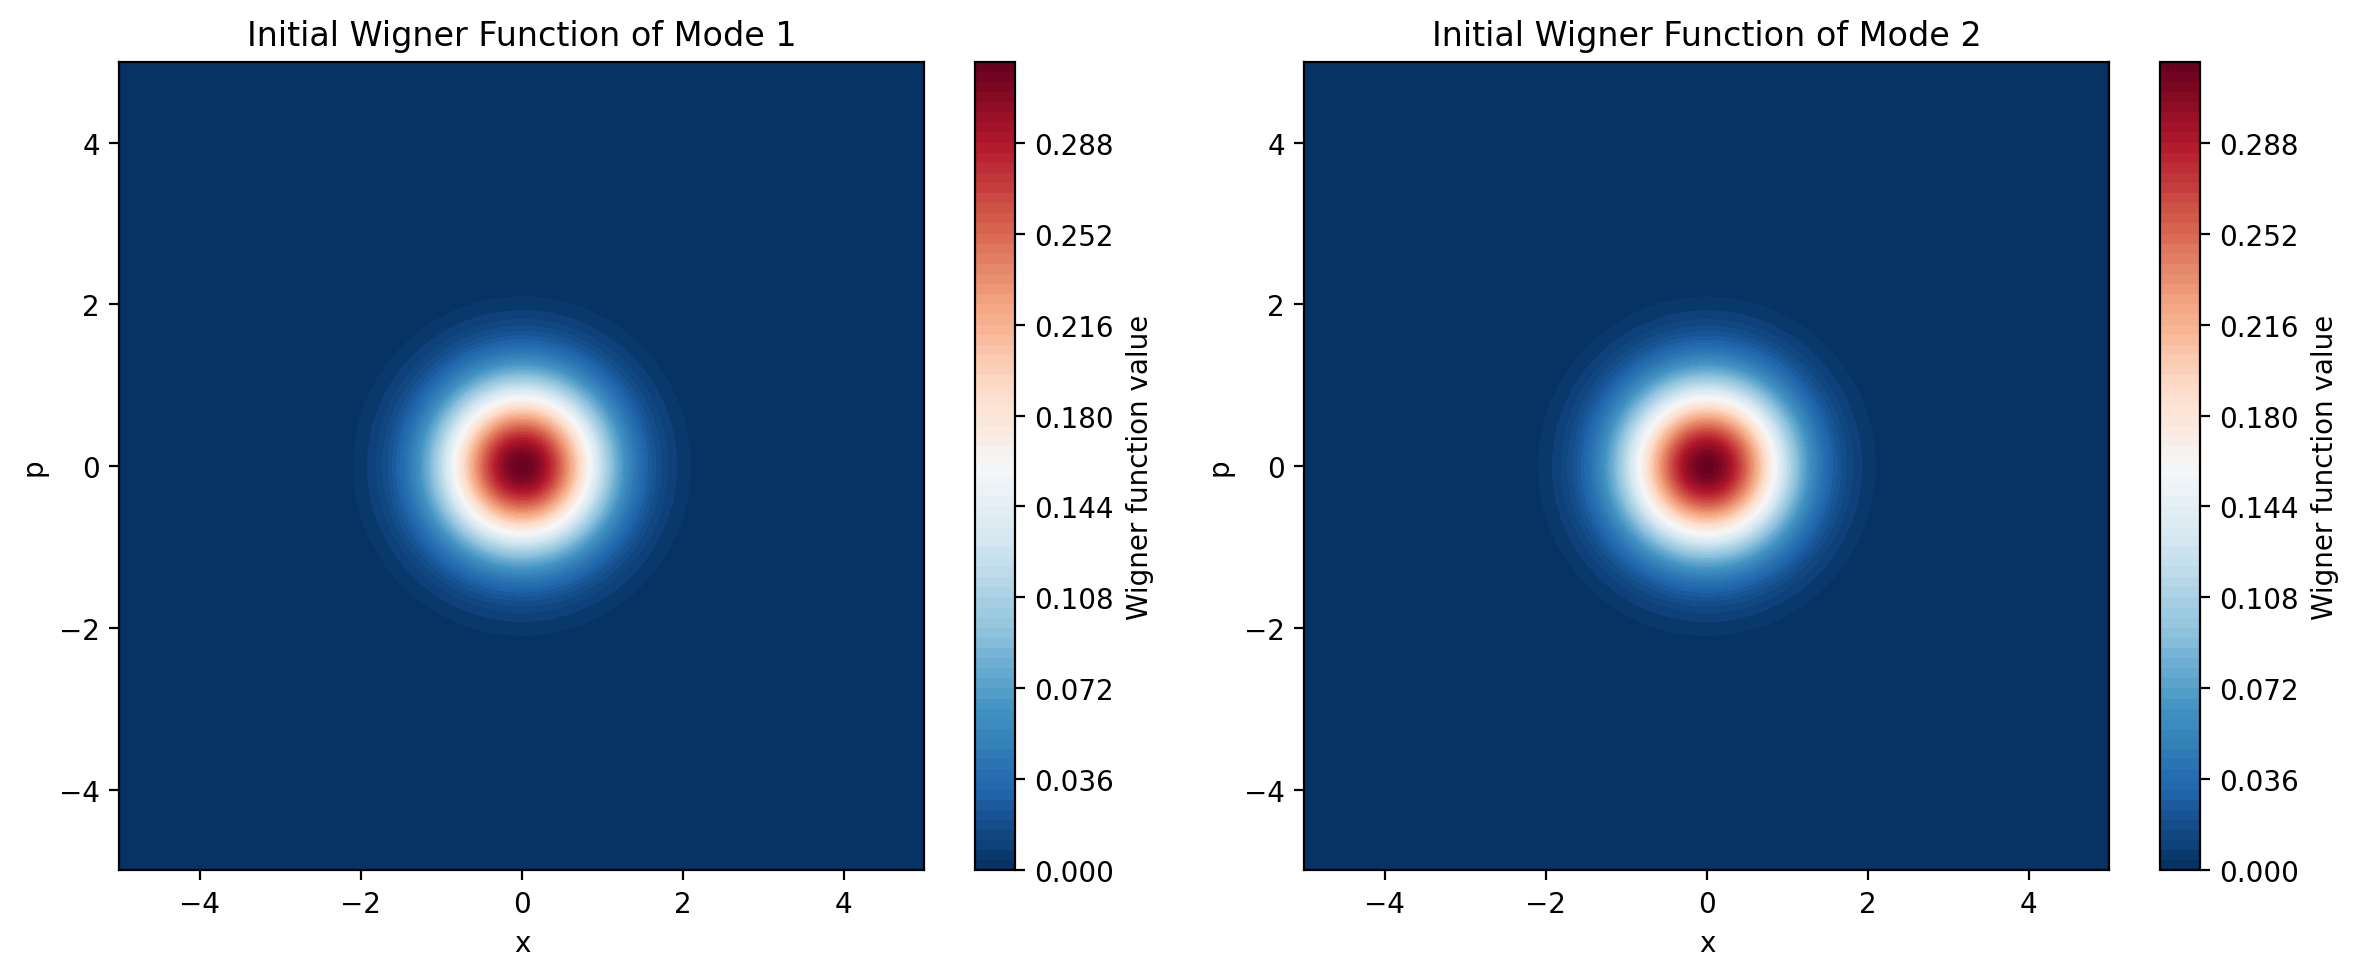

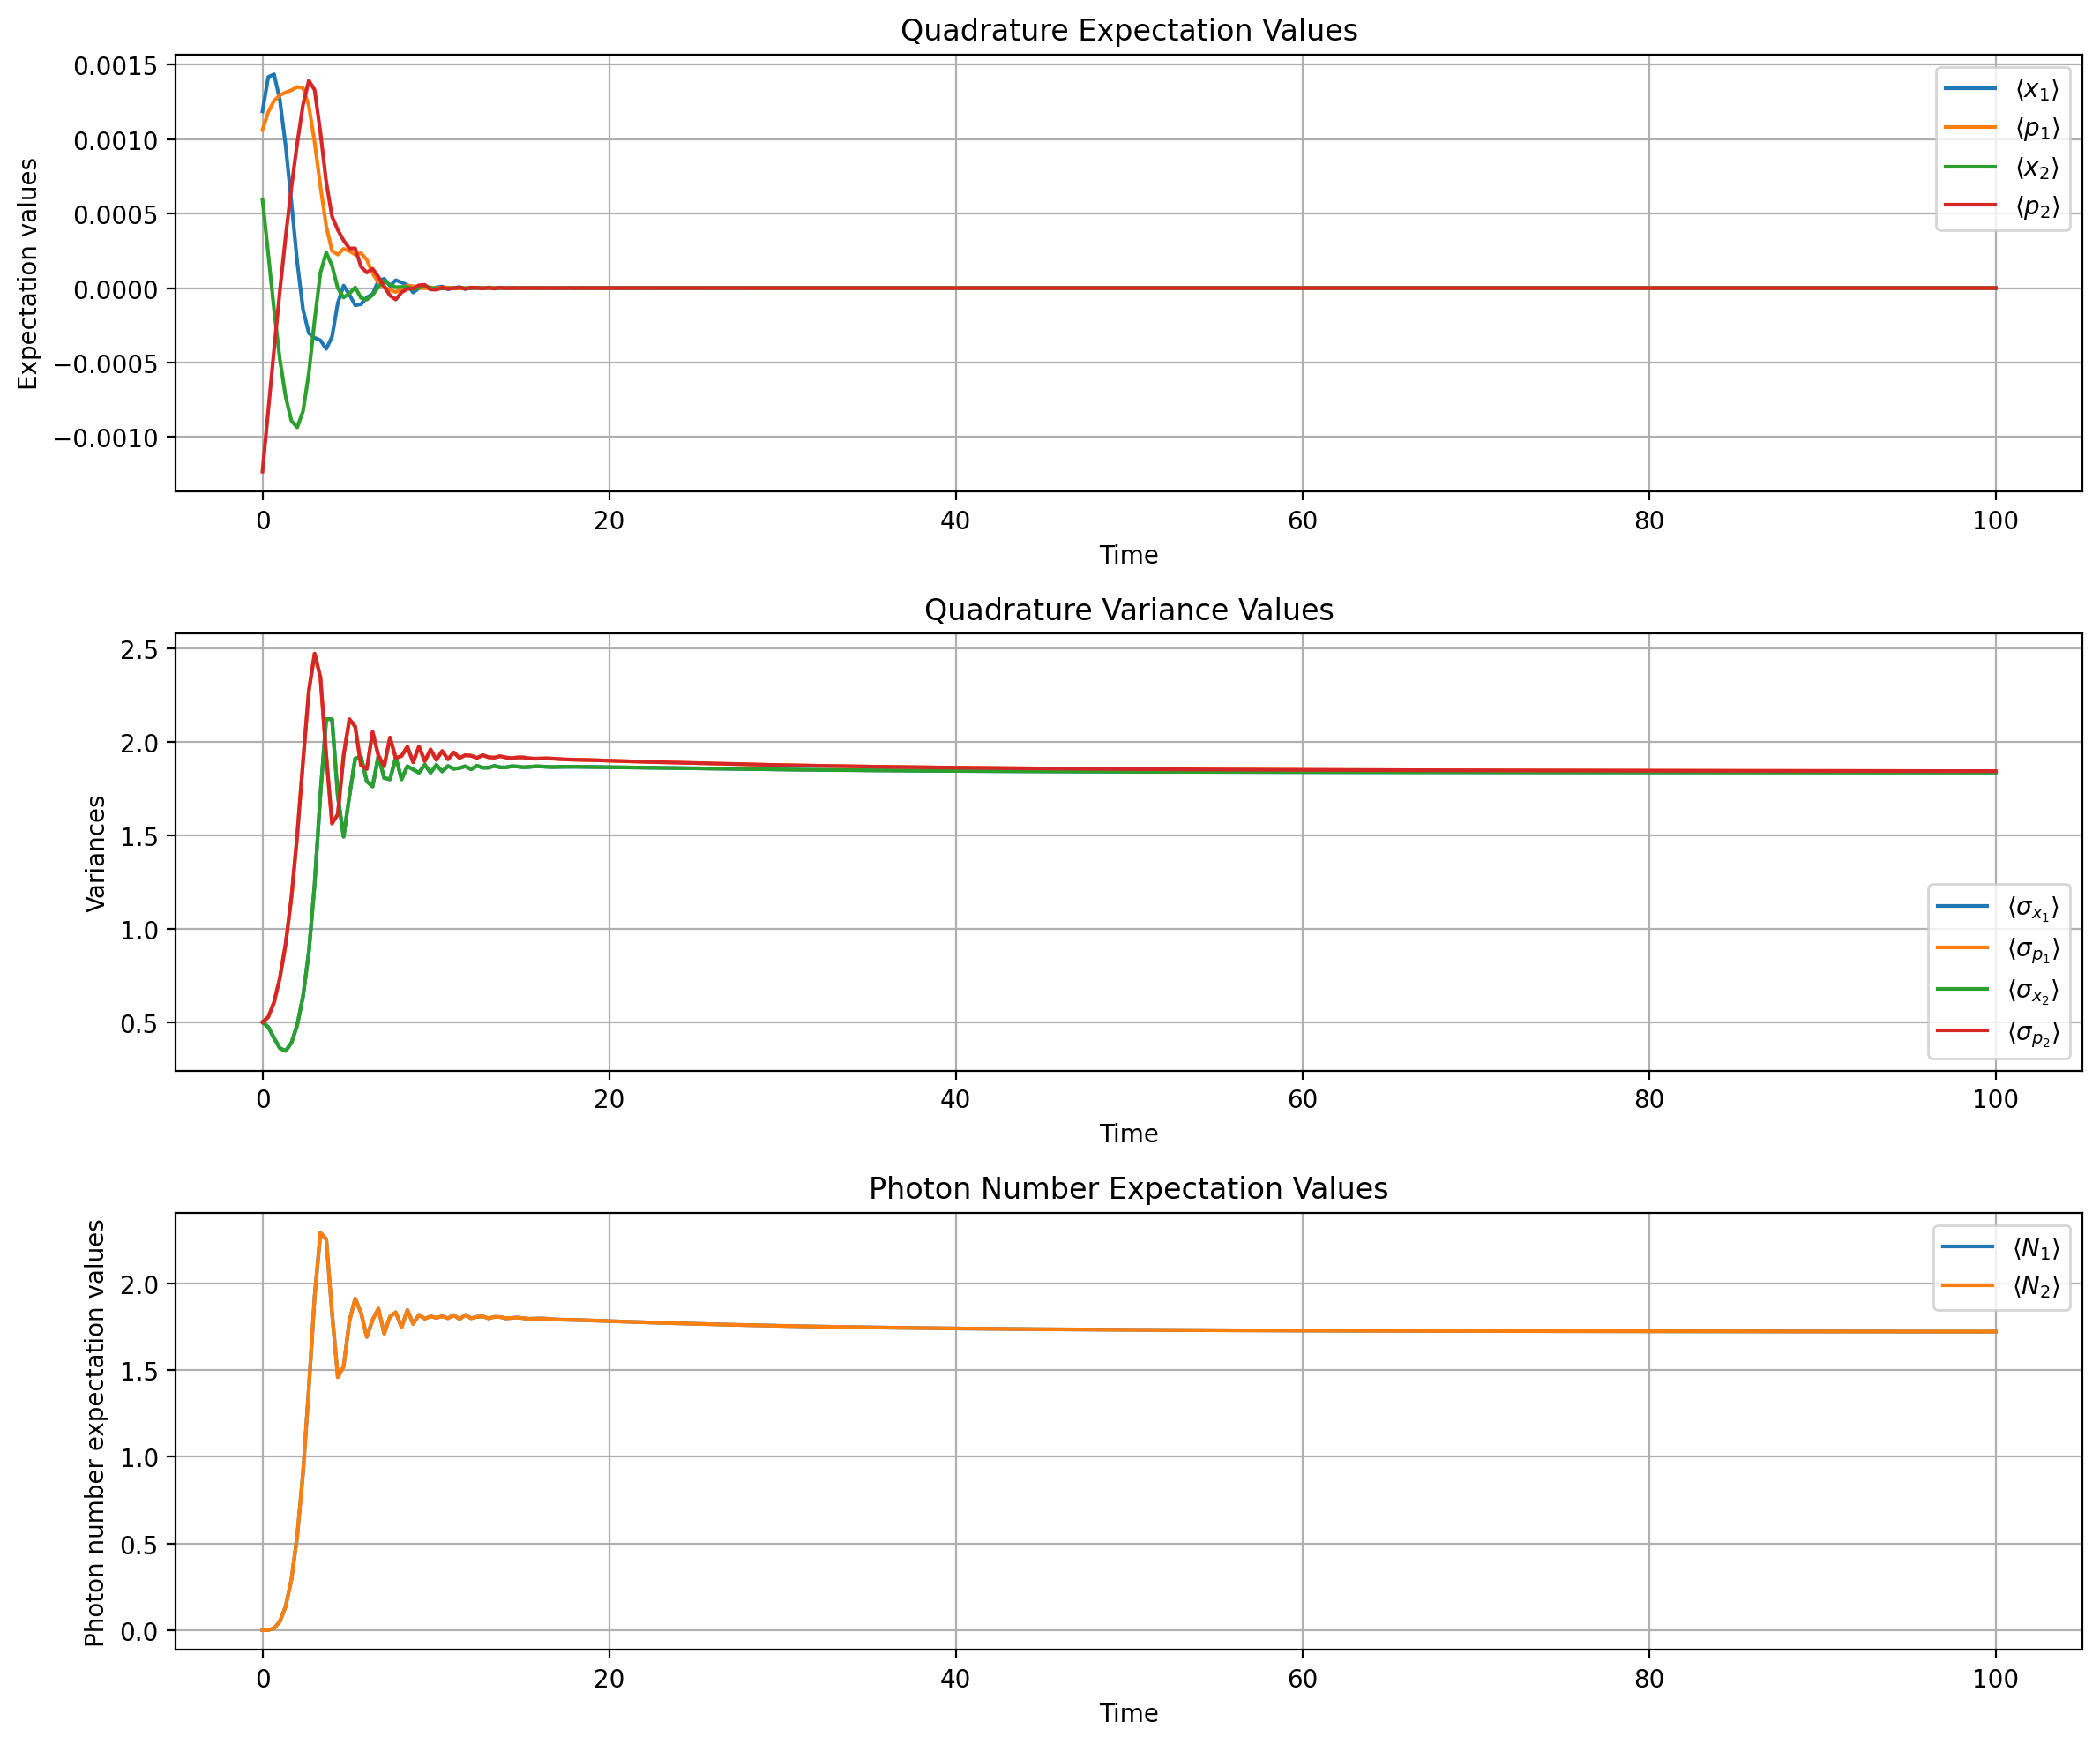

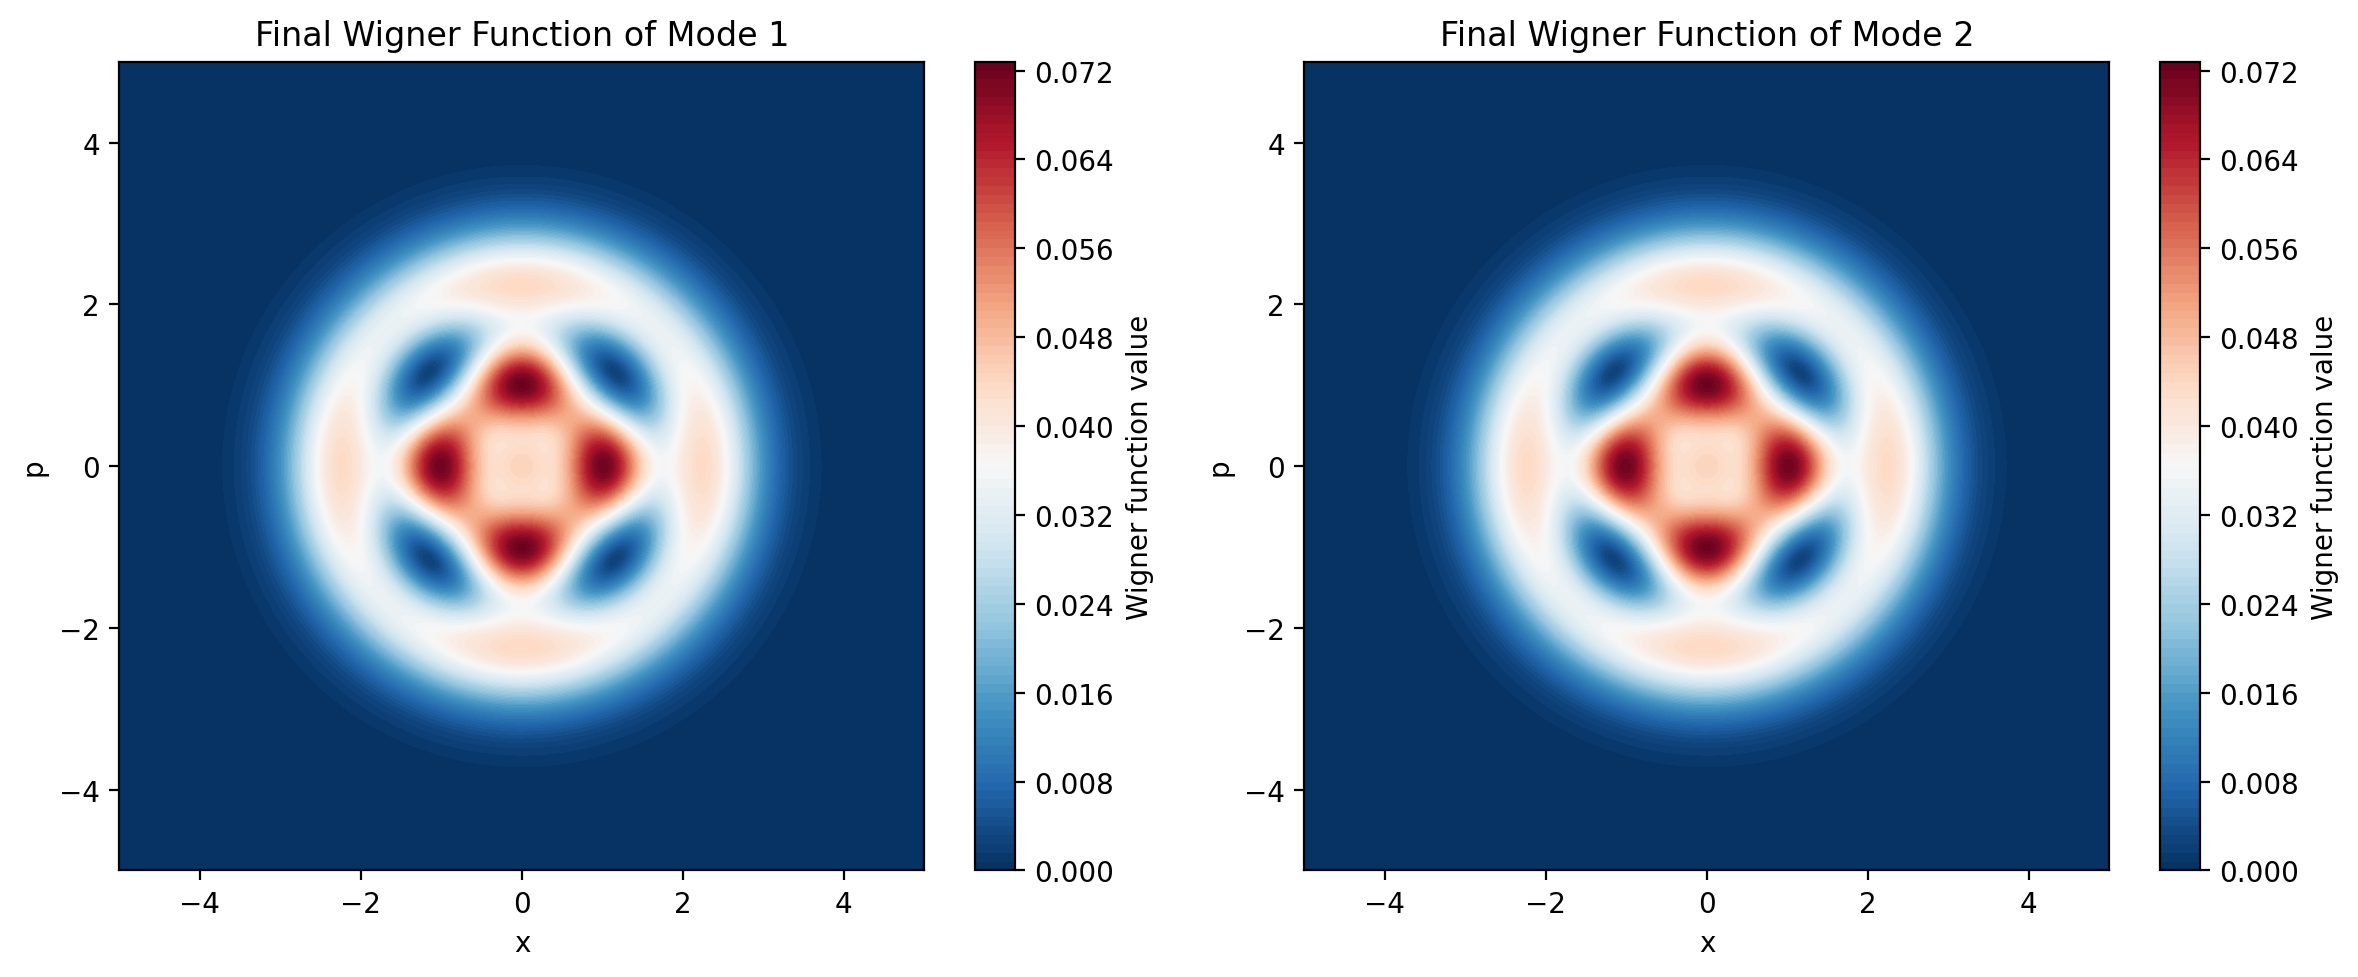

In [83]:
# 1. Define system parameters
N = 5  # Hilbert space dimension for each mode (number of Fock states)
p_0 = 0.0  # Pump offset
p=1.0  # Pump parameter
phi = np.pi/2 # Phase parameter φ
Gamma = 0.1  # Parameter Γ, rate of output coupler
gamma = 0.0  # Loss rate γ
kappa = 0.1  # Output coupling rate κ
eta = 0.0  # Crystal parameter η

# 2. Define operators for the two DOPOs
a1 = tensor(destroy(N), qeye(N))  # Annihilation operator for mode 1
a2 = tensor(qeye(N), destroy(N))  # Annihilation operator for mode 2
adag1 = a1.dag()  # Creation operator for mode 1
adag2 = a2.dag()  # Creation operator for mode 2

# 3. Construct the Hamiltonian
def H_12(t,args):
    pump_type = args['pump_type']

    if pump_type == 'linear':
         r=p * t + p0
    elif pump_type == 'sqrt':
         r=p * np.sqrt(t) + p0
    elif pump_type == 'sinusoidal':
         r= p * np.sin(t) + p0
    elif pump_type == 'chaotic':
         r= p * random.random() + p0
    else:
        raise ValueError(f"Unknown pump type: {pump_type}")

    return (-1j * r/ 4) * (adag1**2 + adag2**2 - a1**2 - a2**2) \
    - (np.sin(phi) / (Gamma + 1)) * (adag1 * a2 + a1 * adag2)

# Define time-dependent Hamiltonian in QobjEvo format
pump_type = 'linear'  # Default pump type (can be set to 'linear', 'sqrt', 'sinusoidal', or 'chaotic')
H = QobjEvo(H_12, args={'pump_type': pump_type})


# 4. Define the collapse operators
L_loss_1 = np.sqrt(2 * gamma) * a1
L_loss_2 = np.sqrt(2 * gamma) * a2

L_out_1 = np.sqrt(2 * kappa) * a1
L_out_2 = np.sqrt(2 * kappa) * a2

L_xtal_1 = -np.sqrt(eta) * a1**2
L_xtal_2 = -np.sqrt(eta) * a2**2

# 5. List of collapse operators
c_ops = [L_loss_1, L_loss_2, L_out_1, L_out_2, L_xtal_1, L_xtal_2]

# 6. Initial state (vacuum state for both modes)

real_parts = 2*np.random.random(2)-1  # Real parts
imag_parts = 2*np.random.random(2)-1  # Imaginary parts
g_0=0.001
complex_amplitude = g_0*(real_parts + 1j * imag_parts)
rho0 = tensor(coherent_dm(N, complex_amplitude[0]), coherent_dm(N, complex_amplitude[1]))

# r=0.1
# theta=0
# rho0 = tensor(qt.Qobj(squeezed_dm(N, r, theta)),qt.Qobj(squeezed_dm(N, r, theta)))

xvec = np.linspace(-5, 5, 200)
W = qt.wigner(rho0, xvec, xvec)

# Wigner function for mode 1
rho_mode1 = rho0.ptrace(0)
xvec = np.linspace(-5, 5, 200)
W1 = qt.wigner(rho_mode1, xvec, xvec)

# Wigner function for mode 2
rho_mode2 = rho0.ptrace(1)
W2 = qt.wigner(rho_mode2, xvec, xvec)

X, Y = np.meshgrid(xvec, xvec)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Wigner function for mode 1
ax1 = axes[0]
contour1 = ax1.contourf(X, Y, W1, 100, cmap='RdBu_r')
fig.colorbar(contour1, ax=ax1, label='Wigner function value')
ax1.set_title('Initial Wigner Function of Mode 1')
ax1.set_xlabel('x')
ax1.set_ylabel('p')

# Plot Wigner function for mode 2
ax2 = axes[1]
contour2 = ax2.contourf(X, Y, W2, 100, cmap='RdBu_r')
fig.colorbar(contour2, ax=ax2, label='Wigner function value')
ax2.set_title('Initial Wigner Function of Mode 2')
ax2.set_xlabel('x')
ax2.set_ylabel('p')

# Adjust layout for clarity
plt.tight_layout()
plt.show()


# 7. Time evolution parameters
tlist = np.linspace(0, 100, 300)

# 8. Define operators for expectation values
x1 = (a1 + adag1) / np.sqrt(2)
p1 = -1j * (a1 - adag1) / np.sqrt(2)

x2 = (a2 + adag2) / np.sqrt(2)
p2 = -1j * (a2 - adag2) / np.sqrt(2)

N1=adag1*a1
N2=adag2*a2

e_ops = [x1, p1, x2, p2, x1**2, p1**2, x2**2, p2**2, N1, N2]

# 9. Solve the stochastic master equation
# For homodyne detection along the x quadrature
#result = smesolve(H, rho0, tlist, sc_ops=[a1 + a2], e_ops=e_ops, c_ops=c_ops, ntraj=10,options=qutip.Options(store_states=True))
result = mesolve(H, rho0, tlist,e_ops=e_ops, c_ops=c_ops,options=qutip.Options(store_states=True))

# 10. Extract expectation values
# Note: The result.expect arrays are already averaged in mesolve for e_ops
x1_expect = result.expect[0]  # ⟨x1⟩
p1_expect = result.expect[1]  # ⟨p1⟩
x2_expect = result.expect[2]  # ⟨x2⟩
p2_expect = result.expect[3]  # ⟨p2⟩

sigma_x1=result.expect[4]-x1_expect**2
sigma_p1=result.expect[5]-p1_expect**2
sigma_x2=result.expect[6]-x2_expect**2
sigma_p2=result.expect[7]-p2_expect**2

N1_expect=result.expect[8]
N2_expect=result.expect[9]


# 11. Plot expectation values
# Create a figure with 3 subplots stacked vertically
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Quadrature Expectation Values
axes[0].plot(tlist, x1_expect, label=r'$\langle x_1 \rangle$')
axes[0].plot(tlist, p1_expect, label=r'$\langle p_1 \rangle$')
axes[0].plot(tlist, x2_expect, label=r'$\langle x_2 \rangle$')
axes[0].plot(tlist, p2_expect, label=r'$\langle p_2 \rangle$')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Expectation values')
axes[0].legend()
axes[0].set_title('Quadrature Expectation Values')
axes[0].grid(True)

# Plot 2: Quadrature Variance Values
axes[1].plot(tlist, sigma_x1, label=r'$\langle \sigma_{x_1} \rangle$')
axes[1].plot(tlist, sigma_p1, label=r'$\langle \sigma_{p_1} \rangle$')
axes[1].plot(tlist, sigma_x2, label=r'$\langle \sigma_{x_2} \rangle$')
axes[1].plot(tlist, sigma_p2, label=r'$\langle \sigma_{p_2} \rangle$')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Variances')
axes[1].legend()
axes[1].set_title('Quadrature Variance Values')
axes[1].grid(True)

# Plot 3: Photon Number Expectation Values
axes[2].plot(tlist, N1_expect, label=r'$\langle N_1 \rangle$')
axes[2].plot(tlist, N2_expect, label=r'$\langle N_2 \rangle$')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Photon number expectation values')
axes[2].legend()
axes[2].set_title('Photon Number Expectation Values')
axes[2].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# 12. Compute the Wigner function of the combined system
# Since the system is two-mode, we can plot the marginal Wigner functions for each mode

# Wigner function for mode 1
rho_final = result.states[-1]
rho_mode1 = rho_final.ptrace(0)
xvec = np.linspace(-5, 5, 200)
W1 = qt.wigner(rho_mode1, xvec, xvec)

# Wigner function for mode 2
rho_mode2 = rho_final.ptrace(1)
W2 = qt.wigner(rho_mode2, xvec, xvec)

X, Y = np.meshgrid(xvec, xvec)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Wigner Function of Mode 1
contour1 = axes[0].contourf(X, Y, W1, 100, cmap='RdBu_r')
fig.colorbar(contour1, ax=axes[0], label='Wigner function value')
axes[0].set_title('Final Wigner Function of Mode 1')
axes[0].set_xlabel('x')
axes[0].set_ylabel('p')

# Plot Wigner Function of Mode 2
contour2 = axes[1].contourf(X, Y, W2, 100, cmap='RdBu_r')
fig.colorbar(contour2, ax=axes[1], label='Wigner function value')
axes[1].set_title('Final Wigner Function of Mode 2')
axes[1].set_xlabel('x')
axes[1].set_ylabel('p')

# Adjust layout
plt.tight_layout()
plt.show()





# Animation of The Wigner Function for two Coupled DOPOs

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1800x750', '-pix_fmt', 'rgba', '-framerate', '10', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'wigner_dynamics_subplots.mp4']' returned non-zero exit status 255.

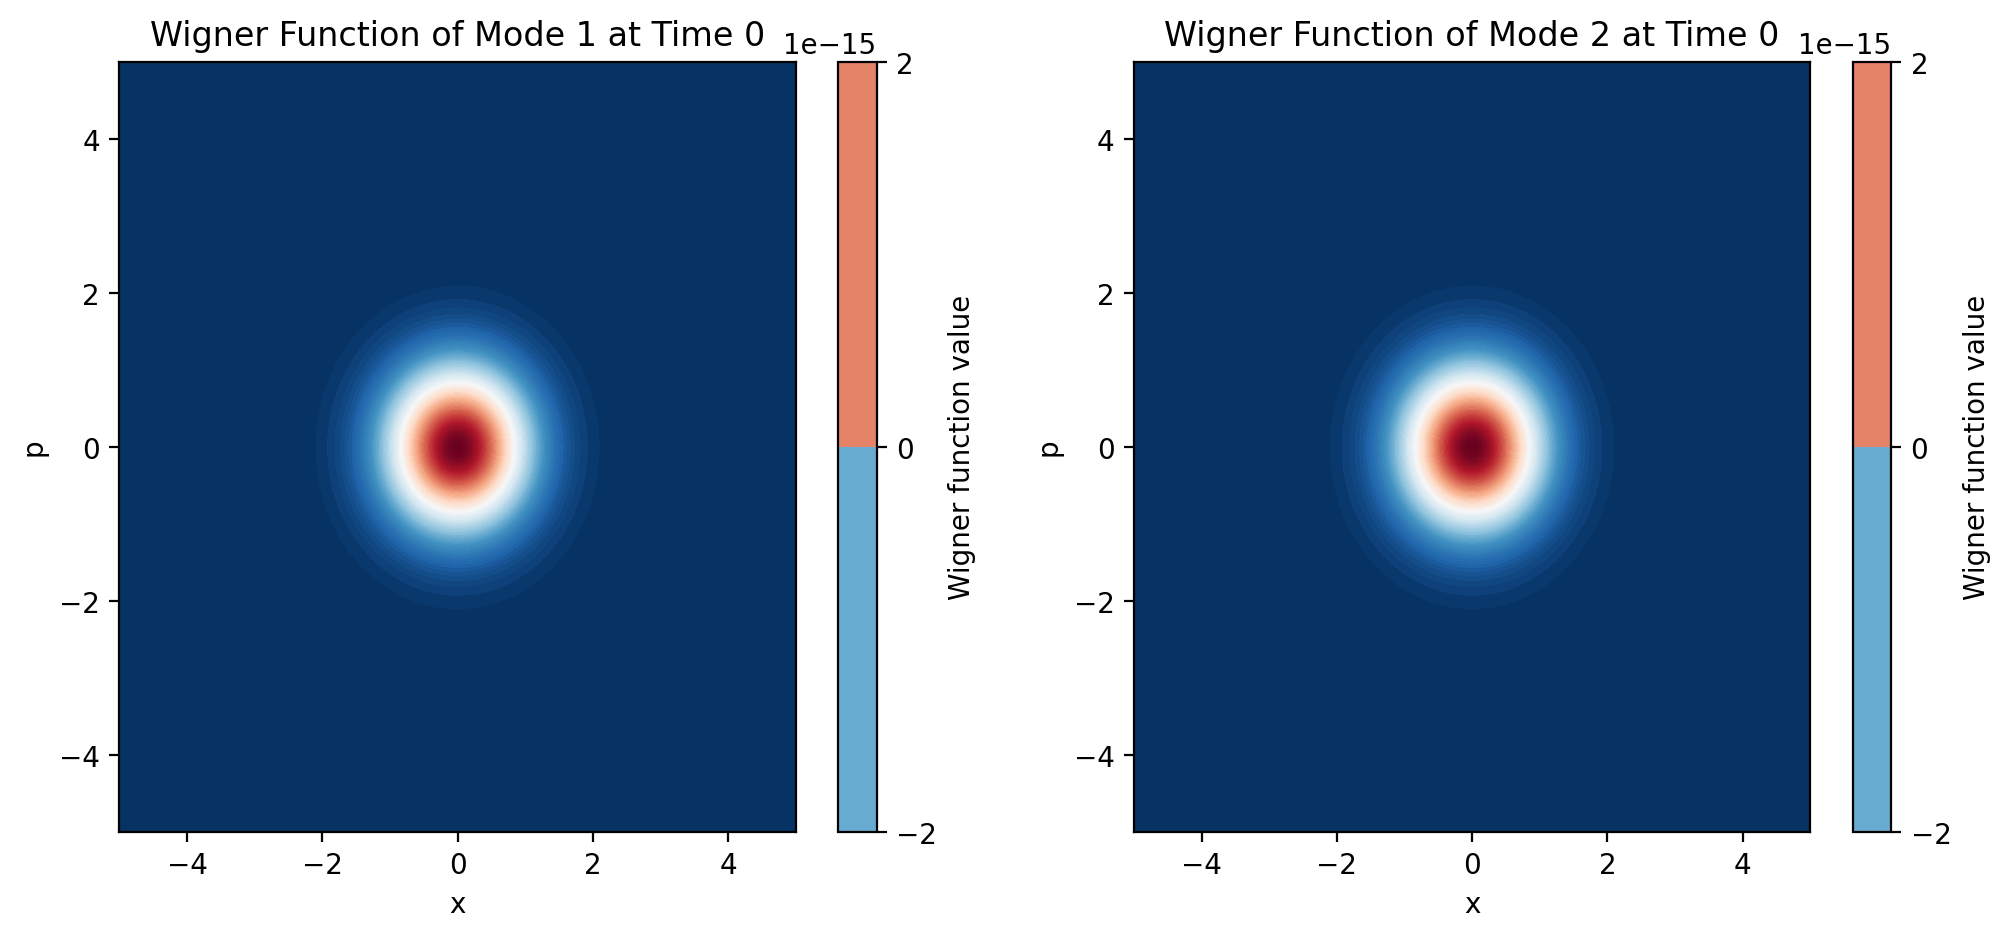

In [80]:
##### Animation Part ############

# Assuming `result.states` contains the time-evolved density matrices
# Extracting the modes for animation
xvec = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(xvec, xvec)

# Initialize the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Initialize contour plots with empty data
contour1 = axes[0].contourf(X, Y, np.zeros_like(X), 100, cmap='RdBu_r')
contour2 = axes[1].contourf(X, Y, np.zeros_like(X), 100, cmap='RdBu_r')

# Add colorbars
fig.colorbar(contour1, ax=axes[0], label='Wigner function value')
fig.colorbar(contour2, ax=axes[1], label='Wigner function value')

# Configure titles and labels
axes[0].set_title('Wigner Function of Mode 1')
axes[0].set_xlabel('x')
axes[0].set_ylabel('p')

axes[1].set_title('Wigner Function of Mode 2')
axes[1].set_xlabel('x')
axes[1].set_ylabel('p')

# Function to update the contours for each frame
def update(frame):
    rho_mode1 = result.states[frame].ptrace(0)  # Partial trace for mode 1
    rho_mode2 = result.states[frame].ptrace(1)  # Partial trace for mode 2

    W1 = qt.wigner(rho_mode1, xvec, xvec)  # Compute Wigner function for mode 1
    W2 = qt.wigner(rho_mode2, xvec, xvec)  # Compute Wigner function for mode 2

    # Remove existing collections and redraw for Mode 1
    for coll in axes[0].collections:
        coll.remove()
    axes[0].contourf(X, Y, W1, 100, cmap='RdBu_r')
    axes[0].set_title(f'Wigner Function of Mode 1 at Time {frame}')

    # Remove existing collections and redraw for Mode 2
    for coll in axes[1].collections:
        coll.remove()
    axes[1].contourf(X, Y, W2, 100, cmap='RdBu_r')
    axes[1].set_title(f'Wigner Function of Mode 2 at Time {frame}')

# Create the animation
anim = FuncAnimation(fig, update, frames=len(tlist), interval=100, repeat=False)

# Show the animation
# plt.tight_layout()
# plt.show()

# Optional: Save the animation as a file
anim.save('wigner_dynamics_subplots.mp4', fps=10, dpi=150)

# Contribution Statement

In developing this code, I used ChatGPT as well as the CIM optimizer package developed by Peter McMahon's lab [9].


# References

[1] Zhang, T., Tao, Q., Liu, B., Grimaldi, A., Raimondo, E., Jiménez, M., ... & Han, J. (2024). A Review of Ising Machines Implemented in Conventional and Emerging Technologies. IEEE Transactions on Nanotechnology!

[2] Lu, B., Liu, L., Song, J. Y., Wen, K., & Wang, C. (2023). Recent progress on coherent computation based on quantum squeezing. AAPPS Bulletin, 33(1), 7.

[3] IBM Quantum. (n.d.). Max-Cut and TSP Example. Qiskit Optimization Tutorials. Retrieved December 15, 2024, from https://qiskit-community.github.io/qiskit-optimization/tutorials/06_examples_max_cut_and_tsp.html

[4] Li, P., Cheng, H., Liu, Y., Wang, D., & Wu, J. (2024, July). PyCIM: A Python Framework for the Dynamics of Coherent Ising Machine. In International Conference on Intelligent Computing (pp. 194-207). Singapore: Springer Nature Singapore.

[5] Leleu, T., Yamamoto, Y., McMahon, P. L., & Aihara, K. (2019). Destabilization of local minima in analog spin systems by correction of amplitude heterogeneity. Physical review letters, 122(4), 040607.

[6] Leleu, T., Khoyratee, F., Levi, T., Hamerly, R., Kohno, T., & Aihara, K. (2021). Scaling advantage of chaotic amplitude control for high-performance combinatorial optimization. Communications Physics, 4(1), 266.

[7] Ng, E. (2023). Quantum Parametric Oscillators Coupled in Time and Frequency Domains. Stanford University.

[8] Onodera, T., Ng, E., & Mabuchi, H. (2017, April). A quantum network model for the coherent Ising machine. In Quantum Information and Measurement (pp. QW3B-2). Optica Publishing Group.

[9] Chen, F., Isakov, B., King, T., Leleu, T., McMahon, P., & Onodera, T. (2022). cim-optimizer: a simulator of the Coherent Ising Machine [Computer software]. https://github.com/mcmahon-lab/cim-optimizer